Here we'll first be loading the FC matrices and explore their structure

In [1]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset
import torch 
print('GPU available?', torch.cuda.is_available())

GPU available? True


In [2]:
dataset = read_dataset()

In [3]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has Autism Spectrum Disorder (ASD)
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
len(dataset)


Data(x=[116, 116], edge_index=[2, 1016], edge_attr=[1016, 1], y=[1])
['y', 'edge_index', 'x', 'edge_attr']
ValuesView({'x': tensor([[ 0.0000,  0.4543,  0.2477,  ...,  0.1753,  0.2247, -0.1751],
        [ 0.4543,  0.0000, -0.2204,  ..., -0.1947, -0.2258, -0.1434],
        [ 0.2477, -0.2204,  0.0000,  ..., -0.0521, -0.0804, -0.2025],
        ...,
        [ 0.1753, -0.1947, -0.0521,  ...,  0.0000,  0.6875, -0.1364],
        [ 0.2247, -0.2258, -0.0804,  ...,  0.6875,  0.0000,  0.0929],
        [-0.1751, -0.1434, -0.2025,  ..., -0.1364,  0.0929,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 114, 115, 115],
        [  1,  10,  12,  ..., 113,  94, 109]]), 'edge_attr': tensor([[0.4543],
        [0.5913],
        [0.4224],
        ...,
        [0.6875],
        [0.4846],
        [0.5437]]), 'y': tensor([0])})


1099

In [4]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GCN_wo_edge_weight"
DATASET = "FC"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset,device="cpu")

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1): GCNConv(128, 128)
    (2): GCNConv(128, 128)
    (3): GCNConv(128, 128)
    (4): GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm(128)
    (1): BatchNorm(128)
    (2): BatchNorm(128)
    (3): BatchNorm(128)
    (4): BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# gnn.iterate()

In [6]:
#gnn.train()

In [7]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [8]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [9]:
gnn.evaluate()

Test Loss: 0.728, Train Acc: 1.000 Test Acc: 0.564


In [10]:
train_features, test_features = gnn.evaluate_with_features2()

In [11]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1044, 55)

In [14]:
import networkx as nx
def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        #small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

In [12]:
# print(len(train_properties))
# train_properties[0:5]



In [13]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [14]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [ ]:
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 500000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/500000], Property: num_nodes, Loss: 11288.2051
Epoch [2000/500000], Property: num_nodes, Loss: 9690.0205
Epoch [3000/500000], Property: num_nodes, Loss: 8369.7900
Epoch [4000/500000], Property: num_nodes, Loss: 7265.7632
Epoch [5000/500000], Property: num_nodes, Loss: 6333.4688
Epoch [6000/500000], Property: num_nodes, Loss: 5547.8389
Epoch [7000/500000], Property: num_nodes, Loss: 4887.1294
Epoch [8000/500000], Property: num_nodes, Loss: 4330.9502
Epoch [9000/500000], Property: num_nodes, Loss: 3862.7041
Epoch [10000/500000], Property: num_nodes, Loss: 3467.9194
Epoch [11000/500000], Property: num_nodes, Loss: 3136.0103
Epoch [12000/500000], Property: num_nodes, Loss: 2858.8420
Epoch [13000/500000], Property: num_nodes, Loss: 2627.7927
Epoch [14000/500000], Property: num_nodes, Loss: 2433.5249
Epoch [15000/500000], Property: num_nodes, Loss: 2268.6782
Epoch [16000/500000], Property: num_nodes, Loss: 2128.2119
Epoch [17000/500000], Property: num_nodes, Loss: 2007.6924
Epoch

Epoch [143000/500000], Property: num_nodes, Loss: 1.7059
Epoch [144000/500000], Property: num_nodes, Loss: 1.7059
Epoch [145000/500000], Property: num_nodes, Loss: 1.7059
Epoch [146000/500000], Property: num_nodes, Loss: 1.7059
Epoch [147000/500000], Property: num_nodes, Loss: 1.7059
Epoch [148000/500000], Property: num_nodes, Loss: 1.7059
Epoch [149000/500000], Property: num_nodes, Loss: 1.7059
Epoch [150000/500000], Property: num_nodes, Loss: 1.7059
Epoch [151000/500000], Property: num_nodes, Loss: 1.7059
Epoch [152000/500000], Property: num_nodes, Loss: 1.7059
Epoch [153000/500000], Property: num_nodes, Loss: 1.7059
Epoch [154000/500000], Property: num_nodes, Loss: 1.7059
Epoch [155000/500000], Property: num_nodes, Loss: 1.7059
Epoch [156000/500000], Property: num_nodes, Loss: 1.7059
Epoch [157000/500000], Property: num_nodes, Loss: 1.7059
Epoch [158000/500000], Property: num_nodes, Loss: 1.7059
Epoch [159000/500000], Property: num_nodes, Loss: 1.7059
Epoch [160000/500000], Property

Epoch [287000/500000], Property: num_nodes, Loss: 1.7059
Epoch [288000/500000], Property: num_nodes, Loss: 1.7059
Epoch [289000/500000], Property: num_nodes, Loss: 1.7059
Epoch [290000/500000], Property: num_nodes, Loss: 1.7059
Epoch [291000/500000], Property: num_nodes, Loss: 1.7059
Epoch [292000/500000], Property: num_nodes, Loss: 1.7059
Epoch [293000/500000], Property: num_nodes, Loss: 1.7059
Epoch [294000/500000], Property: num_nodes, Loss: 1.7059
Epoch [295000/500000], Property: num_nodes, Loss: 1.7059
Epoch [296000/500000], Property: num_nodes, Loss: 1.7059
Epoch [297000/500000], Property: num_nodes, Loss: 1.7059
Epoch [298000/500000], Property: num_nodes, Loss: 1.7059
Epoch [299000/500000], Property: num_nodes, Loss: 1.7059
Epoch [300000/500000], Property: num_nodes, Loss: 1.7059
Epoch [301000/500000], Property: num_nodes, Loss: 1.7059
Epoch [302000/500000], Property: num_nodes, Loss: 1.7059
Epoch [303000/500000], Property: num_nodes, Loss: 1.7059
Epoch [304000/500000], Property

Epoch [431000/500000], Property: num_nodes, Loss: 1.7059
Epoch [432000/500000], Property: num_nodes, Loss: 1.7059
Epoch [433000/500000], Property: num_nodes, Loss: 1.7059
Epoch [434000/500000], Property: num_nodes, Loss: 1.7059
Epoch [435000/500000], Property: num_nodes, Loss: 1.7059
Epoch [436000/500000], Property: num_nodes, Loss: 1.7059
Epoch [437000/500000], Property: num_nodes, Loss: 1.7059
Epoch [438000/500000], Property: num_nodes, Loss: 1.7059
Epoch [439000/500000], Property: num_nodes, Loss: 1.7059
Epoch [440000/500000], Property: num_nodes, Loss: 1.7059
Epoch [441000/500000], Property: num_nodes, Loss: 1.7059
Epoch [442000/500000], Property: num_nodes, Loss: 1.7059
Epoch [443000/500000], Property: num_nodes, Loss: 1.7059
Epoch [444000/500000], Property: num_nodes, Loss: 1.7059
Epoch [445000/500000], Property: num_nodes, Loss: 1.7059
Epoch [446000/500000], Property: num_nodes, Loss: 1.7059
Epoch [447000/500000], Property: num_nodes, Loss: 1.7059
Epoch [448000/500000], Property

Epoch [69000/500000], Property: num_edges, Loss: 59734.1055
Epoch [70000/500000], Property: num_edges, Loss: 59160.5000
Epoch [71000/500000], Property: num_edges, Loss: 58604.2852
Epoch [72000/500000], Property: num_edges, Loss: 58065.1445
Epoch [73000/500000], Property: num_edges, Loss: 57543.2344
Epoch [74000/500000], Property: num_edges, Loss: 57038.1914
Epoch [75000/500000], Property: num_edges, Loss: 56549.8594
Epoch [76000/500000], Property: num_edges, Loss: 56077.8984
Epoch [77000/500000], Property: num_edges, Loss: 55621.5547
Epoch [78000/500000], Property: num_edges, Loss: 55179.6992
Epoch [79000/500000], Property: num_edges, Loss: 54751.2617
Epoch [80000/500000], Property: num_edges, Loss: 54335.5820
Epoch [81000/500000], Property: num_edges, Loss: 53932.1641
Epoch [82000/500000], Property: num_edges, Loss: 53540.4570
Epoch [83000/500000], Property: num_edges, Loss: 53160.0234
Epoch [84000/500000], Property: num_edges, Loss: 52790.2266
Epoch [85000/500000], Property: num_edge

Epoch [204000/500000], Property: num_edges, Loss: 33167.7227
Epoch [205000/500000], Property: num_edges, Loss: 33073.8828
Epoch [206000/500000], Property: num_edges, Loss: 32980.3438
Epoch [207000/500000], Property: num_edges, Loss: 32887.1055
Epoch [208000/500000], Property: num_edges, Loss: 32794.1758
Epoch [209000/500000], Property: num_edges, Loss: 32701.5508
Epoch [210000/500000], Property: num_edges, Loss: 32609.2344
Epoch [211000/500000], Property: num_edges, Loss: 32517.2148
Epoch [212000/500000], Property: num_edges, Loss: 32425.5059
Epoch [213000/500000], Property: num_edges, Loss: 32334.0996
Epoch [214000/500000], Property: num_edges, Loss: 32242.9961
Epoch [215000/500000], Property: num_edges, Loss: 32152.2031
Epoch [216000/500000], Property: num_edges, Loss: 32061.7109
Epoch [217000/500000], Property: num_edges, Loss: 31971.5254
Epoch [218000/500000], Property: num_edges, Loss: 31881.6406
Epoch [219000/500000], Property: num_edges, Loss: 31792.0625
Epoch [220000/500000], P

Epoch [339000/500000], Property: num_edges, Loss: 23191.0273
Epoch [340000/500000], Property: num_edges, Loss: 23137.9004
Epoch [341000/500000], Property: num_edges, Loss: 23085.0918
Epoch [342000/500000], Property: num_edges, Loss: 23032.5977
Epoch [343000/500000], Property: num_edges, Loss: 22980.4160
Epoch [344000/500000], Property: num_edges, Loss: 22928.5488
Epoch [345000/500000], Property: num_edges, Loss: 22876.9961
Epoch [346000/500000], Property: num_edges, Loss: 22825.7578
Epoch [347000/500000], Property: num_edges, Loss: 22774.8340
Epoch [348000/500000], Property: num_edges, Loss: 22724.2246
Epoch [349000/500000], Property: num_edges, Loss: 22673.9277
Epoch [350000/500000], Property: num_edges, Loss: 22623.9492
Epoch [351000/500000], Property: num_edges, Loss: 22574.2812
Epoch [352000/500000], Property: num_edges, Loss: 22524.9297
Epoch [353000/500000], Property: num_edges, Loss: 22475.8887
Epoch [354000/500000], Property: num_edges, Loss: 22427.1602
Epoch [355000/500000], P

Epoch [474000/500000], Property: num_edges, Loss: 18890.7910
Epoch [475000/500000], Property: num_edges, Loss: 18879.6270
Epoch [476000/500000], Property: num_edges, Loss: 18868.7559
Epoch [477000/500000], Property: num_edges, Loss: 18858.1797
Epoch [478000/500000], Property: num_edges, Loss: 18847.9023
Epoch [479000/500000], Property: num_edges, Loss: 18837.9180
Epoch [480000/500000], Property: num_edges, Loss: 18828.2305
Epoch [481000/500000], Property: num_edges, Loss: 18818.8379
Epoch [482000/500000], Property: num_edges, Loss: 18809.7422
Epoch [483000/500000], Property: num_edges, Loss: 18800.9395
Epoch [484000/500000], Property: num_edges, Loss: 18792.4316
Epoch [485000/500000], Property: num_edges, Loss: 18784.2207
Epoch [486000/500000], Property: num_edges, Loss: 18776.3066
Epoch [487000/500000], Property: num_edges, Loss: 18768.6855
Epoch [488000/500000], Property: num_edges, Loss: 18761.5391
Epoch [489000/500000], Property: num_edges, Loss: 18754.7168
Epoch [490000/500000], P

Epoch [120000/500000], Property: density, Loss: 0.0004
Epoch [121000/500000], Property: density, Loss: 0.0004
Epoch [122000/500000], Property: density, Loss: 0.0004
Epoch [123000/500000], Property: density, Loss: 0.0004
Epoch [124000/500000], Property: density, Loss: 0.0004
Epoch [125000/500000], Property: density, Loss: 0.0004
Epoch [126000/500000], Property: density, Loss: 0.0004
Epoch [127000/500000], Property: density, Loss: 0.0004
Epoch [128000/500000], Property: density, Loss: 0.0004
Epoch [129000/500000], Property: density, Loss: 0.0004
Epoch [130000/500000], Property: density, Loss: 0.0004
Epoch [131000/500000], Property: density, Loss: 0.0004
Epoch [132000/500000], Property: density, Loss: 0.0004
Epoch [133000/500000], Property: density, Loss: 0.0004
Epoch [134000/500000], Property: density, Loss: 0.0004
Epoch [135000/500000], Property: density, Loss: 0.0004
Epoch [136000/500000], Property: density, Loss: 0.0004
Epoch [137000/500000], Property: density, Loss: 0.0004
Epoch [138

Epoch [269000/500000], Property: density, Loss: 0.0004
Epoch [270000/500000], Property: density, Loss: 0.0004
Epoch [271000/500000], Property: density, Loss: 0.0004
Epoch [272000/500000], Property: density, Loss: 0.0004
Epoch [273000/500000], Property: density, Loss: 0.0004
Epoch [274000/500000], Property: density, Loss: 0.0004
Epoch [275000/500000], Property: density, Loss: 0.0004
Epoch [276000/500000], Property: density, Loss: 0.0004
Epoch [277000/500000], Property: density, Loss: 0.0004
Epoch [278000/500000], Property: density, Loss: 0.0004
Epoch [279000/500000], Property: density, Loss: 0.0004
Epoch [280000/500000], Property: density, Loss: 0.0004
Epoch [281000/500000], Property: density, Loss: 0.0004
Epoch [282000/500000], Property: density, Loss: 0.0004
Epoch [283000/500000], Property: density, Loss: 0.0004
Epoch [284000/500000], Property: density, Loss: 0.0004
Epoch [285000/500000], Property: density, Loss: 0.0004
Epoch [286000/500000], Property: density, Loss: 0.0004
Epoch [287

Epoch [418000/500000], Property: density, Loss: 0.0004
Epoch [419000/500000], Property: density, Loss: 0.0004
Epoch [420000/500000], Property: density, Loss: 0.0004
Epoch [421000/500000], Property: density, Loss: 0.0004
Epoch [422000/500000], Property: density, Loss: 0.0004
Epoch [423000/500000], Property: density, Loss: 0.0004
Epoch [424000/500000], Property: density, Loss: 0.0004
Epoch [425000/500000], Property: density, Loss: 0.0004
Epoch [426000/500000], Property: density, Loss: 0.0004
Epoch [427000/500000], Property: density, Loss: 0.0004
Epoch [428000/500000], Property: density, Loss: 0.0004
Epoch [429000/500000], Property: density, Loss: 0.0004
Epoch [430000/500000], Property: density, Loss: 0.0004
Epoch [431000/500000], Property: density, Loss: 0.0004
Epoch [432000/500000], Property: density, Loss: 0.0004
Epoch [433000/500000], Property: density, Loss: 0.0004
Epoch [434000/500000], Property: density, Loss: 0.0004
Epoch [435000/500000], Property: density, Loss: 0.0004
Epoch [436

Epoch [61000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [62000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [63000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [64000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [65000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [66000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [67000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [68000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [69000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [70000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [71000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [72000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [73000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [74000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [75000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [76000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [77000/500000], Property: avg_path_len, Loss: 0.24

Epoch [199000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [200000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [201000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [202000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [203000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [204000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [205000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [206000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [207000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [208000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [209000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [210000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [211000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [212000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [213000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [214000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [215000/500000], Property: avg_pat

Epoch [336000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [337000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [338000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [339000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [340000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [341000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [342000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [343000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [344000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [345000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [346000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [347000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [348000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [349000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [350000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [351000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [352000/500000], Property: avg_pat

Epoch [473000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [474000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [475000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [476000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [477000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [478000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [479000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [480000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [481000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [482000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [483000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [484000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [485000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [486000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [487000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [488000/500000], Property: avg_path_len, Loss: 0.2418
Epoch [489000/500000], Property: avg_pat

Epoch [106000/500000], Property: num_cliques, Loss: 1298.3303
Epoch [107000/500000], Property: num_cliques, Loss: 1283.8611
Epoch [108000/500000], Property: num_cliques, Loss: 1269.6874
Epoch [109000/500000], Property: num_cliques, Loss: 1255.8092
Epoch [110000/500000], Property: num_cliques, Loss: 1242.2263
Epoch [111000/500000], Property: num_cliques, Loss: 1228.9392
Epoch [112000/500000], Property: num_cliques, Loss: 1215.9473
Epoch [113000/500000], Property: num_cliques, Loss: 1203.2512
Epoch [114000/500000], Property: num_cliques, Loss: 1190.8505
Epoch [115000/500000], Property: num_cliques, Loss: 1178.7451
Epoch [116000/500000], Property: num_cliques, Loss: 1166.9353
Epoch [117000/500000], Property: num_cliques, Loss: 1155.4211
Epoch [118000/500000], Property: num_cliques, Loss: 1144.2024
Epoch [119000/500000], Property: num_cliques, Loss: 1133.2789
Epoch [120000/500000], Property: num_cliques, Loss: 1122.6810
Epoch [121000/500000], Property: num_cliques, Loss: 1112.4276
Epoch [1

Epoch [240000/500000], Property: num_cliques, Loss: 936.8113
Epoch [241000/500000], Property: num_cliques, Loss: 936.8113
Epoch [242000/500000], Property: num_cliques, Loss: 936.8114
Epoch [243000/500000], Property: num_cliques, Loss: 936.8113
Epoch [244000/500000], Property: num_cliques, Loss: 936.8113
Epoch [245000/500000], Property: num_cliques, Loss: 936.8114
Epoch [246000/500000], Property: num_cliques, Loss: 936.8113
Epoch [247000/500000], Property: num_cliques, Loss: 936.8114
Epoch [248000/500000], Property: num_cliques, Loss: 936.8113
Epoch [249000/500000], Property: num_cliques, Loss: 936.8113
Epoch [250000/500000], Property: num_cliques, Loss: 936.8113
Epoch [251000/500000], Property: num_cliques, Loss: 936.8115
Epoch [252000/500000], Property: num_cliques, Loss: 936.8114
Epoch [253000/500000], Property: num_cliques, Loss: 936.8114
Epoch [254000/500000], Property: num_cliques, Loss: 936.8113
Epoch [255000/500000], Property: num_cliques, Loss: 936.8113
Epoch [256000/500000], P

Epoch [375000/500000], Property: num_cliques, Loss: 936.8113
Epoch [376000/500000], Property: num_cliques, Loss: 936.8114
Epoch [377000/500000], Property: num_cliques, Loss: 936.8113
Epoch [378000/500000], Property: num_cliques, Loss: 936.8113
Epoch [379000/500000], Property: num_cliques, Loss: 936.8113
Epoch [380000/500000], Property: num_cliques, Loss: 936.8114
Epoch [381000/500000], Property: num_cliques, Loss: 936.8113
Epoch [382000/500000], Property: num_cliques, Loss: 936.8113
Epoch [383000/500000], Property: num_cliques, Loss: 936.8113
Epoch [384000/500000], Property: num_cliques, Loss: 936.8113
Epoch [385000/500000], Property: num_cliques, Loss: 936.8113
Epoch [386000/500000], Property: num_cliques, Loss: 936.8114
Epoch [387000/500000], Property: num_cliques, Loss: 936.8114
Epoch [388000/500000], Property: num_cliques, Loss: 936.8113
Epoch [389000/500000], Property: num_cliques, Loss: 936.8114
Epoch [390000/500000], Property: num_cliques, Loss: 936.8113
Epoch [391000/500000], P

Epoch [7000/500000], Property: num_triangles, Loss: 1556342.6250
Epoch [8000/500000], Property: num_triangles, Loss: 1538303.1250
Epoch [9000/500000], Property: num_triangles, Loss: 1520617.0000
Epoch [10000/500000], Property: num_triangles, Loss: 1503284.5000
Epoch [11000/500000], Property: num_triangles, Loss: 1486303.1250
Epoch [12000/500000], Property: num_triangles, Loss: 1469669.2500
Epoch [13000/500000], Property: num_triangles, Loss: 1453375.1250
Epoch [14000/500000], Property: num_triangles, Loss: 1437409.2500
Epoch [15000/500000], Property: num_triangles, Loss: 1421758.6250
Epoch [16000/500000], Property: num_triangles, Loss: 1406413.2500
Epoch [17000/500000], Property: num_triangles, Loss: 1391367.5000
Epoch [18000/500000], Property: num_triangles, Loss: 1376611.8750
Epoch [19000/500000], Property: num_triangles, Loss: 1362132.7500
Epoch [20000/500000], Property: num_triangles, Loss: 1347918.1250
Epoch [21000/500000], Property: num_triangles, Loss: 1333964.6250
Epoch [22000/

Epoch [132000/500000], Property: num_triangles, Loss: 700979.4375
Epoch [133000/500000], Property: num_triangles, Loss: 699390.3750
Epoch [134000/500000], Property: num_triangles, Loss: 697826.0625
Epoch [135000/500000], Property: num_triangles, Loss: 696286.1875
Epoch [136000/500000], Property: num_triangles, Loss: 694769.5000
Epoch [137000/500000], Property: num_triangles, Loss: 693275.3125
Epoch [138000/500000], Property: num_triangles, Loss: 691802.7500
Epoch [139000/500000], Property: num_triangles, Loss: 690352.0625
Epoch [140000/500000], Property: num_triangles, Loss: 688922.5625
Epoch [141000/500000], Property: num_triangles, Loss: 687513.8750
Epoch [142000/500000], Property: num_triangles, Loss: 686126.4375
Epoch [143000/500000], Property: num_triangles, Loss: 684760.8125
Epoch [144000/500000], Property: num_triangles, Loss: 683415.8125
Epoch [145000/500000], Property: num_triangles, Loss: 682090.8125
Epoch [146000/500000], Property: num_triangles, Loss: 680786.5625
Epoch [147

Epoch [257000/500000], Property: num_triangles, Loss: 597681.1875
Epoch [258000/500000], Property: num_triangles, Loss: 597252.8750
Epoch [259000/500000], Property: num_triangles, Loss: 596826.1250
Epoch [260000/500000], Property: num_triangles, Loss: 596401.4375
Epoch [261000/500000], Property: num_triangles, Loss: 595980.0000
Epoch [262000/500000], Property: num_triangles, Loss: 595561.9375
Epoch [263000/500000], Property: num_triangles, Loss: 595147.0625
Epoch [264000/500000], Property: num_triangles, Loss: 594735.3125
Epoch [265000/500000], Property: num_triangles, Loss: 594326.5625
Epoch [266000/500000], Property: num_triangles, Loss: 593921.0000
Epoch [267000/500000], Property: num_triangles, Loss: 593518.5000
Epoch [268000/500000], Property: num_triangles, Loss: 593119.1250
Epoch [269000/500000], Property: num_triangles, Loss: 592722.8125
Epoch [270000/500000], Property: num_triangles, Loss: 592329.5625
Epoch [271000/500000], Property: num_triangles, Loss: 591939.2500
Epoch [272

Epoch [382000/500000], Property: num_triangles, Loss: 561340.6250
Epoch [383000/500000], Property: num_triangles, Loss: 561145.8750
Epoch [384000/500000], Property: num_triangles, Loss: 560951.8750
Epoch [385000/500000], Property: num_triangles, Loss: 560758.7500
Epoch [386000/500000], Property: num_triangles, Loss: 560566.3750
Epoch [387000/500000], Property: num_triangles, Loss: 560374.6875
Epoch [388000/500000], Property: num_triangles, Loss: 560183.4375
Epoch [389000/500000], Property: num_triangles, Loss: 559992.6250
Epoch [390000/500000], Property: num_triangles, Loss: 559802.2500
Epoch [391000/500000], Property: num_triangles, Loss: 559612.2500
Epoch [392000/500000], Property: num_triangles, Loss: 559422.6250
Epoch [393000/500000], Property: num_triangles, Loss: 559233.5000
Epoch [394000/500000], Property: num_triangles, Loss: 559044.5625
Epoch [395000/500000], Property: num_triangles, Loss: 558855.8750
Epoch [396000/500000], Property: num_triangles, Loss: 558667.6250
Epoch [397

Epoch [5000/500000], Property: num_squares, Loss: 3.4620
Epoch [6000/500000], Property: num_squares, Loss: 2.7801
Epoch [7000/500000], Property: num_squares, Loss: 2.2419
Epoch [8000/500000], Property: num_squares, Loss: 1.8677
Epoch [9000/500000], Property: num_squares, Loss: 1.6517
Epoch [10000/500000], Property: num_squares, Loss: 1.5580
Epoch [11000/500000], Property: num_squares, Loss: 1.5333
Epoch [12000/500000], Property: num_squares, Loss: 1.5306
Epoch [13000/500000], Property: num_squares, Loss: 1.5305
Epoch [14000/500000], Property: num_squares, Loss: 1.5305
Epoch [15000/500000], Property: num_squares, Loss: 1.5305
Epoch [16000/500000], Property: num_squares, Loss: 1.5305
Epoch [17000/500000], Property: num_squares, Loss: 1.5305
Epoch [18000/500000], Property: num_squares, Loss: 1.5305
Epoch [19000/500000], Property: num_squares, Loss: 1.5305
Epoch [20000/500000], Property: num_squares, Loss: 1.5305
Epoch [21000/500000], Property: num_squares, Loss: 1.5305
Epoch [22000/500000

Epoch [146000/500000], Property: num_squares, Loss: 1.5305
Epoch [147000/500000], Property: num_squares, Loss: 1.5305
Epoch [148000/500000], Property: num_squares, Loss: 1.5305
Epoch [149000/500000], Property: num_squares, Loss: 1.5305
Epoch [150000/500000], Property: num_squares, Loss: 1.5305
Epoch [151000/500000], Property: num_squares, Loss: 1.5305
Epoch [152000/500000], Property: num_squares, Loss: 1.5306
Epoch [153000/500000], Property: num_squares, Loss: 1.5305
Epoch [154000/500000], Property: num_squares, Loss: 1.5305
Epoch [155000/500000], Property: num_squares, Loss: 1.5305
Epoch [156000/500000], Property: num_squares, Loss: 1.5305
Epoch [157000/500000], Property: num_squares, Loss: 1.5305
Epoch [158000/500000], Property: num_squares, Loss: 1.5305
Epoch [159000/500000], Property: num_squares, Loss: 1.5305
Epoch [160000/500000], Property: num_squares, Loss: 1.5305
Epoch [161000/500000], Property: num_squares, Loss: 1.5305
Epoch [162000/500000], Property: num_squares, Loss: 1.53

Epoch [285000/500000], Property: num_squares, Loss: 1.5305
Epoch [286000/500000], Property: num_squares, Loss: 1.5305
Epoch [287000/500000], Property: num_squares, Loss: 1.5305
Epoch [288000/500000], Property: num_squares, Loss: 1.5305
Epoch [289000/500000], Property: num_squares, Loss: 1.5305
Epoch [290000/500000], Property: num_squares, Loss: 1.5305
Epoch [291000/500000], Property: num_squares, Loss: 1.5305
Epoch [292000/500000], Property: num_squares, Loss: 1.5305
Epoch [293000/500000], Property: num_squares, Loss: 1.5305
Epoch [294000/500000], Property: num_squares, Loss: 1.5306
Epoch [295000/500000], Property: num_squares, Loss: 1.5305
Epoch [296000/500000], Property: num_squares, Loss: 1.5305
Epoch [297000/500000], Property: num_squares, Loss: 1.5306
Epoch [298000/500000], Property: num_squares, Loss: 1.5305
Epoch [299000/500000], Property: num_squares, Loss: 1.5306
Epoch [300000/500000], Property: num_squares, Loss: 1.5305
Epoch [301000/500000], Property: num_squares, Loss: 1.53

Epoch [424000/500000], Property: num_squares, Loss: 1.5305
Epoch [425000/500000], Property: num_squares, Loss: 1.5305
Epoch [426000/500000], Property: num_squares, Loss: 1.5305
Epoch [427000/500000], Property: num_squares, Loss: 1.5305
Epoch [428000/500000], Property: num_squares, Loss: 1.5305
Epoch [429000/500000], Property: num_squares, Loss: 1.5306
Epoch [430000/500000], Property: num_squares, Loss: 1.5305
Epoch [431000/500000], Property: num_squares, Loss: 1.5305
Epoch [432000/500000], Property: num_squares, Loss: 1.5306
Epoch [433000/500000], Property: num_squares, Loss: 1.5305
Epoch [434000/500000], Property: num_squares, Loss: 1.5305
Epoch [435000/500000], Property: num_squares, Loss: 1.5305
Epoch [436000/500000], Property: num_squares, Loss: 1.5305
Epoch [437000/500000], Property: num_squares, Loss: 1.5305
Epoch [438000/500000], Property: num_squares, Loss: 1.5305
Epoch [439000/500000], Property: num_squares, Loss: 1.5305
Epoch [440000/500000], Property: num_squares, Loss: 1.53

Epoch [35000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1031.3834
Epoch [36000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1005.4326
Epoch [37000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 980.2918
Epoch [38000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 955.7618
Epoch [39000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 931.7659
Epoch [40000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 908.2470
Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 885.1088
Epoch [42000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 862.2292
Epoch [43000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 839.6237
Epoch [44000/500000], Property: number_of_nodes_in_th

Epoch [114000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.0598
Epoch [115000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.8913
Epoch [116000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.9657
Epoch [117000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.2694
Epoch [118000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.7842
Epoch [119000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.4841
Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.3317
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2772
Epoch [122000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2669
Epoch [123000/500000], Property: number_of_nodes_in_the_largest

Epoch [193000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [194000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [195000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [196000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [197000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [198000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [201000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [202000/500000], Property: number_of_nodes_in_the_largest_

Epoch [272000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [273000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [274000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [275000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [276000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [277000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [280000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [281000/500000], Property: number_of_nodes_in_the_largest_

Epoch [351000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [352000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [353000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [354000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [355000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [356000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [359000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [360000/500000], Property: number_of_nodes_in_the_largest_

Epoch [430000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [431000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [432000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [433000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [434000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [435000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [438000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2662
Epoch [439000/500000], Property: number_of_nodes_in_the_largest_

Epoch [12000/500000], Property: num_nodes, Loss: 2258.4968
Epoch [13000/500000], Property: num_nodes, Loss: 2056.7109
Epoch [14000/500000], Property: num_nodes, Loss: 1887.4618
Epoch [15000/500000], Property: num_nodes, Loss: 1743.3392
Epoch [16000/500000], Property: num_nodes, Loss: 1619.2108
Epoch [17000/500000], Property: num_nodes, Loss: 1511.0211
Epoch [18000/500000], Property: num_nodes, Loss: 1416.1206
Epoch [19000/500000], Property: num_nodes, Loss: 1333.1007
Epoch [20000/500000], Property: num_nodes, Loss: 1260.6786
Epoch [21000/500000], Property: num_nodes, Loss: 1197.4248
Epoch [22000/500000], Property: num_nodes, Loss: 1141.9822
Epoch [23000/500000], Property: num_nodes, Loss: 1092.9761
Epoch [24000/500000], Property: num_nodes, Loss: 1048.9954
Epoch [25000/500000], Property: num_nodes, Loss: 1008.9004
Epoch [26000/500000], Property: num_nodes, Loss: 972.0641
Epoch [27000/500000], Property: num_nodes, Loss: 938.1851
Epoch [28000/500000], Property: num_nodes, Loss: 907.0134


Epoch [154000/500000], Property: num_nodes, Loss: 1.6738
Epoch [155000/500000], Property: num_nodes, Loss: 1.6738
Epoch [156000/500000], Property: num_nodes, Loss: 1.6738
Epoch [157000/500000], Property: num_nodes, Loss: 1.6738
Epoch [158000/500000], Property: num_nodes, Loss: 1.6738
Epoch [159000/500000], Property: num_nodes, Loss: 1.6738
Epoch [160000/500000], Property: num_nodes, Loss: 1.6738
Epoch [161000/500000], Property: num_nodes, Loss: 1.6738
Epoch [162000/500000], Property: num_nodes, Loss: 1.6738
Epoch [163000/500000], Property: num_nodes, Loss: 1.6738
Epoch [164000/500000], Property: num_nodes, Loss: 1.6738
Epoch [165000/500000], Property: num_nodes, Loss: 1.6738
Epoch [166000/500000], Property: num_nodes, Loss: 1.6738
Epoch [167000/500000], Property: num_nodes, Loss: 1.6738
Epoch [168000/500000], Property: num_nodes, Loss: 1.6738
Epoch [169000/500000], Property: num_nodes, Loss: 1.6738
Epoch [170000/500000], Property: num_nodes, Loss: 1.6738
Epoch [171000/500000], Property

Epoch [298000/500000], Property: num_nodes, Loss: 1.6738
Epoch [299000/500000], Property: num_nodes, Loss: 1.6738
Epoch [300000/500000], Property: num_nodes, Loss: 1.6738
Epoch [301000/500000], Property: num_nodes, Loss: 1.6738
Epoch [302000/500000], Property: num_nodes, Loss: 1.6738
Epoch [303000/500000], Property: num_nodes, Loss: 1.6738
Epoch [304000/500000], Property: num_nodes, Loss: 1.6738
Epoch [305000/500000], Property: num_nodes, Loss: 1.6738
Epoch [306000/500000], Property: num_nodes, Loss: 1.6738
Epoch [307000/500000], Property: num_nodes, Loss: 1.6738
Epoch [308000/500000], Property: num_nodes, Loss: 1.6738
Epoch [309000/500000], Property: num_nodes, Loss: 1.6738
Epoch [310000/500000], Property: num_nodes, Loss: 1.6738
Epoch [311000/500000], Property: num_nodes, Loss: 1.6738
Epoch [312000/500000], Property: num_nodes, Loss: 1.6738
Epoch [313000/500000], Property: num_nodes, Loss: 1.6738
Epoch [314000/500000], Property: num_nodes, Loss: 1.6738
Epoch [315000/500000], Property

Epoch [442000/500000], Property: num_nodes, Loss: 1.6738
Epoch [443000/500000], Property: num_nodes, Loss: 1.6738
Epoch [444000/500000], Property: num_nodes, Loss: 1.6738
Epoch [445000/500000], Property: num_nodes, Loss: 1.6738
Epoch [446000/500000], Property: num_nodes, Loss: 1.6738
Epoch [447000/500000], Property: num_nodes, Loss: 1.6738
Epoch [448000/500000], Property: num_nodes, Loss: 1.6738
Epoch [449000/500000], Property: num_nodes, Loss: 1.6738
Epoch [450000/500000], Property: num_nodes, Loss: 1.6738
Epoch [451000/500000], Property: num_nodes, Loss: 1.6738
Epoch [452000/500000], Property: num_nodes, Loss: 1.6738
Epoch [453000/500000], Property: num_nodes, Loss: 1.6738
Epoch [454000/500000], Property: num_nodes, Loss: 1.6738
Epoch [455000/500000], Property: num_nodes, Loss: 1.6738
Epoch [456000/500000], Property: num_nodes, Loss: 1.6738
Epoch [457000/500000], Property: num_nodes, Loss: 1.6738
Epoch [458000/500000], Property: num_nodes, Loss: 1.6738
Epoch [459000/500000], Property

Epoch [79000/500000], Property: num_edges, Loss: 44233.6445
Epoch [80000/500000], Property: num_edges, Loss: 43856.8125
Epoch [81000/500000], Property: num_edges, Loss: 43491.8555
Epoch [82000/500000], Property: num_edges, Loss: 43138.6523
Epoch [83000/500000], Property: num_edges, Loss: 42797.1641
Epoch [84000/500000], Property: num_edges, Loss: 42467.1758
Epoch [85000/500000], Property: num_edges, Loss: 42148.5430
Epoch [86000/500000], Property: num_edges, Loss: 41841.1094
Epoch [87000/500000], Property: num_edges, Loss: 41544.6602
Epoch [88000/500000], Property: num_edges, Loss: 41258.9609
Epoch [89000/500000], Property: num_edges, Loss: 40983.6641
Epoch [90000/500000], Property: num_edges, Loss: 40718.4062
Epoch [91000/500000], Property: num_edges, Loss: 40462.7930
Epoch [92000/500000], Property: num_edges, Loss: 40216.3359
Epoch [93000/500000], Property: num_edges, Loss: 39978.5000
Epoch [94000/500000], Property: num_edges, Loss: 39748.8164
Epoch [95000/500000], Property: num_edge

Epoch [214000/500000], Property: num_edges, Loss: 27677.6211
Epoch [215000/500000], Property: num_edges, Loss: 27615.1641
Epoch [216000/500000], Property: num_edges, Loss: 27552.9141
Epoch [217000/500000], Property: num_edges, Loss: 27490.8730
Epoch [218000/500000], Property: num_edges, Loss: 27429.0449
Epoch [219000/500000], Property: num_edges, Loss: 27367.4336
Epoch [220000/500000], Property: num_edges, Loss: 27306.0273
Epoch [221000/500000], Property: num_edges, Loss: 27244.8340
Epoch [222000/500000], Property: num_edges, Loss: 27183.8496
Epoch [223000/500000], Property: num_edges, Loss: 27123.0781
Epoch [224000/500000], Property: num_edges, Loss: 27062.5176
Epoch [225000/500000], Property: num_edges, Loss: 27002.1699
Epoch [226000/500000], Property: num_edges, Loss: 26942.0293
Epoch [227000/500000], Property: num_edges, Loss: 26882.1016
Epoch [228000/500000], Property: num_edges, Loss: 26822.3867
Epoch [229000/500000], Property: num_edges, Loss: 26762.8809
Epoch [230000/500000], P

Epoch [349000/500000], Property: num_edges, Loss: 21108.1406
Epoch [350000/500000], Property: num_edges, Loss: 21073.9492
Epoch [351000/500000], Property: num_edges, Loss: 21039.9785
Epoch [352000/500000], Property: num_edges, Loss: 21006.2266
Epoch [353000/500000], Property: num_edges, Loss: 20972.6914
Epoch [354000/500000], Property: num_edges, Loss: 20939.3730
Epoch [355000/500000], Property: num_edges, Loss: 20906.2695
Epoch [356000/500000], Property: num_edges, Loss: 20873.3848
Epoch [357000/500000], Property: num_edges, Loss: 20840.7227
Epoch [358000/500000], Property: num_edges, Loss: 20808.2715
Epoch [359000/500000], Property: num_edges, Loss: 20776.0449
Epoch [360000/500000], Property: num_edges, Loss: 20744.0312
Epoch [361000/500000], Property: num_edges, Loss: 20712.2363
Epoch [362000/500000], Property: num_edges, Loss: 20680.6582
Epoch [363000/500000], Property: num_edges, Loss: 20649.2988
Epoch [364000/500000], Property: num_edges, Loss: 20618.1562
Epoch [365000/500000], P

Epoch [484000/500000], Property: num_edges, Loss: 18476.5508
Epoch [485000/500000], Property: num_edges, Loss: 18471.2617
Epoch [486000/500000], Property: num_edges, Loss: 18466.2969
Epoch [487000/500000], Property: num_edges, Loss: 18461.5645
Epoch [488000/500000], Property: num_edges, Loss: 18457.0234
Epoch [489000/500000], Property: num_edges, Loss: 18452.6738
Epoch [490000/500000], Property: num_edges, Loss: 18448.5195
Epoch [491000/500000], Property: num_edges, Loss: 18444.5547
Epoch [492000/500000], Property: num_edges, Loss: 18440.7852
Epoch [493000/500000], Property: num_edges, Loss: 18437.2031
Epoch [494000/500000], Property: num_edges, Loss: 18433.8184
Epoch [495000/500000], Property: num_edges, Loss: 18430.6191
Epoch [496000/500000], Property: num_edges, Loss: 18427.6172
Epoch [497000/500000], Property: num_edges, Loss: 18424.8047
Epoch [498000/500000], Property: num_edges, Loss: 18422.2363
Epoch [499000/500000], Property: num_edges, Loss: 18419.8809
Epoch [500000/500000], P

Epoch [131000/500000], Property: density, Loss: 0.0004
Epoch [132000/500000], Property: density, Loss: 0.0004
Epoch [133000/500000], Property: density, Loss: 0.0004
Epoch [134000/500000], Property: density, Loss: 0.0004
Epoch [135000/500000], Property: density, Loss: 0.0004
Epoch [136000/500000], Property: density, Loss: 0.0004
Epoch [137000/500000], Property: density, Loss: 0.0004
Epoch [138000/500000], Property: density, Loss: 0.0004
Epoch [139000/500000], Property: density, Loss: 0.0004
Epoch [140000/500000], Property: density, Loss: 0.0004
Epoch [141000/500000], Property: density, Loss: 0.0004
Epoch [142000/500000], Property: density, Loss: 0.0004
Epoch [143000/500000], Property: density, Loss: 0.0004
Epoch [144000/500000], Property: density, Loss: 0.0004
Epoch [145000/500000], Property: density, Loss: 0.0004
Epoch [146000/500000], Property: density, Loss: 0.0004
Epoch [147000/500000], Property: density, Loss: 0.0004
Epoch [148000/500000], Property: density, Loss: 0.0004
Epoch [149

Epoch [280000/500000], Property: density, Loss: 0.0004
Epoch [281000/500000], Property: density, Loss: 0.0004
Epoch [282000/500000], Property: density, Loss: 0.0004
Epoch [283000/500000], Property: density, Loss: 0.0004
Epoch [284000/500000], Property: density, Loss: 0.0004
Epoch [285000/500000], Property: density, Loss: 0.0004
Epoch [286000/500000], Property: density, Loss: 0.0004
Epoch [287000/500000], Property: density, Loss: 0.0004
Epoch [288000/500000], Property: density, Loss: 0.0004
Epoch [289000/500000], Property: density, Loss: 0.0004
Epoch [290000/500000], Property: density, Loss: 0.0004
Epoch [291000/500000], Property: density, Loss: 0.0004
Epoch [292000/500000], Property: density, Loss: 0.0004
Epoch [293000/500000], Property: density, Loss: 0.0004
Epoch [294000/500000], Property: density, Loss: 0.0004
Epoch [295000/500000], Property: density, Loss: 0.0004
Epoch [296000/500000], Property: density, Loss: 0.0004
Epoch [297000/500000], Property: density, Loss: 0.0004
Epoch [298

Epoch [429000/500000], Property: density, Loss: 0.0004
Epoch [430000/500000], Property: density, Loss: 0.0004
Epoch [431000/500000], Property: density, Loss: 0.0004
Epoch [432000/500000], Property: density, Loss: 0.0004
Epoch [433000/500000], Property: density, Loss: 0.0004
Epoch [434000/500000], Property: density, Loss: 0.0004
Epoch [435000/500000], Property: density, Loss: 0.0004
Epoch [436000/500000], Property: density, Loss: 0.0004
Epoch [437000/500000], Property: density, Loss: 0.0004
Epoch [438000/500000], Property: density, Loss: 0.0004
Epoch [439000/500000], Property: density, Loss: 0.0004
Epoch [440000/500000], Property: density, Loss: 0.0004
Epoch [441000/500000], Property: density, Loss: 0.0004
Epoch [442000/500000], Property: density, Loss: 0.0004
Epoch [443000/500000], Property: density, Loss: 0.0004
Epoch [444000/500000], Property: density, Loss: 0.0004
Epoch [445000/500000], Property: density, Loss: 0.0004
Epoch [446000/500000], Property: density, Loss: 0.0004
Epoch [447

Epoch [71000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [72000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [73000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [74000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [75000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [76000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [77000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [78000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [79000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [80000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [81000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [82000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [83000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [84000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [85000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [86000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [87000/500000], Property: avg_path_len, Loss: 0.23

Epoch [209000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [210000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [211000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [212000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [213000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [214000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [215000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [216000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [217000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [218000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [219000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [220000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [221000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [222000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [223000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [224000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [225000/500000], Property: avg_pat

Epoch [346000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [347000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [348000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [349000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [350000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [351000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [352000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [353000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [354000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [355000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [356000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [357000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [358000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [359000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [360000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [361000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [362000/500000], Property: avg_pat

Epoch [483000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [484000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [485000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [486000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [487000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [488000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [489000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [490000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [491000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [492000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [493000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [494000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [495000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [496000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [497000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [498000/500000], Property: avg_path_len, Loss: 0.2352
Epoch [499000/500000], Property: avg_pat

Epoch [116000/500000], Property: num_cliques, Loss: 1079.1350
Epoch [117000/500000], Property: num_cliques, Loss: 1071.2150
Epoch [118000/500000], Property: num_cliques, Loss: 1063.4993
Epoch [119000/500000], Property: num_cliques, Loss: 1055.9883
Epoch [120000/500000], Property: num_cliques, Loss: 1048.7172
Epoch [121000/500000], Property: num_cliques, Loss: 1041.6692
Epoch [122000/500000], Property: num_cliques, Loss: 1034.8225
Epoch [123000/500000], Property: num_cliques, Loss: 1028.1777
Epoch [124000/500000], Property: num_cliques, Loss: 1021.7341
Epoch [125000/500000], Property: num_cliques, Loss: 1015.4920
Epoch [126000/500000], Property: num_cliques, Loss: 1009.4512
Epoch [127000/500000], Property: num_cliques, Loss: 1003.6121
Epoch [128000/500000], Property: num_cliques, Loss: 997.9913
Epoch [129000/500000], Property: num_cliques, Loss: 992.5965
Epoch [130000/500000], Property: num_cliques, Loss: 987.3999
Epoch [131000/500000], Property: num_cliques, Loss: 982.4016
Epoch [13200

Epoch [251000/500000], Property: num_cliques, Loss: 921.8845
Epoch [252000/500000], Property: num_cliques, Loss: 921.8845
Epoch [253000/500000], Property: num_cliques, Loss: 921.8845
Epoch [254000/500000], Property: num_cliques, Loss: 921.8846
Epoch [255000/500000], Property: num_cliques, Loss: 921.8845
Epoch [256000/500000], Property: num_cliques, Loss: 921.8845
Epoch [257000/500000], Property: num_cliques, Loss: 921.8845
Epoch [258000/500000], Property: num_cliques, Loss: 921.8845
Epoch [259000/500000], Property: num_cliques, Loss: 921.8845
Epoch [260000/500000], Property: num_cliques, Loss: 921.8846
Epoch [261000/500000], Property: num_cliques, Loss: 921.8845
Epoch [262000/500000], Property: num_cliques, Loss: 921.8845
Epoch [263000/500000], Property: num_cliques, Loss: 921.8845
Epoch [264000/500000], Property: num_cliques, Loss: 921.8846
Epoch [265000/500000], Property: num_cliques, Loss: 921.8845
Epoch [266000/500000], Property: num_cliques, Loss: 921.8845
Epoch [267000/500000], P

Epoch [386000/500000], Property: num_cliques, Loss: 921.8845
Epoch [387000/500000], Property: num_cliques, Loss: 921.8845
Epoch [388000/500000], Property: num_cliques, Loss: 921.8845
Epoch [389000/500000], Property: num_cliques, Loss: 921.8845
Epoch [390000/500000], Property: num_cliques, Loss: 921.8845
Epoch [391000/500000], Property: num_cliques, Loss: 921.8845
Epoch [392000/500000], Property: num_cliques, Loss: 921.8844
Epoch [393000/500000], Property: num_cliques, Loss: 921.8845
Epoch [394000/500000], Property: num_cliques, Loss: 921.8845
Epoch [395000/500000], Property: num_cliques, Loss: 921.8845
Epoch [396000/500000], Property: num_cliques, Loss: 921.8845
Epoch [397000/500000], Property: num_cliques, Loss: 921.8845
Epoch [398000/500000], Property: num_cliques, Loss: 921.8846
Epoch [399000/500000], Property: num_cliques, Loss: 921.8845
Epoch [400000/500000], Property: num_cliques, Loss: 921.8845
Epoch [401000/500000], Property: num_cliques, Loss: 921.8846
Epoch [402000/500000], P

Epoch [17000/500000], Property: num_triangles, Loss: 1340341.6250
Epoch [18000/500000], Property: num_triangles, Loss: 1323403.3750
Epoch [19000/500000], Property: num_triangles, Loss: 1306855.2500
Epoch [20000/500000], Property: num_triangles, Loss: 1290690.0000
Epoch [21000/500000], Property: num_triangles, Loss: 1274901.5000
Epoch [22000/500000], Property: num_triangles, Loss: 1259477.1250
Epoch [23000/500000], Property: num_triangles, Loss: 1244408.6250
Epoch [24000/500000], Property: num_triangles, Loss: 1229698.7500
Epoch [25000/500000], Property: num_triangles, Loss: 1215349.1250
Epoch [26000/500000], Property: num_triangles, Loss: 1201355.2500
Epoch [27000/500000], Property: num_triangles, Loss: 1187713.5000
Epoch [28000/500000], Property: num_triangles, Loss: 1174415.8750
Epoch [29000/500000], Property: num_triangles, Loss: 1161450.1250
Epoch [30000/500000], Property: num_triangles, Loss: 1148799.6250
Epoch [31000/500000], Property: num_triangles, Loss: 1136446.3750
Epoch [320

Epoch [142000/500000], Property: num_triangles, Loss: 640734.6250
Epoch [143000/500000], Property: num_triangles, Loss: 639525.8125
Epoch [144000/500000], Property: num_triangles, Loss: 638336.0625
Epoch [145000/500000], Property: num_triangles, Loss: 637165.0000
Epoch [146000/500000], Property: num_triangles, Loss: 636011.6875
Epoch [147000/500000], Property: num_triangles, Loss: 634875.4375
Epoch [148000/500000], Property: num_triangles, Loss: 633756.2500
Epoch [149000/500000], Property: num_triangles, Loss: 632653.1250
Epoch [150000/500000], Property: num_triangles, Loss: 631564.7500
Epoch [151000/500000], Property: num_triangles, Loss: 630490.1250
Epoch [152000/500000], Property: num_triangles, Loss: 629429.3125
Epoch [153000/500000], Property: num_triangles, Loss: 628382.5000
Epoch [154000/500000], Property: num_triangles, Loss: 627349.5625
Epoch [155000/500000], Property: num_triangles, Loss: 626330.4375
Epoch [156000/500000], Property: num_triangles, Loss: 625325.1250
Epoch [157

Epoch [267000/500000], Property: num_triangles, Loss: 568152.7500
Epoch [268000/500000], Property: num_triangles, Loss: 567890.7500
Epoch [269000/500000], Property: num_triangles, Loss: 567630.7500
Epoch [270000/500000], Property: num_triangles, Loss: 567372.7500
Epoch [271000/500000], Property: num_triangles, Loss: 567116.7500
Epoch [272000/500000], Property: num_triangles, Loss: 566862.7500
Epoch [273000/500000], Property: num_triangles, Loss: 566610.6875
Epoch [274000/500000], Property: num_triangles, Loss: 566360.4375
Epoch [275000/500000], Property: num_triangles, Loss: 566112.2500
Epoch [276000/500000], Property: num_triangles, Loss: 565865.8125
Epoch [277000/500000], Property: num_triangles, Loss: 565621.3750
Epoch [278000/500000], Property: num_triangles, Loss: 565378.6875
Epoch [279000/500000], Property: num_triangles, Loss: 565138.0000
Epoch [280000/500000], Property: num_triangles, Loss: 564899.1875
Epoch [281000/500000], Property: num_triangles, Loss: 564662.2500
Epoch [282

Epoch [392000/500000], Property: num_triangles, Loss: 545808.3750
Epoch [393000/500000], Property: num_triangles, Loss: 545673.5000
Epoch [394000/500000], Property: num_triangles, Loss: 545538.7500
Epoch [395000/500000], Property: num_triangles, Loss: 545404.3750
Epoch [396000/500000], Property: num_triangles, Loss: 545270.1250
Epoch [397000/500000], Property: num_triangles, Loss: 545136.1250
Epoch [398000/500000], Property: num_triangles, Loss: 545002.3125
Epoch [399000/500000], Property: num_triangles, Loss: 544868.8125
Epoch [400000/500000], Property: num_triangles, Loss: 544735.4375
Epoch [401000/500000], Property: num_triangles, Loss: 544602.3125
Epoch [402000/500000], Property: num_triangles, Loss: 544469.3125
Epoch [403000/500000], Property: num_triangles, Loss: 544336.6875
Epoch [404000/500000], Property: num_triangles, Loss: 544204.1250
Epoch [405000/500000], Property: num_triangles, Loss: 544071.9375
Epoch [406000/500000], Property: num_triangles, Loss: 543939.8750
Epoch [407

Epoch [16000/500000], Property: num_squares, Loss: 1.5308
Epoch [17000/500000], Property: num_squares, Loss: 1.5308
Epoch [18000/500000], Property: num_squares, Loss: 1.5308
Epoch [19000/500000], Property: num_squares, Loss: 1.5308
Epoch [20000/500000], Property: num_squares, Loss: 1.5308
Epoch [21000/500000], Property: num_squares, Loss: 1.5308
Epoch [22000/500000], Property: num_squares, Loss: 1.5308
Epoch [23000/500000], Property: num_squares, Loss: 1.5308
Epoch [24000/500000], Property: num_squares, Loss: 1.5308
Epoch [25000/500000], Property: num_squares, Loss: 1.5308
Epoch [26000/500000], Property: num_squares, Loss: 1.5308
Epoch [27000/500000], Property: num_squares, Loss: 1.5308
Epoch [28000/500000], Property: num_squares, Loss: 1.5308
Epoch [29000/500000], Property: num_squares, Loss: 1.5308
Epoch [30000/500000], Property: num_squares, Loss: 1.5308
Epoch [31000/500000], Property: num_squares, Loss: 1.5308
Epoch [32000/500000], Property: num_squares, Loss: 1.5308
Epoch [33000/5

Epoch [157000/500000], Property: num_squares, Loss: 1.5308
Epoch [158000/500000], Property: num_squares, Loss: 1.5308
Epoch [159000/500000], Property: num_squares, Loss: 1.5308
Epoch [160000/500000], Property: num_squares, Loss: 1.5308
Epoch [161000/500000], Property: num_squares, Loss: 1.5308
Epoch [162000/500000], Property: num_squares, Loss: 1.5308
Epoch [163000/500000], Property: num_squares, Loss: 1.5308
Epoch [164000/500000], Property: num_squares, Loss: 1.5308
Epoch [165000/500000], Property: num_squares, Loss: 1.5308
Epoch [166000/500000], Property: num_squares, Loss: 1.5308
Epoch [167000/500000], Property: num_squares, Loss: 1.5308
Epoch [168000/500000], Property: num_squares, Loss: 1.5308
Epoch [169000/500000], Property: num_squares, Loss: 1.5308
Epoch [170000/500000], Property: num_squares, Loss: 1.5308
Epoch [171000/500000], Property: num_squares, Loss: 1.5308
Epoch [172000/500000], Property: num_squares, Loss: 1.5308
Epoch [173000/500000], Property: num_squares, Loss: 1.53

Epoch [296000/500000], Property: num_squares, Loss: 1.5308
Epoch [297000/500000], Property: num_squares, Loss: 1.5308
Epoch [298000/500000], Property: num_squares, Loss: 1.5308
Epoch [299000/500000], Property: num_squares, Loss: 1.5308
Epoch [300000/500000], Property: num_squares, Loss: 1.5308
Epoch [301000/500000], Property: num_squares, Loss: 1.5308
Epoch [302000/500000], Property: num_squares, Loss: 1.5308
Epoch [303000/500000], Property: num_squares, Loss: 1.5308
Epoch [304000/500000], Property: num_squares, Loss: 1.5308
Epoch [305000/500000], Property: num_squares, Loss: 1.5308
Epoch [306000/500000], Property: num_squares, Loss: 1.5308
Epoch [307000/500000], Property: num_squares, Loss: 1.5308
Epoch [308000/500000], Property: num_squares, Loss: 1.5308
Epoch [309000/500000], Property: num_squares, Loss: 1.5308
Epoch [310000/500000], Property: num_squares, Loss: 1.5308
Epoch [311000/500000], Property: num_squares, Loss: 1.5308
Epoch [312000/500000], Property: num_squares, Loss: 1.53

Epoch [435000/500000], Property: num_squares, Loss: 1.5308
Epoch [436000/500000], Property: num_squares, Loss: 1.5308
Epoch [437000/500000], Property: num_squares, Loss: 1.5308
Epoch [438000/500000], Property: num_squares, Loss: 1.5308
Epoch [439000/500000], Property: num_squares, Loss: 1.5308
Epoch [440000/500000], Property: num_squares, Loss: 1.5308
Epoch [441000/500000], Property: num_squares, Loss: 1.5308
Epoch [442000/500000], Property: num_squares, Loss: 1.5308
Epoch [443000/500000], Property: num_squares, Loss: 1.5308
Epoch [444000/500000], Property: num_squares, Loss: 1.5308
Epoch [445000/500000], Property: num_squares, Loss: 1.5308
Epoch [446000/500000], Property: num_squares, Loss: 1.5308
Epoch [447000/500000], Property: num_squares, Loss: 1.5308
Epoch [448000/500000], Property: num_squares, Loss: 1.5308
Epoch [449000/500000], Property: num_squares, Loss: 1.5308
Epoch [450000/500000], Property: num_squares, Loss: 1.5308
Epoch [451000/500000], Property: num_squares, Loss: 1.53

Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 622.1877
Epoch [42000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 605.9482
Epoch [43000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 590.0635
Epoch [44000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 574.5046
Epoch [45000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 559.2241
Epoch [46000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 544.1677
Epoch [47000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 529.3139
Epoch [48000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 514.6668
Epoch [49000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 500.2284
Epoch [50000/500000], Property: number_of_nodes_in_the_

Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1122
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0484
Epoch [122000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0315
Epoch [123000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0297
Epoch [124000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [125000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [126000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [127000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [128000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [129000/500000], Property: number_of_nodes_in_the_largest_

Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [201000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [202000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [203000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [204000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [205000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [206000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [207000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [208000/500000], Property: number_of_nodes_in_the_largest_

Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [280000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [281000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [282000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [283000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [284000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [285000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [286000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [287000/500000], Property: number_of_nodes_in_the_largest_

Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [359000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [360000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [361000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [362000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [363000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [364000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [365000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [366000/500000], Property: number_of_nodes_in_the_largest_

Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [438000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [439000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [440000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [441000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [442000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [443000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [444000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0296
Epoch [445000/500000], Property: number_of_nodes_in_the_largest_

Epoch [23000/500000], Property: num_nodes, Loss: 780.0178
Epoch [24000/500000], Property: num_nodes, Loss: 748.8206
Epoch [25000/500000], Property: num_nodes, Loss: 721.1620
Epoch [26000/500000], Property: num_nodes, Loss: 696.4067
Epoch [27000/500000], Property: num_nodes, Loss: 674.0222
Epoch [28000/500000], Property: num_nodes, Loss: 653.4745
Epoch [29000/500000], Property: num_nodes, Loss: 634.3537
Epoch [30000/500000], Property: num_nodes, Loss: 616.3991
Epoch [31000/500000], Property: num_nodes, Loss: 599.3878
Epoch [32000/500000], Property: num_nodes, Loss: 583.1270
Epoch [33000/500000], Property: num_nodes, Loss: 567.4761
Epoch [34000/500000], Property: num_nodes, Loss: 552.3230
Epoch [35000/500000], Property: num_nodes, Loss: 537.6235
Epoch [36000/500000], Property: num_nodes, Loss: 523.3483
Epoch [37000/500000], Property: num_nodes, Loss: 509.5042
Epoch [38000/500000], Property: num_nodes, Loss: 496.0692
Epoch [39000/500000], Property: num_nodes, Loss: 483.0237
Epoch [40000/5

Epoch [166000/500000], Property: num_nodes, Loss: 1.6650
Epoch [167000/500000], Property: num_nodes, Loss: 1.6650
Epoch [168000/500000], Property: num_nodes, Loss: 1.6650
Epoch [169000/500000], Property: num_nodes, Loss: 1.6650
Epoch [170000/500000], Property: num_nodes, Loss: 1.6650
Epoch [171000/500000], Property: num_nodes, Loss: 1.6650
Epoch [172000/500000], Property: num_nodes, Loss: 1.6650
Epoch [173000/500000], Property: num_nodes, Loss: 1.6650
Epoch [174000/500000], Property: num_nodes, Loss: 1.6650
Epoch [175000/500000], Property: num_nodes, Loss: 1.6650
Epoch [176000/500000], Property: num_nodes, Loss: 1.6650
Epoch [177000/500000], Property: num_nodes, Loss: 1.6650
Epoch [178000/500000], Property: num_nodes, Loss: 1.6650
Epoch [179000/500000], Property: num_nodes, Loss: 1.6650
Epoch [180000/500000], Property: num_nodes, Loss: 1.6650
Epoch [181000/500000], Property: num_nodes, Loss: 1.6650
Epoch [182000/500000], Property: num_nodes, Loss: 1.6650
Epoch [183000/500000], Property

Epoch [310000/500000], Property: num_nodes, Loss: 1.6650
Epoch [311000/500000], Property: num_nodes, Loss: 1.6650
Epoch [312000/500000], Property: num_nodes, Loss: 1.6650
Epoch [313000/500000], Property: num_nodes, Loss: 1.6650
Epoch [314000/500000], Property: num_nodes, Loss: 1.6650
Epoch [315000/500000], Property: num_nodes, Loss: 1.6650
Epoch [316000/500000], Property: num_nodes, Loss: 1.6650
Epoch [317000/500000], Property: num_nodes, Loss: 1.6650
Epoch [318000/500000], Property: num_nodes, Loss: 1.6650
Epoch [319000/500000], Property: num_nodes, Loss: 1.6650
Epoch [320000/500000], Property: num_nodes, Loss: 1.6650
Epoch [321000/500000], Property: num_nodes, Loss: 1.6650
Epoch [322000/500000], Property: num_nodes, Loss: 1.6650
Epoch [323000/500000], Property: num_nodes, Loss: 1.6650
Epoch [324000/500000], Property: num_nodes, Loss: 1.6650
Epoch [325000/500000], Property: num_nodes, Loss: 1.6650
Epoch [326000/500000], Property: num_nodes, Loss: 1.6650
Epoch [327000/500000], Property

Epoch [454000/500000], Property: num_nodes, Loss: 1.6650
Epoch [455000/500000], Property: num_nodes, Loss: 1.6650
Epoch [456000/500000], Property: num_nodes, Loss: 1.6650
Epoch [457000/500000], Property: num_nodes, Loss: 1.6650
Epoch [458000/500000], Property: num_nodes, Loss: 1.6650
Epoch [459000/500000], Property: num_nodes, Loss: 1.6650
Epoch [460000/500000], Property: num_nodes, Loss: 1.6650
Epoch [461000/500000], Property: num_nodes, Loss: 1.6650
Epoch [462000/500000], Property: num_nodes, Loss: 1.6650
Epoch [463000/500000], Property: num_nodes, Loss: 1.6650
Epoch [464000/500000], Property: num_nodes, Loss: 1.6650
Epoch [465000/500000], Property: num_nodes, Loss: 1.6650
Epoch [466000/500000], Property: num_nodes, Loss: 1.6650
Epoch [467000/500000], Property: num_nodes, Loss: 1.6650
Epoch [468000/500000], Property: num_nodes, Loss: 1.6650
Epoch [469000/500000], Property: num_nodes, Loss: 1.6650
Epoch [470000/500000], Property: num_nodes, Loss: 1.6650
Epoch [471000/500000], Property

Epoch [91000/500000], Property: num_edges, Loss: 35887.8555
Epoch [92000/500000], Property: num_edges, Loss: 35706.5000
Epoch [93000/500000], Property: num_edges, Loss: 35530.4297
Epoch [94000/500000], Property: num_edges, Loss: 35359.3828
Epoch [95000/500000], Property: num_edges, Loss: 35193.2383
Epoch [96000/500000], Property: num_edges, Loss: 35031.3789
Epoch [97000/500000], Property: num_edges, Loss: 34874.0312
Epoch [98000/500000], Property: num_edges, Loss: 34721.1133
Epoch [99000/500000], Property: num_edges, Loss: 34572.4961
Epoch [100000/500000], Property: num_edges, Loss: 34427.9219
Epoch [101000/500000], Property: num_edges, Loss: 34287.3203
Epoch [102000/500000], Property: num_edges, Loss: 34150.6367
Epoch [103000/500000], Property: num_edges, Loss: 34017.7461
Epoch [104000/500000], Property: num_edges, Loss: 33888.5039
Epoch [105000/500000], Property: num_edges, Loss: 33762.6953
Epoch [106000/500000], Property: num_edges, Loss: 33640.0938
Epoch [107000/500000], Property: 

Epoch [226000/500000], Property: num_edges, Loss: 25743.9277
Epoch [227000/500000], Property: num_edges, Loss: 25698.9023
Epoch [228000/500000], Property: num_edges, Loss: 25654.0312
Epoch [229000/500000], Property: num_edges, Loss: 25609.3105
Epoch [230000/500000], Property: num_edges, Loss: 25564.7363
Epoch [231000/500000], Property: num_edges, Loss: 25520.3145
Epoch [232000/500000], Property: num_edges, Loss: 25476.0391
Epoch [233000/500000], Property: num_edges, Loss: 25431.9180
Epoch [234000/500000], Property: num_edges, Loss: 25387.9414
Epoch [235000/500000], Property: num_edges, Loss: 25344.1191
Epoch [236000/500000], Property: num_edges, Loss: 25300.4473
Epoch [237000/500000], Property: num_edges, Loss: 25256.9219
Epoch [238000/500000], Property: num_edges, Loss: 25213.5469
Epoch [239000/500000], Property: num_edges, Loss: 25170.3223
Epoch [240000/500000], Property: num_edges, Loss: 25127.2500
Epoch [241000/500000], Property: num_edges, Loss: 25084.3223
Epoch [242000/500000], P

Epoch [361000/500000], Property: num_edges, Loss: 20982.4902
Epoch [362000/500000], Property: num_edges, Loss: 20957.5488
Epoch [363000/500000], Property: num_edges, Loss: 20932.7637
Epoch [364000/500000], Property: num_edges, Loss: 20908.1309
Epoch [365000/500000], Property: num_edges, Loss: 20883.6523
Epoch [366000/500000], Property: num_edges, Loss: 20859.3301
Epoch [367000/500000], Property: num_edges, Loss: 20835.1621
Epoch [368000/500000], Property: num_edges, Loss: 20811.1504
Epoch [369000/500000], Property: num_edges, Loss: 20787.2910
Epoch [370000/500000], Property: num_edges, Loss: 20763.5879
Epoch [371000/500000], Property: num_edges, Loss: 20740.0391
Epoch [372000/500000], Property: num_edges, Loss: 20716.6426
Epoch [373000/500000], Property: num_edges, Loss: 20693.4004
Epoch [374000/500000], Property: num_edges, Loss: 20670.3125
Epoch [375000/500000], Property: num_edges, Loss: 20647.3809
Epoch [376000/500000], Property: num_edges, Loss: 20624.6016
Epoch [377000/500000], P

Epoch [496000/500000], Property: num_edges, Loss: 19024.9766
Epoch [497000/500000], Property: num_edges, Loss: 19020.5938
Epoch [498000/500000], Property: num_edges, Loss: 19016.3496
Epoch [499000/500000], Property: num_edges, Loss: 19012.2539
Epoch [500000/500000], Property: num_edges, Loss: 19008.3027
Embedding: torch.Size([1044, 128])
Property: num_edges
  Train MSE: 19008.2988, Test MSE: 20730.9688
  Train R²: 0.1046, Test R²: -0.1566
Epoch [1000/500000], Property: density, Loss: 0.0004
Epoch [2000/500000], Property: density, Loss: 0.0004
Epoch [3000/500000], Property: density, Loss: 0.0004
Epoch [4000/500000], Property: density, Loss: 0.0004
Epoch [5000/500000], Property: density, Loss: 0.0004
Epoch [6000/500000], Property: density, Loss: 0.0004
Epoch [7000/500000], Property: density, Loss: 0.0004
Epoch [8000/500000], Property: density, Loss: 0.0004
Epoch [9000/500000], Property: density, Loss: 0.0004
Epoch [10000/500000], Property: density, Loss: 0.0004
Epoch [11000/500000], Prop

Epoch [144000/500000], Property: density, Loss: 0.0004
Epoch [145000/500000], Property: density, Loss: 0.0004
Epoch [146000/500000], Property: density, Loss: 0.0004
Epoch [147000/500000], Property: density, Loss: 0.0004
Epoch [148000/500000], Property: density, Loss: 0.0004
Epoch [149000/500000], Property: density, Loss: 0.0004
Epoch [150000/500000], Property: density, Loss: 0.0004
Epoch [151000/500000], Property: density, Loss: 0.0004
Epoch [152000/500000], Property: density, Loss: 0.0004
Epoch [153000/500000], Property: density, Loss: 0.0004
Epoch [154000/500000], Property: density, Loss: 0.0004
Epoch [155000/500000], Property: density, Loss: 0.0004
Epoch [156000/500000], Property: density, Loss: 0.0004
Epoch [157000/500000], Property: density, Loss: 0.0004
Epoch [158000/500000], Property: density, Loss: 0.0004
Epoch [159000/500000], Property: density, Loss: 0.0004
Epoch [160000/500000], Property: density, Loss: 0.0004
Epoch [161000/500000], Property: density, Loss: 0.0004
Epoch [162

Epoch [293000/500000], Property: density, Loss: 0.0004
Epoch [294000/500000], Property: density, Loss: 0.0004
Epoch [295000/500000], Property: density, Loss: 0.0004
Epoch [296000/500000], Property: density, Loss: 0.0004
Epoch [297000/500000], Property: density, Loss: 0.0004
Epoch [298000/500000], Property: density, Loss: 0.0004
Epoch [299000/500000], Property: density, Loss: 0.0004
Epoch [300000/500000], Property: density, Loss: 0.0004
Epoch [301000/500000], Property: density, Loss: 0.0004
Epoch [302000/500000], Property: density, Loss: 0.0004
Epoch [303000/500000], Property: density, Loss: 0.0004
Epoch [304000/500000], Property: density, Loss: 0.0004
Epoch [305000/500000], Property: density, Loss: 0.0004
Epoch [306000/500000], Property: density, Loss: 0.0004
Epoch [307000/500000], Property: density, Loss: 0.0004
Epoch [308000/500000], Property: density, Loss: 0.0004
Epoch [309000/500000], Property: density, Loss: 0.0004
Epoch [310000/500000], Property: density, Loss: 0.0004
Epoch [311

Epoch [442000/500000], Property: density, Loss: 0.0004
Epoch [443000/500000], Property: density, Loss: 0.0004
Epoch [444000/500000], Property: density, Loss: 0.0004
Epoch [445000/500000], Property: density, Loss: 0.0004
Epoch [446000/500000], Property: density, Loss: 0.0004
Epoch [447000/500000], Property: density, Loss: 0.0004
Epoch [448000/500000], Property: density, Loss: 0.0004
Epoch [449000/500000], Property: density, Loss: 0.0004
Epoch [450000/500000], Property: density, Loss: 0.0004
Epoch [451000/500000], Property: density, Loss: 0.0004
Epoch [452000/500000], Property: density, Loss: 0.0004
Epoch [453000/500000], Property: density, Loss: 0.0004
Epoch [454000/500000], Property: density, Loss: 0.0004
Epoch [455000/500000], Property: density, Loss: 0.0004
Epoch [456000/500000], Property: density, Loss: 0.0004
Epoch [457000/500000], Property: density, Loss: 0.0004
Epoch [458000/500000], Property: density, Loss: 0.0004
Epoch [459000/500000], Property: density, Loss: 0.0004
Epoch [460

Epoch [83000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [84000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [85000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [86000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [87000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [88000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [89000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [90000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [91000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [92000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [93000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [94000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [95000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [96000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [97000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [98000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [99000/500000], Property: avg_path_len, Loss: 0.24

Epoch [220000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [221000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [222000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [223000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [224000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [225000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [226000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [227000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [228000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [229000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [230000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [231000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [232000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [233000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [234000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [235000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [236000/500000], Property: avg_pat

Epoch [357000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [358000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [359000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [360000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [361000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [362000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [363000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [364000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [365000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [366000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [367000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [368000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [369000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [370000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [371000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [372000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [373000/500000], Property: avg_pat

Epoch [494000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [495000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [496000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [497000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [498000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [499000/500000], Property: avg_path_len, Loss: 0.2411
Epoch [500000/500000], Property: avg_path_len, Loss: 0.2411
Embedding: torch.Size([1044, 128])
Property: avg_path_len
  Train MSE: 0.2411, Test MSE: 0.3453
  Train R²: 0.1051, Test R²: -0.1665
Epoch [1000/500000], Property: num_cliques, Loss: 21633.1211
Epoch [2000/500000], Property: num_cliques, Loss: 18739.7578
Epoch [3000/500000], Property: num_cliques, Loss: 16325.1914
Epoch [4000/500000], Property: num_cliques, Loss: 14288.9785
Epoch [5000/500000], Property: num_cliques, Loss: 12567.5889
Epoch [6000/500000], Property: num_cliques, Loss: 11111.1719
Epoch [7000/500000], Property: num_cliques, Loss: 9874.8145
Epoch [8000/500000], 

Epoch [126000/500000], Property: num_cliques, Loss: 989.5187
Epoch [127000/500000], Property: num_cliques, Loss: 985.5454
Epoch [128000/500000], Property: num_cliques, Loss: 981.7297
Epoch [129000/500000], Property: num_cliques, Loss: 978.0544
Epoch [130000/500000], Property: num_cliques, Loss: 974.5200
Epoch [131000/500000], Property: num_cliques, Loss: 971.1263
Epoch [132000/500000], Property: num_cliques, Loss: 967.8774
Epoch [133000/500000], Property: num_cliques, Loss: 964.7792
Epoch [134000/500000], Property: num_cliques, Loss: 961.8165
Epoch [135000/500000], Property: num_cliques, Loss: 959.0283
Epoch [136000/500000], Property: num_cliques, Loss: 956.3765
Epoch [137000/500000], Property: num_cliques, Loss: 953.8610
Epoch [138000/500000], Property: num_cliques, Loss: 951.4817
Epoch [139000/500000], Property: num_cliques, Loss: 949.2388
Epoch [140000/500000], Property: num_cliques, Loss: 947.1516
Epoch [141000/500000], Property: num_cliques, Loss: 945.2107
Epoch [142000/500000], P

Epoch [261000/500000], Property: num_cliques, Loss: 931.8896
Epoch [262000/500000], Property: num_cliques, Loss: 931.8895
Epoch [263000/500000], Property: num_cliques, Loss: 931.8896
Epoch [264000/500000], Property: num_cliques, Loss: 931.8896
Epoch [265000/500000], Property: num_cliques, Loss: 931.8895
Epoch [266000/500000], Property: num_cliques, Loss: 931.8895
Epoch [267000/500000], Property: num_cliques, Loss: 931.8895
Epoch [268000/500000], Property: num_cliques, Loss: 931.8896
Epoch [269000/500000], Property: num_cliques, Loss: 931.8895
Epoch [270000/500000], Property: num_cliques, Loss: 931.8895
Epoch [271000/500000], Property: num_cliques, Loss: 931.8896
Epoch [272000/500000], Property: num_cliques, Loss: 931.8896
Epoch [273000/500000], Property: num_cliques, Loss: 931.8896
Epoch [274000/500000], Property: num_cliques, Loss: 931.8896
Epoch [275000/500000], Property: num_cliques, Loss: 931.8896
Epoch [276000/500000], Property: num_cliques, Loss: 931.8895
Epoch [277000/500000], P

Epoch [396000/500000], Property: num_cliques, Loss: 931.8895
Epoch [397000/500000], Property: num_cliques, Loss: 931.8896
Epoch [398000/500000], Property: num_cliques, Loss: 931.8896
Epoch [399000/500000], Property: num_cliques, Loss: 931.8896
Epoch [400000/500000], Property: num_cliques, Loss: 931.8896
Epoch [401000/500000], Property: num_cliques, Loss: 931.8896
Epoch [402000/500000], Property: num_cliques, Loss: 931.8895
Epoch [403000/500000], Property: num_cliques, Loss: 931.8896
Epoch [404000/500000], Property: num_cliques, Loss: 931.8895
Epoch [405000/500000], Property: num_cliques, Loss: 931.8896
Epoch [406000/500000], Property: num_cliques, Loss: 931.8896
Epoch [407000/500000], Property: num_cliques, Loss: 931.8896
Epoch [408000/500000], Property: num_cliques, Loss: 931.8896
Epoch [409000/500000], Property: num_cliques, Loss: 931.8896
Epoch [410000/500000], Property: num_cliques, Loss: 931.8895
Epoch [411000/500000], Property: num_cliques, Loss: 931.8896
Epoch [412000/500000], P

Epoch [27000/500000], Property: num_triangles, Loss: 1167572.8750
Epoch [28000/500000], Property: num_triangles, Loss: 1153985.7500
Epoch [29000/500000], Property: num_triangles, Loss: 1140744.7500
Epoch [30000/500000], Property: num_triangles, Loss: 1127847.7500
Epoch [31000/500000], Property: num_triangles, Loss: 1115284.1250
Epoch [32000/500000], Property: num_triangles, Loss: 1103034.2500
Epoch [33000/500000], Property: num_triangles, Loss: 1091079.1250
Epoch [34000/500000], Property: num_triangles, Loss: 1079411.6250
Epoch [35000/500000], Property: num_triangles, Loss: 1068030.2500
Epoch [36000/500000], Property: num_triangles, Loss: 1056934.7500
Epoch [37000/500000], Property: num_triangles, Loss: 1046121.0625
Epoch [38000/500000], Property: num_triangles, Loss: 1035580.5625
Epoch [39000/500000], Property: num_triangles, Loss: 1025296.3125
Epoch [40000/500000], Property: num_triangles, Loss: 1015253.0625
Epoch [41000/500000], Property: num_triangles, Loss: 1005440.4375
Epoch [420

Epoch [153000/500000], Property: num_triangles, Loss: 616147.7500
Epoch [154000/500000], Property: num_triangles, Loss: 615316.2500
Epoch [155000/500000], Property: num_triangles, Loss: 614501.6875
Epoch [156000/500000], Property: num_triangles, Loss: 613703.3125
Epoch [157000/500000], Property: num_triangles, Loss: 612920.6875
Epoch [158000/500000], Property: num_triangles, Loss: 612153.0625
Epoch [159000/500000], Property: num_triangles, Loss: 611400.8750
Epoch [160000/500000], Property: num_triangles, Loss: 610663.6875
Epoch [161000/500000], Property: num_triangles, Loss: 609940.6250
Epoch [162000/500000], Property: num_triangles, Loss: 609231.3125
Epoch [163000/500000], Property: num_triangles, Loss: 608535.5000
Epoch [164000/500000], Property: num_triangles, Loss: 607852.5625
Epoch [165000/500000], Property: num_triangles, Loss: 607181.1250
Epoch [166000/500000], Property: num_triangles, Loss: 606520.3750
Epoch [167000/500000], Property: num_triangles, Loss: 605870.5625
Epoch [168

Epoch [278000/500000], Property: num_triangles, Loss: 568514.3750
Epoch [279000/500000], Property: num_triangles, Loss: 568327.8125
Epoch [280000/500000], Property: num_triangles, Loss: 568142.1250
Epoch [281000/500000], Property: num_triangles, Loss: 567957.3750
Epoch [282000/500000], Property: num_triangles, Loss: 567773.6250
Epoch [283000/500000], Property: num_triangles, Loss: 567590.7500
Epoch [284000/500000], Property: num_triangles, Loss: 567408.8750
Epoch [285000/500000], Property: num_triangles, Loss: 567227.9375
Epoch [286000/500000], Property: num_triangles, Loss: 567048.0000
Epoch [287000/500000], Property: num_triangles, Loss: 566869.0000
Epoch [288000/500000], Property: num_triangles, Loss: 566690.9375
Epoch [289000/500000], Property: num_triangles, Loss: 566513.7500
Epoch [290000/500000], Property: num_triangles, Loss: 566337.4375
Epoch [291000/500000], Property: num_triangles, Loss: 566162.1250
Epoch [292000/500000], Property: num_triangles, Loss: 565987.9375
Epoch [293

Epoch [403000/500000], Property: num_triangles, Loss: 550524.6875
Epoch [404000/500000], Property: num_triangles, Loss: 550411.6250
Epoch [405000/500000], Property: num_triangles, Loss: 550298.9375
Epoch [406000/500000], Property: num_triangles, Loss: 550186.6875
Epoch [407000/500000], Property: num_triangles, Loss: 550074.8750
Epoch [408000/500000], Property: num_triangles, Loss: 549963.3750
Epoch [409000/500000], Property: num_triangles, Loss: 549852.5000
Epoch [410000/500000], Property: num_triangles, Loss: 549742.0000
Epoch [411000/500000], Property: num_triangles, Loss: 549631.9375
Epoch [412000/500000], Property: num_triangles, Loss: 549522.1875
Epoch [413000/500000], Property: num_triangles, Loss: 549412.8750
Epoch [414000/500000], Property: num_triangles, Loss: 549304.0000
Epoch [415000/500000], Property: num_triangles, Loss: 549195.5625
Epoch [416000/500000], Property: num_triangles, Loss: 549087.5625
Epoch [417000/500000], Property: num_triangles, Loss: 548980.0000
Epoch [418

Epoch [29000/500000], Property: num_squares, Loss: 1.5283
Epoch [30000/500000], Property: num_squares, Loss: 1.5283
Epoch [31000/500000], Property: num_squares, Loss: 1.5283
Epoch [32000/500000], Property: num_squares, Loss: 1.5283
Epoch [33000/500000], Property: num_squares, Loss: 1.5283
Epoch [34000/500000], Property: num_squares, Loss: 1.5283
Epoch [35000/500000], Property: num_squares, Loss: 1.5283
Epoch [36000/500000], Property: num_squares, Loss: 1.5283
Epoch [37000/500000], Property: num_squares, Loss: 1.5283
Epoch [38000/500000], Property: num_squares, Loss: 1.5283
Epoch [39000/500000], Property: num_squares, Loss: 1.5283
Epoch [40000/500000], Property: num_squares, Loss: 1.5283
Epoch [41000/500000], Property: num_squares, Loss: 1.5283
Epoch [42000/500000], Property: num_squares, Loss: 1.5283
Epoch [43000/500000], Property: num_squares, Loss: 1.5283
Epoch [44000/500000], Property: num_squares, Loss: 1.5283
Epoch [45000/500000], Property: num_squares, Loss: 1.5283
Epoch [46000/5

Epoch [170000/500000], Property: num_squares, Loss: 1.5283
Epoch [171000/500000], Property: num_squares, Loss: 1.5283
Epoch [172000/500000], Property: num_squares, Loss: 1.5283
Epoch [173000/500000], Property: num_squares, Loss: 1.5283
Epoch [174000/500000], Property: num_squares, Loss: 1.5283
Epoch [175000/500000], Property: num_squares, Loss: 1.5283
Epoch [176000/500000], Property: num_squares, Loss: 1.5283
Epoch [177000/500000], Property: num_squares, Loss: 1.5283
Epoch [178000/500000], Property: num_squares, Loss: 1.5283
Epoch [179000/500000], Property: num_squares, Loss: 1.5283
Epoch [180000/500000], Property: num_squares, Loss: 1.5283
Epoch [181000/500000], Property: num_squares, Loss: 1.5283
Epoch [182000/500000], Property: num_squares, Loss: 1.5283
Epoch [183000/500000], Property: num_squares, Loss: 1.5283
Epoch [184000/500000], Property: num_squares, Loss: 1.5283
Epoch [185000/500000], Property: num_squares, Loss: 1.5283
Epoch [186000/500000], Property: num_squares, Loss: 1.52

Epoch [309000/500000], Property: num_squares, Loss: 1.5283
Epoch [310000/500000], Property: num_squares, Loss: 1.5283
Epoch [311000/500000], Property: num_squares, Loss: 1.5283
Epoch [312000/500000], Property: num_squares, Loss: 1.5283
Epoch [313000/500000], Property: num_squares, Loss: 1.5283
Epoch [314000/500000], Property: num_squares, Loss: 1.5283
Epoch [315000/500000], Property: num_squares, Loss: 1.5283
Epoch [316000/500000], Property: num_squares, Loss: 1.5283
Epoch [317000/500000], Property: num_squares, Loss: 1.5283
Epoch [318000/500000], Property: num_squares, Loss: 1.5283
Epoch [319000/500000], Property: num_squares, Loss: 1.5283
Epoch [320000/500000], Property: num_squares, Loss: 1.5283
Epoch [321000/500000], Property: num_squares, Loss: 1.5283
Epoch [322000/500000], Property: num_squares, Loss: 1.5283
Epoch [323000/500000], Property: num_squares, Loss: 1.5283
Epoch [324000/500000], Property: num_squares, Loss: 1.5283
Epoch [325000/500000], Property: num_squares, Loss: 1.52

Epoch [448000/500000], Property: num_squares, Loss: 1.5283
Epoch [449000/500000], Property: num_squares, Loss: 1.5283
Epoch [450000/500000], Property: num_squares, Loss: 1.5283
Epoch [451000/500000], Property: num_squares, Loss: 1.5283
Epoch [452000/500000], Property: num_squares, Loss: 1.5283
Epoch [453000/500000], Property: num_squares, Loss: 1.5283
Epoch [454000/500000], Property: num_squares, Loss: 1.5283
Epoch [455000/500000], Property: num_squares, Loss: 1.5283
Epoch [456000/500000], Property: num_squares, Loss: 1.5283
Epoch [457000/500000], Property: num_squares, Loss: 1.5283
Epoch [458000/500000], Property: num_squares, Loss: 1.5283
Epoch [459000/500000], Property: num_squares, Loss: 1.5283
Epoch [460000/500000], Property: num_squares, Loss: 1.5283
Epoch [461000/500000], Property: num_squares, Loss: 1.5283
Epoch [462000/500000], Property: num_squares, Loss: 1.5283
Epoch [463000/500000], Property: num_squares, Loss: 1.5283
Epoch [464000/500000], Property: num_squares, Loss: 1.52

Epoch [48000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 373.7632
Epoch [49000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 363.4201
Epoch [50000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 353.2252
Epoch [51000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 343.1780
Epoch [52000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 333.2785
Epoch [53000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 323.5265
Epoch [54000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 313.9221
Epoch [55000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 304.4652
Epoch [56000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 295.1559
Epoch [57000/500000], Property: number_of_nodes_in_the_

Epoch [127000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [128000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [129000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [130000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [131000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [132000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [133000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [134000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [135000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [136000/500000], Property: number_of_nodes_in_the_largest_

Epoch [206000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [207000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [208000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [209000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [210000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [211000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [212000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [213000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [214000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [215000/500000], Property: number_of_nodes_in_the_largest_

Epoch [285000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [286000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [287000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [288000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [289000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [290000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [291000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [292000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [293000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [294000/500000], Property: number_of_nodes_in_the_largest_

Epoch [364000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [365000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [366000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [367000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0598
Epoch [368000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [369000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [370000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [371000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [372000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [373000/500000], Property: number_of_nodes_in_the_largest_

Epoch [443000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [444000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [445000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [446000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [447000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [448000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [449000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [450000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [451000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.0597
Epoch [452000/500000], Property: number_of_nodes_in_the_largest_

Epoch [36000/500000], Property: num_nodes, Loss: 324.8275
Epoch [37000/500000], Property: num_nodes, Loss: 316.7894
Epoch [38000/500000], Property: num_nodes, Loss: 308.9348
Epoch [39000/500000], Property: num_nodes, Loss: 301.2579
Epoch [40000/500000], Property: num_nodes, Loss: 293.7534
Epoch [41000/500000], Property: num_nodes, Loss: 286.4123
Epoch [42000/500000], Property: num_nodes, Loss: 279.2185
Epoch [43000/500000], Property: num_nodes, Loss: 272.1475
Epoch [44000/500000], Property: num_nodes, Loss: 265.1719
Epoch [45000/500000], Property: num_nodes, Loss: 258.2617
Epoch [46000/500000], Property: num_nodes, Loss: 251.4433
Epoch [47000/500000], Property: num_nodes, Loss: 244.7170
Epoch [48000/500000], Property: num_nodes, Loss: 238.0826
Epoch [49000/500000], Property: num_nodes, Loss: 231.5401
Epoch [50000/500000], Property: num_nodes, Loss: 225.1060
Epoch [51000/500000], Property: num_nodes, Loss: 218.7713
Epoch [52000/500000], Property: num_nodes, Loss: 212.5277
Epoch [53000/5

Epoch [179000/500000], Property: num_nodes, Loss: 1.6830
Epoch [180000/500000], Property: num_nodes, Loss: 1.6830
Epoch [181000/500000], Property: num_nodes, Loss: 1.6830
Epoch [182000/500000], Property: num_nodes, Loss: 1.6830
Epoch [183000/500000], Property: num_nodes, Loss: 1.6830
Epoch [184000/500000], Property: num_nodes, Loss: 1.6830
Epoch [185000/500000], Property: num_nodes, Loss: 1.6830
Epoch [186000/500000], Property: num_nodes, Loss: 1.6830
Epoch [187000/500000], Property: num_nodes, Loss: 1.6830
Epoch [188000/500000], Property: num_nodes, Loss: 1.6830
Epoch [189000/500000], Property: num_nodes, Loss: 1.6830
Epoch [190000/500000], Property: num_nodes, Loss: 1.6830
Epoch [191000/500000], Property: num_nodes, Loss: 1.6830
Epoch [192000/500000], Property: num_nodes, Loss: 1.6830
Epoch [193000/500000], Property: num_nodes, Loss: 1.6830
Epoch [194000/500000], Property: num_nodes, Loss: 1.6830
Epoch [195000/500000], Property: num_nodes, Loss: 1.6830
Epoch [196000/500000], Property

Epoch [323000/500000], Property: num_nodes, Loss: 1.6830
Epoch [324000/500000], Property: num_nodes, Loss: 1.6830
Epoch [325000/500000], Property: num_nodes, Loss: 1.6830
Epoch [326000/500000], Property: num_nodes, Loss: 1.6830
Epoch [327000/500000], Property: num_nodes, Loss: 1.6830
Epoch [328000/500000], Property: num_nodes, Loss: 1.6830
Epoch [329000/500000], Property: num_nodes, Loss: 1.6830
Epoch [330000/500000], Property: num_nodes, Loss: 1.6830
Epoch [331000/500000], Property: num_nodes, Loss: 1.6830
Epoch [332000/500000], Property: num_nodes, Loss: 1.6830
Epoch [333000/500000], Property: num_nodes, Loss: 1.6830
Epoch [334000/500000], Property: num_nodes, Loss: 1.6830
Epoch [335000/500000], Property: num_nodes, Loss: 1.6830
Epoch [336000/500000], Property: num_nodes, Loss: 1.6830
Epoch [337000/500000], Property: num_nodes, Loss: 1.6830
Epoch [338000/500000], Property: num_nodes, Loss: 1.6830
Epoch [339000/500000], Property: num_nodes, Loss: 1.6830
Epoch [340000/500000], Property

Epoch [467000/500000], Property: num_nodes, Loss: 1.6830
Epoch [468000/500000], Property: num_nodes, Loss: 1.6830
Epoch [469000/500000], Property: num_nodes, Loss: 1.6830
Epoch [470000/500000], Property: num_nodes, Loss: 1.6830
Epoch [471000/500000], Property: num_nodes, Loss: 1.6830
Epoch [472000/500000], Property: num_nodes, Loss: 1.6830
Epoch [473000/500000], Property: num_nodes, Loss: 1.6830
Epoch [474000/500000], Property: num_nodes, Loss: 1.6830
Epoch [475000/500000], Property: num_nodes, Loss: 1.6830
Epoch [476000/500000], Property: num_nodes, Loss: 1.6830
Epoch [477000/500000], Property: num_nodes, Loss: 1.6830
Epoch [478000/500000], Property: num_nodes, Loss: 1.6830
Epoch [479000/500000], Property: num_nodes, Loss: 1.6830
Epoch [480000/500000], Property: num_nodes, Loss: 1.6830
Epoch [481000/500000], Property: num_nodes, Loss: 1.6830
Epoch [482000/500000], Property: num_nodes, Loss: 1.6830
Epoch [483000/500000], Property: num_nodes, Loss: 1.6830
Epoch [484000/500000], Property

Epoch [103000/500000], Property: num_edges, Loss: 27329.3105
Epoch [104000/500000], Property: num_edges, Loss: 27220.9746
Epoch [105000/500000], Property: num_edges, Loss: 27115.7637
Epoch [106000/500000], Property: num_edges, Loss: 27013.5254
Epoch [107000/500000], Property: num_edges, Loss: 26914.0645
Epoch [108000/500000], Property: num_edges, Loss: 26817.2266
Epoch [109000/500000], Property: num_edges, Loss: 26722.7812
Epoch [110000/500000], Property: num_edges, Loss: 26630.9570
Epoch [111000/500000], Property: num_edges, Loss: 26541.6602
Epoch [112000/500000], Property: num_edges, Loss: 26454.8555
Epoch [113000/500000], Property: num_edges, Loss: 26370.5254
Epoch [114000/500000], Property: num_edges, Loss: 26288.6367
Epoch [115000/500000], Property: num_edges, Loss: 26209.1758
Epoch [116000/500000], Property: num_edges, Loss: 26132.1270
Epoch [117000/500000], Property: num_edges, Loss: 26057.4512
Epoch [118000/500000], Property: num_edges, Loss: 25985.0703
Epoch [119000/500000], P

Epoch [238000/500000], Property: num_edges, Loss: 21816.3066
Epoch [239000/500000], Property: num_edges, Loss: 21791.4883
Epoch [240000/500000], Property: num_edges, Loss: 21766.7637
Epoch [241000/500000], Property: num_edges, Loss: 21742.1309
Epoch [242000/500000], Property: num_edges, Loss: 21717.5898
Epoch [243000/500000], Property: num_edges, Loss: 21693.1426
Epoch [244000/500000], Property: num_edges, Loss: 21668.7871
Epoch [245000/500000], Property: num_edges, Loss: 21644.5273
Epoch [246000/500000], Property: num_edges, Loss: 21620.3535
Epoch [247000/500000], Property: num_edges, Loss: 21596.2754
Epoch [248000/500000], Property: num_edges, Loss: 21572.2910
Epoch [249000/500000], Property: num_edges, Loss: 21548.3984
Epoch [250000/500000], Property: num_edges, Loss: 21524.5977
Epoch [251000/500000], Property: num_edges, Loss: 21500.8926
Epoch [252000/500000], Property: num_edges, Loss: 21477.2715
Epoch [253000/500000], Property: num_edges, Loss: 21453.7500
Epoch [254000/500000], P

Epoch [373000/500000], Property: num_edges, Loss: 19281.3867
Epoch [374000/500000], Property: num_edges, Loss: 19269.0352
Epoch [375000/500000], Property: num_edges, Loss: 19256.7734
Epoch [376000/500000], Property: num_edges, Loss: 19244.6094
Epoch [377000/500000], Property: num_edges, Loss: 19232.5449
Epoch [378000/500000], Property: num_edges, Loss: 19220.5723
Epoch [379000/500000], Property: num_edges, Loss: 19208.6934
Epoch [380000/500000], Property: num_edges, Loss: 19196.9121
Epoch [381000/500000], Property: num_edges, Loss: 19185.2266
Epoch [382000/500000], Property: num_edges, Loss: 19173.6348
Epoch [383000/500000], Property: num_edges, Loss: 19162.2207
Epoch [384000/500000], Property: num_edges, Loss: 19151.0176
Epoch [385000/500000], Property: num_edges, Loss: 19139.9902
Epoch [386000/500000], Property: num_edges, Loss: 19129.1152
Epoch [387000/500000], Property: num_edges, Loss: 19118.3281
Epoch [388000/500000], Property: num_edges, Loss: 19107.6328
Epoch [389000/500000], P

Epoch [6000/500000], Property: density, Loss: 0.0004
Epoch [7000/500000], Property: density, Loss: 0.0004
Epoch [8000/500000], Property: density, Loss: 0.0004
Epoch [9000/500000], Property: density, Loss: 0.0004
Epoch [10000/500000], Property: density, Loss: 0.0004
Epoch [11000/500000], Property: density, Loss: 0.0004
Epoch [12000/500000], Property: density, Loss: 0.0004
Epoch [13000/500000], Property: density, Loss: 0.0004
Epoch [14000/500000], Property: density, Loss: 0.0004
Epoch [15000/500000], Property: density, Loss: 0.0004
Epoch [16000/500000], Property: density, Loss: 0.0004
Epoch [17000/500000], Property: density, Loss: 0.0004
Epoch [18000/500000], Property: density, Loss: 0.0004
Epoch [19000/500000], Property: density, Loss: 0.0004
Epoch [20000/500000], Property: density, Loss: 0.0004
Epoch [21000/500000], Property: density, Loss: 0.0004
Epoch [22000/500000], Property: density, Loss: 0.0004
Epoch [23000/500000], Property: density, Loss: 0.0004
Epoch [24000/500000], Property: 

Epoch [157000/500000], Property: density, Loss: 0.0004
Epoch [158000/500000], Property: density, Loss: 0.0004
Epoch [159000/500000], Property: density, Loss: 0.0004
Epoch [160000/500000], Property: density, Loss: 0.0004
Epoch [161000/500000], Property: density, Loss: 0.0004
Epoch [162000/500000], Property: density, Loss: 0.0004
Epoch [163000/500000], Property: density, Loss: 0.0004
Epoch [164000/500000], Property: density, Loss: 0.0004
Epoch [165000/500000], Property: density, Loss: 0.0004
Epoch [166000/500000], Property: density, Loss: 0.0004
Epoch [167000/500000], Property: density, Loss: 0.0004
Epoch [168000/500000], Property: density, Loss: 0.0004
Epoch [169000/500000], Property: density, Loss: 0.0004
Epoch [170000/500000], Property: density, Loss: 0.0004
Epoch [171000/500000], Property: density, Loss: 0.0004
Epoch [172000/500000], Property: density, Loss: 0.0004
Epoch [173000/500000], Property: density, Loss: 0.0004
Epoch [174000/500000], Property: density, Loss: 0.0004
Epoch [175

Epoch [306000/500000], Property: density, Loss: 0.0004
Epoch [307000/500000], Property: density, Loss: 0.0004
Epoch [308000/500000], Property: density, Loss: 0.0004
Epoch [309000/500000], Property: density, Loss: 0.0004
Epoch [310000/500000], Property: density, Loss: 0.0004
Epoch [311000/500000], Property: density, Loss: 0.0004
Epoch [312000/500000], Property: density, Loss: 0.0004
Epoch [313000/500000], Property: density, Loss: 0.0004
Epoch [314000/500000], Property: density, Loss: 0.0004
Epoch [315000/500000], Property: density, Loss: 0.0004
Epoch [316000/500000], Property: density, Loss: 0.0004
Epoch [317000/500000], Property: density, Loss: 0.0004
Epoch [318000/500000], Property: density, Loss: 0.0004
Epoch [319000/500000], Property: density, Loss: 0.0004
Epoch [320000/500000], Property: density, Loss: 0.0004
Epoch [321000/500000], Property: density, Loss: 0.0004
Epoch [322000/500000], Property: density, Loss: 0.0004
Epoch [323000/500000], Property: density, Loss: 0.0004
Epoch [324

Epoch [455000/500000], Property: density, Loss: 0.0004
Epoch [456000/500000], Property: density, Loss: 0.0004
Epoch [457000/500000], Property: density, Loss: 0.0004
Epoch [458000/500000], Property: density, Loss: 0.0004
Epoch [459000/500000], Property: density, Loss: 0.0004
Epoch [460000/500000], Property: density, Loss: 0.0004
Epoch [461000/500000], Property: density, Loss: 0.0004
Epoch [462000/500000], Property: density, Loss: 0.0004
Epoch [463000/500000], Property: density, Loss: 0.0004
Epoch [464000/500000], Property: density, Loss: 0.0004
Epoch [465000/500000], Property: density, Loss: 0.0004
Epoch [466000/500000], Property: density, Loss: 0.0004
Epoch [467000/500000], Property: density, Loss: 0.0004
Epoch [468000/500000], Property: density, Loss: 0.0004
Epoch [469000/500000], Property: density, Loss: 0.0004
Epoch [470000/500000], Property: density, Loss: 0.0004
Epoch [471000/500000], Property: density, Loss: 0.0004
Epoch [472000/500000], Property: density, Loss: 0.0004
Epoch [473

Epoch [95000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [96000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [97000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [98000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [99000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [100000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [101000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [102000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [103000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [104000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [105000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [106000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [107000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [108000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [109000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [110000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [111000/500000], Property: avg_path_len

Epoch [232000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [233000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [234000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [235000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [236000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [237000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [238000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [239000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [240000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [241000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [242000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [243000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [244000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [245000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [246000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [247000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [248000/500000], Property: avg_pat

Epoch [369000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [370000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [371000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [372000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [373000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [374000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [375000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [376000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [377000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [378000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [379000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [380000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [381000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [382000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [383000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [384000/500000], Property: avg_path_len, Loss: 0.2381
Epoch [385000/500000], Property: avg_pat

Epoch [4000/500000], Property: num_cliques, Loss: 12629.3242
Epoch [5000/500000], Property: num_cliques, Loss: 10902.3330
Epoch [6000/500000], Property: num_cliques, Loss: 9494.0713
Epoch [7000/500000], Property: num_cliques, Loss: 8335.9863
Epoch [8000/500000], Property: num_cliques, Loss: 7369.1309
Epoch [9000/500000], Property: num_cliques, Loss: 6548.8691
Epoch [10000/500000], Property: num_cliques, Loss: 5849.3486
Epoch [11000/500000], Property: num_cliques, Loss: 5253.0664
Epoch [12000/500000], Property: num_cliques, Loss: 4745.0210
Epoch [13000/500000], Property: num_cliques, Loss: 4313.0806
Epoch [14000/500000], Property: num_cliques, Loss: 3945.5703
Epoch [15000/500000], Property: num_cliques, Loss: 3631.5039
Epoch [16000/500000], Property: num_cliques, Loss: 3362.2029
Epoch [17000/500000], Property: num_cliques, Loss: 3129.7888
Epoch [18000/500000], Property: num_cliques, Loss: 2928.1382
Epoch [19000/500000], Property: num_cliques, Loss: 2753.3193
Epoch [20000/500000], Proper

Epoch [139000/500000], Property: num_cliques, Loss: 948.2388
Epoch [140000/500000], Property: num_cliques, Loss: 946.6172
Epoch [141000/500000], Property: num_cliques, Loss: 945.0798
Epoch [142000/500000], Property: num_cliques, Loss: 943.6265
Epoch [143000/500000], Property: num_cliques, Loss: 942.2574
Epoch [144000/500000], Property: num_cliques, Loss: 940.9886
Epoch [145000/500000], Property: num_cliques, Loss: 939.8055
Epoch [146000/500000], Property: num_cliques, Loss: 938.7037
Epoch [147000/500000], Property: num_cliques, Loss: 937.6890
Epoch [148000/500000], Property: num_cliques, Loss: 936.7646
Epoch [149000/500000], Property: num_cliques, Loss: 935.9192
Epoch [150000/500000], Property: num_cliques, Loss: 935.1646
Epoch [151000/500000], Property: num_cliques, Loss: 934.4895
Epoch [152000/500000], Property: num_cliques, Loss: 933.8968
Epoch [153000/500000], Property: num_cliques, Loss: 933.3858
Epoch [154000/500000], Property: num_cliques, Loss: 932.9542
Epoch [155000/500000], P

Epoch [274000/500000], Property: num_cliques, Loss: 931.7977
Epoch [275000/500000], Property: num_cliques, Loss: 931.7975
Epoch [276000/500000], Property: num_cliques, Loss: 931.7976
Epoch [277000/500000], Property: num_cliques, Loss: 931.7975
Epoch [278000/500000], Property: num_cliques, Loss: 931.7975
Epoch [279000/500000], Property: num_cliques, Loss: 931.7976
Epoch [280000/500000], Property: num_cliques, Loss: 931.7975
Epoch [281000/500000], Property: num_cliques, Loss: 931.7975
Epoch [282000/500000], Property: num_cliques, Loss: 931.7977
Epoch [283000/500000], Property: num_cliques, Loss: 931.7976
Epoch [284000/500000], Property: num_cliques, Loss: 931.7976
Epoch [285000/500000], Property: num_cliques, Loss: 931.7976
Epoch [286000/500000], Property: num_cliques, Loss: 931.7976
Epoch [287000/500000], Property: num_cliques, Loss: 931.7977
Epoch [288000/500000], Property: num_cliques, Loss: 931.7976
Epoch [289000/500000], Property: num_cliques, Loss: 931.7976
Epoch [290000/500000], P

Epoch [409000/500000], Property: num_cliques, Loss: 931.7977
Epoch [410000/500000], Property: num_cliques, Loss: 931.7976
Epoch [411000/500000], Property: num_cliques, Loss: 931.7976
Epoch [412000/500000], Property: num_cliques, Loss: 931.7976
Epoch [413000/500000], Property: num_cliques, Loss: 931.7975
Epoch [414000/500000], Property: num_cliques, Loss: 931.7975
Epoch [415000/500000], Property: num_cliques, Loss: 931.7975
Epoch [416000/500000], Property: num_cliques, Loss: 931.7976
Epoch [417000/500000], Property: num_cliques, Loss: 931.7976
Epoch [418000/500000], Property: num_cliques, Loss: 931.7975
Epoch [419000/500000], Property: num_cliques, Loss: 931.7977
Epoch [420000/500000], Property: num_cliques, Loss: 931.7975
Epoch [421000/500000], Property: num_cliques, Loss: 931.7975
Epoch [422000/500000], Property: num_cliques, Loss: 931.7975
Epoch [423000/500000], Property: num_cliques, Loss: 931.7976
Epoch [424000/500000], Property: num_cliques, Loss: 931.7976
Epoch [425000/500000], P

Epoch [39000/500000], Property: num_triangles, Loss: 938614.9375
Epoch [40000/500000], Property: num_triangles, Loss: 928880.7500
Epoch [41000/500000], Property: num_triangles, Loss: 919427.6250
Epoch [42000/500000], Property: num_triangles, Loss: 910257.6250
Epoch [43000/500000], Property: num_triangles, Loss: 901366.1875
Epoch [44000/500000], Property: num_triangles, Loss: 892743.0000
Epoch [45000/500000], Property: num_triangles, Loss: 884368.5625
Epoch [46000/500000], Property: num_triangles, Loss: 876219.8750
Epoch [47000/500000], Property: num_triangles, Loss: 868291.3125
Epoch [48000/500000], Property: num_triangles, Loss: 860587.2500
Epoch [49000/500000], Property: num_triangles, Loss: 853103.9375
Epoch [50000/500000], Property: num_triangles, Loss: 845832.4375
Epoch [51000/500000], Property: num_triangles, Loss: 838764.3750
Epoch [52000/500000], Property: num_triangles, Loss: 831895.0625
Epoch [53000/500000], Property: num_triangles, Loss: 825221.3750
Epoch [54000/500000], Pro

Epoch [165000/500000], Property: num_triangles, Loss: 562034.8750
Epoch [166000/500000], Property: num_triangles, Loss: 561436.3750
Epoch [167000/500000], Property: num_triangles, Loss: 560847.0625
Epoch [168000/500000], Property: num_triangles, Loss: 560267.1875
Epoch [169000/500000], Property: num_triangles, Loss: 559696.5625
Epoch [170000/500000], Property: num_triangles, Loss: 559135.1250
Epoch [171000/500000], Property: num_triangles, Loss: 558583.0000
Epoch [172000/500000], Property: num_triangles, Loss: 558040.0625
Epoch [173000/500000], Property: num_triangles, Loss: 557506.0625
Epoch [174000/500000], Property: num_triangles, Loss: 556980.9375
Epoch [175000/500000], Property: num_triangles, Loss: 556464.6875
Epoch [176000/500000], Property: num_triangles, Loss: 555956.6250
Epoch [177000/500000], Property: num_triangles, Loss: 555456.5625
Epoch [178000/500000], Property: num_triangles, Loss: 554964.1875
Epoch [179000/500000], Property: num_triangles, Loss: 554479.5000
Epoch [180

Epoch [290000/500000], Property: num_triangles, Loss: 524955.1250
Epoch [291000/500000], Property: num_triangles, Loss: 524820.0625
Epoch [292000/500000], Property: num_triangles, Loss: 524686.6250
Epoch [293000/500000], Property: num_triangles, Loss: 524554.8750
Epoch [294000/500000], Property: num_triangles, Loss: 524424.8125
Epoch [295000/500000], Property: num_triangles, Loss: 524296.5625
Epoch [296000/500000], Property: num_triangles, Loss: 524169.8750
Epoch [297000/500000], Property: num_triangles, Loss: 524044.8125
Epoch [298000/500000], Property: num_triangles, Loss: 523921.4062
Epoch [299000/500000], Property: num_triangles, Loss: 523799.5312
Epoch [300000/500000], Property: num_triangles, Loss: 523679.3750
Epoch [301000/500000], Property: num_triangles, Loss: 523560.7812
Epoch [302000/500000], Property: num_triangles, Loss: 523443.6250
Epoch [303000/500000], Property: num_triangles, Loss: 523328.0000
Epoch [304000/500000], Property: num_triangles, Loss: 523213.9062
Epoch [305

Epoch [415000/500000], Property: num_triangles, Loss: 515562.7188
Epoch [416000/500000], Property: num_triangles, Loss: 515512.5938
Epoch [417000/500000], Property: num_triangles, Loss: 515462.5625
Epoch [418000/500000], Property: num_triangles, Loss: 515412.6562
Epoch [419000/500000], Property: num_triangles, Loss: 515362.7500
Epoch [420000/500000], Property: num_triangles, Loss: 515312.9688
Epoch [421000/500000], Property: num_triangles, Loss: 515263.3125
Epoch [422000/500000], Property: num_triangles, Loss: 515213.7812
Epoch [423000/500000], Property: num_triangles, Loss: 515164.3125
Epoch [424000/500000], Property: num_triangles, Loss: 515114.9688
Epoch [425000/500000], Property: num_triangles, Loss: 515065.6250
Epoch [426000/500000], Property: num_triangles, Loss: 515016.4688
Epoch [427000/500000], Property: num_triangles, Loss: 514967.4062
Epoch [428000/500000], Property: num_triangles, Loss: 514918.4375
Epoch [429000/500000], Property: num_triangles, Loss: 514869.5312
Epoch [430

Epoch [43000/500000], Property: num_squares, Loss: 1.5435
Epoch [44000/500000], Property: num_squares, Loss: 1.5435
Epoch [45000/500000], Property: num_squares, Loss: 1.5435
Epoch [46000/500000], Property: num_squares, Loss: 1.5435
Epoch [47000/500000], Property: num_squares, Loss: 1.5435
Epoch [48000/500000], Property: num_squares, Loss: 1.5435
Epoch [49000/500000], Property: num_squares, Loss: 1.5435
Epoch [50000/500000], Property: num_squares, Loss: 1.5435
Epoch [51000/500000], Property: num_squares, Loss: 1.5435
Epoch [52000/500000], Property: num_squares, Loss: 1.5435
Epoch [53000/500000], Property: num_squares, Loss: 1.5435
Epoch [54000/500000], Property: num_squares, Loss: 1.5435
Epoch [55000/500000], Property: num_squares, Loss: 1.5435
Epoch [56000/500000], Property: num_squares, Loss: 1.5435
Epoch [57000/500000], Property: num_squares, Loss: 1.5435
Epoch [58000/500000], Property: num_squares, Loss: 1.5435
Epoch [59000/500000], Property: num_squares, Loss: 1.5435
Epoch [60000/5

Epoch [183000/500000], Property: num_squares, Loss: 1.5435
Epoch [184000/500000], Property: num_squares, Loss: 1.5435
Epoch [185000/500000], Property: num_squares, Loss: 1.5435
Epoch [186000/500000], Property: num_squares, Loss: 1.5435
Epoch [187000/500000], Property: num_squares, Loss: 1.5435
Epoch [188000/500000], Property: num_squares, Loss: 1.5435
Epoch [189000/500000], Property: num_squares, Loss: 1.5435
Epoch [190000/500000], Property: num_squares, Loss: 1.5435
Epoch [191000/500000], Property: num_squares, Loss: 1.5435
Epoch [192000/500000], Property: num_squares, Loss: 1.5435
Epoch [193000/500000], Property: num_squares, Loss: 1.5435
Epoch [194000/500000], Property: num_squares, Loss: 1.5435
Epoch [195000/500000], Property: num_squares, Loss: 1.5435
Epoch [196000/500000], Property: num_squares, Loss: 1.5435
Epoch [197000/500000], Property: num_squares, Loss: 1.5435
Epoch [198000/500000], Property: num_squares, Loss: 1.5435
Epoch [199000/500000], Property: num_squares, Loss: 1.54

Epoch [322000/500000], Property: num_squares, Loss: 1.5435
Epoch [323000/500000], Property: num_squares, Loss: 1.5435
Epoch [324000/500000], Property: num_squares, Loss: 1.5435
Epoch [325000/500000], Property: num_squares, Loss: 1.5435
Epoch [326000/500000], Property: num_squares, Loss: 1.5435
Epoch [327000/500000], Property: num_squares, Loss: 1.5435
Epoch [328000/500000], Property: num_squares, Loss: 1.5435
Epoch [329000/500000], Property: num_squares, Loss: 1.5435
Epoch [330000/500000], Property: num_squares, Loss: 1.5435
Epoch [331000/500000], Property: num_squares, Loss: 1.5435
Epoch [332000/500000], Property: num_squares, Loss: 1.5435
Epoch [333000/500000], Property: num_squares, Loss: 1.5435
Epoch [334000/500000], Property: num_squares, Loss: 1.5435
Epoch [335000/500000], Property: num_squares, Loss: 1.5435
Epoch [336000/500000], Property: num_squares, Loss: 1.5435
Epoch [337000/500000], Property: num_squares, Loss: 1.5435
Epoch [338000/500000], Property: num_squares, Loss: 1.54

Epoch [461000/500000], Property: num_squares, Loss: 1.5435
Epoch [462000/500000], Property: num_squares, Loss: 1.5435
Epoch [463000/500000], Property: num_squares, Loss: 1.5435
Epoch [464000/500000], Property: num_squares, Loss: 1.5435
Epoch [465000/500000], Property: num_squares, Loss: 1.5435
Epoch [466000/500000], Property: num_squares, Loss: 1.5435
Epoch [467000/500000], Property: num_squares, Loss: 1.5435
Epoch [468000/500000], Property: num_squares, Loss: 1.5435
Epoch [469000/500000], Property: num_squares, Loss: 1.5435
Epoch [470000/500000], Property: num_squares, Loss: 1.5435
Epoch [471000/500000], Property: num_squares, Loss: 1.5435
Epoch [472000/500000], Property: num_squares, Loss: 1.5435
Epoch [473000/500000], Property: num_squares, Loss: 1.5435
Epoch [474000/500000], Property: num_squares, Loss: 1.5435
Epoch [475000/500000], Property: num_squares, Loss: 1.5435
Epoch [476000/500000], Property: num_squares, Loss: 1.5435
Epoch [477000/500000], Property: num_squares, Loss: 1.54

Epoch [56000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 187.6689
Epoch [57000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 181.9649
Epoch [58000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 176.3520
Epoch [59000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 170.8303
Epoch [60000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 165.3996
Epoch [61000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 160.0600
Epoch [62000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 154.8115
Epoch [63000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 149.6541
Epoch [64000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 144.5934
Epoch [65000/500000], Property: number_of_nodes_in_the_

Epoch [135000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [136000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [137000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [138000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [139000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [140000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [141000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [142000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [143000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [144000/500000], Property: number_of_nodes_in_the_largest_

Epoch [214000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [215000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [216000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [217000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [218000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [219000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [220000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [221000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [222000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [223000/500000], Property: number_of_nodes_in_the_largest_

Epoch [293000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [294000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [295000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [296000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [297000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [298000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [299000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [300000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [301000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [302000/500000], Property: number_of_nodes_in_the_largest_

Epoch [372000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [373000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [374000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [375000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [376000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [377000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [378000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [379000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [380000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2365
Epoch [381000/500000], Property: number_of_nodes_in_the_largest_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [140000/500000], Property: num_nodes, Loss: 1.6648
Epoch [141000/500000], Property: num_nodes, Loss: 1.6648
Epoch [142000/500000], Property: num_nodes, Loss: 1.6648
Epoch [143000/500000], Property: num_nodes, Loss: 1.6648
Epoch [144000/500000], Property: num_nodes, Loss: 1.6648
Epoch [145000/500000], Property: num_nodes, Loss: 1.6648
Epoch [146000/500000], Property: num_nodes, Loss: 1.6648
Epoch [147000/500000], Property: num_nodes, Loss: 1.6648
Epoch [148000/500000], Property: num_nodes, Loss: 1.6648
Epoch [149000/500000], Property: num_nodes, Loss: 1.6648
Epoch [150000/500000], Property: num_nodes, Loss: 1.6648
Epoch [151000/500000], Property: num_nodes, Loss: 1.6648
Epoch [152000/500000], Property: num_nodes, Loss: 1.6648
Epoch [153000/500000], Property: num_nodes, Loss: 1.6648
Epoch [154000/500000], Property: num_nodes, Loss: 1.6648
Epoch [155000/500000], Property: num_nodes, Loss: 1.6648
Epoch [156000/500000], Property: num_nodes, Loss: 1.6648
Epoch [157000/500000], Property

Epoch [284000/500000], Property: num_nodes, Loss: 1.6648
Epoch [285000/500000], Property: num_nodes, Loss: 1.6648
Epoch [286000/500000], Property: num_nodes, Loss: 1.6648
Epoch [287000/500000], Property: num_nodes, Loss: 1.6648
Epoch [288000/500000], Property: num_nodes, Loss: 1.6648
Epoch [289000/500000], Property: num_nodes, Loss: 1.6648
Epoch [290000/500000], Property: num_nodes, Loss: 1.6648
Epoch [291000/500000], Property: num_nodes, Loss: 1.6648
Epoch [292000/500000], Property: num_nodes, Loss: 1.6648
Epoch [293000/500000], Property: num_nodes, Loss: 1.6648
Epoch [294000/500000], Property: num_nodes, Loss: 1.6648
Epoch [295000/500000], Property: num_nodes, Loss: 1.6648
Epoch [296000/500000], Property: num_nodes, Loss: 1.6648
Epoch [297000/500000], Property: num_nodes, Loss: 1.6648
Epoch [298000/500000], Property: num_nodes, Loss: 1.6648
Epoch [299000/500000], Property: num_nodes, Loss: 1.6648
Epoch [300000/500000], Property: num_nodes, Loss: 1.6648
Epoch [301000/500000], Property

Epoch [428000/500000], Property: num_nodes, Loss: 1.6648
Epoch [429000/500000], Property: num_nodes, Loss: 1.6648
Epoch [430000/500000], Property: num_nodes, Loss: 1.6648
Epoch [431000/500000], Property: num_nodes, Loss: 1.6648
Epoch [432000/500000], Property: num_nodes, Loss: 1.6648
Epoch [433000/500000], Property: num_nodes, Loss: 1.6648
Epoch [434000/500000], Property: num_nodes, Loss: 1.6648
Epoch [435000/500000], Property: num_nodes, Loss: 1.6648
Epoch [436000/500000], Property: num_nodes, Loss: 1.6648
Epoch [437000/500000], Property: num_nodes, Loss: 1.6648
Epoch [438000/500000], Property: num_nodes, Loss: 1.6648
Epoch [439000/500000], Property: num_nodes, Loss: 1.6648
Epoch [440000/500000], Property: num_nodes, Loss: 1.6648
Epoch [441000/500000], Property: num_nodes, Loss: 1.6648
Epoch [442000/500000], Property: num_nodes, Loss: 1.6648
Epoch [443000/500000], Property: num_nodes, Loss: 1.6648
Epoch [444000/500000], Property: num_nodes, Loss: 1.6648
Epoch [445000/500000], Property

Epoch [66000/500000], Property: num_edges, Loss: 35678.1992
Epoch [67000/500000], Property: num_edges, Loss: 35332.0234
Epoch [68000/500000], Property: num_edges, Loss: 34998.4648
Epoch [69000/500000], Property: num_edges, Loss: 34677.0078
Epoch [70000/500000], Property: num_edges, Loss: 34367.1055
Epoch [71000/500000], Property: num_edges, Loss: 34068.1602
Epoch [72000/500000], Property: num_edges, Loss: 33779.8164
Epoch [73000/500000], Property: num_edges, Loss: 33501.9453
Epoch [74000/500000], Property: num_edges, Loss: 33234.3242
Epoch [75000/500000], Property: num_edges, Loss: 32976.8125
Epoch [76000/500000], Property: num_edges, Loss: 32729.2676
Epoch [77000/500000], Property: num_edges, Loss: 32491.0957
Epoch [78000/500000], Property: num_edges, Loss: 32261.6133
Epoch [79000/500000], Property: num_edges, Loss: 32039.4473
Epoch [80000/500000], Property: num_edges, Loss: 31824.1602
Epoch [81000/500000], Property: num_edges, Loss: 31615.3105
Epoch [82000/500000], Property: num_edge

Epoch [201000/500000], Property: num_edges, Loss: 23063.0820
Epoch [202000/500000], Property: num_edges, Loss: 23032.3887
Epoch [203000/500000], Property: num_edges, Loss: 23001.7930
Epoch [204000/500000], Property: num_edges, Loss: 22971.2910
Epoch [205000/500000], Property: num_edges, Loss: 22940.8809
Epoch [206000/500000], Property: num_edges, Loss: 22910.5664
Epoch [207000/500000], Property: num_edges, Loss: 22880.3457
Epoch [208000/500000], Property: num_edges, Loss: 22850.2148
Epoch [209000/500000], Property: num_edges, Loss: 22820.1816
Epoch [210000/500000], Property: num_edges, Loss: 22790.2422
Epoch [211000/500000], Property: num_edges, Loss: 22760.3926
Epoch [212000/500000], Property: num_edges, Loss: 22730.6387
Epoch [213000/500000], Property: num_edges, Loss: 22700.9824
Epoch [214000/500000], Property: num_edges, Loss: 22671.4121
Epoch [215000/500000], Property: num_edges, Loss: 22641.9414
Epoch [216000/500000], Property: num_edges, Loss: 22612.5605
Epoch [217000/500000], P

Epoch [336000/500000], Property: num_edges, Loss: 19746.0176
Epoch [337000/500000], Property: num_edges, Loss: 19727.8047
Epoch [338000/500000], Property: num_edges, Loss: 19709.6914
Epoch [339000/500000], Property: num_edges, Loss: 19691.6699
Epoch [340000/500000], Property: num_edges, Loss: 19673.7500
Epoch [341000/500000], Property: num_edges, Loss: 19655.9238
Epoch [342000/500000], Property: num_edges, Loss: 19638.1914
Epoch [343000/500000], Property: num_edges, Loss: 19620.5586
Epoch [344000/500000], Property: num_edges, Loss: 19603.0234
Epoch [345000/500000], Property: num_edges, Loss: 19585.5840
Epoch [346000/500000], Property: num_edges, Loss: 19568.2402
Epoch [347000/500000], Property: num_edges, Loss: 19550.9941
Epoch [348000/500000], Property: num_edges, Loss: 19533.8457
Epoch [349000/500000], Property: num_edges, Loss: 19516.7891
Epoch [350000/500000], Property: num_edges, Loss: 19499.8340
Epoch [351000/500000], Property: num_edges, Loss: 19482.9727
Epoch [352000/500000], P

Epoch [471000/500000], Property: num_edges, Loss: 18171.3594
Epoch [472000/500000], Property: num_edges, Loss: 18166.1523
Epoch [473000/500000], Property: num_edges, Loss: 18161.0391
Epoch [474000/500000], Property: num_edges, Loss: 18156.0117
Epoch [475000/500000], Property: num_edges, Loss: 18151.0781
Epoch [476000/500000], Property: num_edges, Loss: 18146.2363
Epoch [477000/500000], Property: num_edges, Loss: 18141.4824
Epoch [478000/500000], Property: num_edges, Loss: 18136.8223
Epoch [479000/500000], Property: num_edges, Loss: 18132.2500
Epoch [480000/500000], Property: num_edges, Loss: 18127.7695
Epoch [481000/500000], Property: num_edges, Loss: 18123.3809
Epoch [482000/500000], Property: num_edges, Loss: 18119.0801
Epoch [483000/500000], Property: num_edges, Loss: 18114.8750
Epoch [484000/500000], Property: num_edges, Loss: 18110.7559
Epoch [485000/500000], Property: num_edges, Loss: 18106.7305
Epoch [486000/500000], Property: num_edges, Loss: 18102.7949
Epoch [487000/500000], P

Epoch [117000/500000], Property: density, Loss: 0.0004
Epoch [118000/500000], Property: density, Loss: 0.0004
Epoch [119000/500000], Property: density, Loss: 0.0004
Epoch [120000/500000], Property: density, Loss: 0.0004
Epoch [121000/500000], Property: density, Loss: 0.0004
Epoch [122000/500000], Property: density, Loss: 0.0004
Epoch [123000/500000], Property: density, Loss: 0.0004
Epoch [124000/500000], Property: density, Loss: 0.0004
Epoch [125000/500000], Property: density, Loss: 0.0004
Epoch [126000/500000], Property: density, Loss: 0.0004
Epoch [127000/500000], Property: density, Loss: 0.0004
Epoch [128000/500000], Property: density, Loss: 0.0004
Epoch [129000/500000], Property: density, Loss: 0.0004
Epoch [130000/500000], Property: density, Loss: 0.0004
Epoch [131000/500000], Property: density, Loss: 0.0004
Epoch [132000/500000], Property: density, Loss: 0.0004
Epoch [133000/500000], Property: density, Loss: 0.0004
Epoch [134000/500000], Property: density, Loss: 0.0004
Epoch [135

Epoch [266000/500000], Property: density, Loss: 0.0004
Epoch [267000/500000], Property: density, Loss: 0.0004
Epoch [268000/500000], Property: density, Loss: 0.0004
Epoch [269000/500000], Property: density, Loss: 0.0004
Epoch [270000/500000], Property: density, Loss: 0.0004
Epoch [271000/500000], Property: density, Loss: 0.0004
Epoch [272000/500000], Property: density, Loss: 0.0004
Epoch [273000/500000], Property: density, Loss: 0.0004
Epoch [274000/500000], Property: density, Loss: 0.0004
Epoch [275000/500000], Property: density, Loss: 0.0004
Epoch [276000/500000], Property: density, Loss: 0.0004
Epoch [277000/500000], Property: density, Loss: 0.0004
Epoch [278000/500000], Property: density, Loss: 0.0004
Epoch [279000/500000], Property: density, Loss: 0.0004
Epoch [280000/500000], Property: density, Loss: 0.0004
Epoch [281000/500000], Property: density, Loss: 0.0004
Epoch [282000/500000], Property: density, Loss: 0.0004
Epoch [283000/500000], Property: density, Loss: 0.0004
Epoch [284

Epoch [415000/500000], Property: density, Loss: 0.0004
Epoch [416000/500000], Property: density, Loss: 0.0004
Epoch [417000/500000], Property: density, Loss: 0.0004
Epoch [418000/500000], Property: density, Loss: 0.0004
Epoch [419000/500000], Property: density, Loss: 0.0004
Epoch [420000/500000], Property: density, Loss: 0.0004
Epoch [421000/500000], Property: density, Loss: 0.0004
Epoch [422000/500000], Property: density, Loss: 0.0004
Epoch [423000/500000], Property: density, Loss: 0.0004
Epoch [424000/500000], Property: density, Loss: 0.0004
Epoch [425000/500000], Property: density, Loss: 0.0004
Epoch [426000/500000], Property: density, Loss: 0.0004
Epoch [427000/500000], Property: density, Loss: 0.0004
Epoch [428000/500000], Property: density, Loss: 0.0004
Epoch [429000/500000], Property: density, Loss: 0.0004
Epoch [430000/500000], Property: density, Loss: 0.0004
Epoch [431000/500000], Property: density, Loss: 0.0004
Epoch [432000/500000], Property: density, Loss: 0.0004
Epoch [433

Epoch [58000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [59000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [60000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [61000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [62000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [63000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [64000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [65000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [66000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [67000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [68000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [69000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [70000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [71000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [72000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [73000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [74000/500000], Property: avg_path_len, Loss: 0.23

Epoch [196000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [197000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [198000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [199000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [200000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [201000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [202000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [203000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [204000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [205000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [206000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [207000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [208000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [209000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [210000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [211000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [212000/500000], Property: avg_pat

Epoch [333000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [334000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [335000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [336000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [337000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [338000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [339000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [340000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [341000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [342000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [343000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [344000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [345000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [346000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [347000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [348000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [349000/500000], Property: avg_pat

Epoch [470000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [471000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [472000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [473000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [474000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [475000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [476000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [477000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [478000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [479000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [480000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [481000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [482000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [483000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [484000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [485000/500000], Property: avg_path_len, Loss: 0.2329
Epoch [486000/500000], Property: avg_pat

Epoch [103000/500000], Property: num_cliques, Loss: 1062.4161
Epoch [104000/500000], Property: num_cliques, Loss: 1057.1675
Epoch [105000/500000], Property: num_cliques, Loss: 1052.0109
Epoch [106000/500000], Property: num_cliques, Loss: 1046.9467
Epoch [107000/500000], Property: num_cliques, Loss: 1041.9746
Epoch [108000/500000], Property: num_cliques, Loss: 1037.0948
Epoch [109000/500000], Property: num_cliques, Loss: 1032.3073
Epoch [110000/500000], Property: num_cliques, Loss: 1027.6117
Epoch [111000/500000], Property: num_cliques, Loss: 1023.0281
Epoch [112000/500000], Property: num_cliques, Loss: 1018.5513
Epoch [113000/500000], Property: num_cliques, Loss: 1014.1655
Epoch [114000/500000], Property: num_cliques, Loss: 1009.8702
Epoch [115000/500000], Property: num_cliques, Loss: 1005.6658
Epoch [116000/500000], Property: num_cliques, Loss: 1001.5524
Epoch [117000/500000], Property: num_cliques, Loss: 997.5297
Epoch [118000/500000], Property: num_cliques, Loss: 993.5978
Epoch [119

Epoch [238000/500000], Property: num_cliques, Loss: 910.4200
Epoch [239000/500000], Property: num_cliques, Loss: 910.4201
Epoch [240000/500000], Property: num_cliques, Loss: 910.4201
Epoch [241000/500000], Property: num_cliques, Loss: 910.4200
Epoch [242000/500000], Property: num_cliques, Loss: 910.4202
Epoch [243000/500000], Property: num_cliques, Loss: 910.4200
Epoch [244000/500000], Property: num_cliques, Loss: 910.4200
Epoch [245000/500000], Property: num_cliques, Loss: 910.4201
Epoch [246000/500000], Property: num_cliques, Loss: 910.4201
Epoch [247000/500000], Property: num_cliques, Loss: 910.4201
Epoch [248000/500000], Property: num_cliques, Loss: 910.4201
Epoch [249000/500000], Property: num_cliques, Loss: 910.4200
Epoch [250000/500000], Property: num_cliques, Loss: 910.4200
Epoch [251000/500000], Property: num_cliques, Loss: 910.4200
Epoch [252000/500000], Property: num_cliques, Loss: 910.4200
Epoch [253000/500000], Property: num_cliques, Loss: 910.4200
Epoch [254000/500000], P

Epoch [373000/500000], Property: num_cliques, Loss: 910.4200
Epoch [374000/500000], Property: num_cliques, Loss: 910.4200
Epoch [375000/500000], Property: num_cliques, Loss: 910.4200
Epoch [376000/500000], Property: num_cliques, Loss: 910.4200
Epoch [377000/500000], Property: num_cliques, Loss: 910.4201
Epoch [378000/500000], Property: num_cliques, Loss: 910.4200
Epoch [379000/500000], Property: num_cliques, Loss: 910.4201
Epoch [380000/500000], Property: num_cliques, Loss: 910.4201
Epoch [381000/500000], Property: num_cliques, Loss: 910.4200
Epoch [382000/500000], Property: num_cliques, Loss: 910.4201
Epoch [383000/500000], Property: num_cliques, Loss: 910.4200
Epoch [384000/500000], Property: num_cliques, Loss: 910.4200
Epoch [385000/500000], Property: num_cliques, Loss: 910.4200
Epoch [386000/500000], Property: num_cliques, Loss: 910.4200
Epoch [387000/500000], Property: num_cliques, Loss: 910.4200
Epoch [388000/500000], Property: num_cliques, Loss: 910.4200
Epoch [389000/500000], P

Epoch [5000/500000], Property: num_triangles, Loss: 1532020.1250
Epoch [6000/500000], Property: num_triangles, Loss: 1502544.3750
Epoch [7000/500000], Property: num_triangles, Loss: 1473879.2500
Epoch [8000/500000], Property: num_triangles, Loss: 1445994.3750
Epoch [9000/500000], Property: num_triangles, Loss: 1418869.3750
Epoch [10000/500000], Property: num_triangles, Loss: 1392500.7500
Epoch [11000/500000], Property: num_triangles, Loss: 1366882.1250
Epoch [12000/500000], Property: num_triangles, Loss: 1342003.8750
Epoch [13000/500000], Property: num_triangles, Loss: 1317856.0000
Epoch [14000/500000], Property: num_triangles, Loss: 1294429.8750
Epoch [15000/500000], Property: num_triangles, Loss: 1271714.6250
Epoch [16000/500000], Property: num_triangles, Loss: 1249697.0000
Epoch [17000/500000], Property: num_triangles, Loss: 1228357.8750
Epoch [18000/500000], Property: num_triangles, Loss: 1207682.0000
Epoch [19000/500000], Property: num_triangles, Loss: 1187656.5000
Epoch [20000/50

Epoch [131000/500000], Property: num_triangles, Loss: 597281.7500
Epoch [132000/500000], Property: num_triangles, Loss: 596347.3125
Epoch [133000/500000], Property: num_triangles, Loss: 595428.0625
Epoch [134000/500000], Property: num_triangles, Loss: 594523.1875
Epoch [135000/500000], Property: num_triangles, Loss: 593633.0000
Epoch [136000/500000], Property: num_triangles, Loss: 592757.4375
Epoch [137000/500000], Property: num_triangles, Loss: 591896.0625
Epoch [138000/500000], Property: num_triangles, Loss: 591048.3125
Epoch [139000/500000], Property: num_triangles, Loss: 590213.6250
Epoch [140000/500000], Property: num_triangles, Loss: 589391.8125
Epoch [141000/500000], Property: num_triangles, Loss: 588582.1250
Epoch [142000/500000], Property: num_triangles, Loss: 587784.3750
Epoch [143000/500000], Property: num_triangles, Loss: 586998.4375
Epoch [144000/500000], Property: num_triangles, Loss: 586224.3750
Epoch [145000/500000], Property: num_triangles, Loss: 585461.9375
Epoch [146

Epoch [256000/500000], Property: num_triangles, Loss: 537710.5625
Epoch [257000/500000], Property: num_triangles, Loss: 537492.2500
Epoch [258000/500000], Property: num_triangles, Loss: 537276.0625
Epoch [259000/500000], Property: num_triangles, Loss: 537061.9375
Epoch [260000/500000], Property: num_triangles, Loss: 536848.8125
Epoch [261000/500000], Property: num_triangles, Loss: 536637.0625
Epoch [262000/500000], Property: num_triangles, Loss: 536427.3750
Epoch [263000/500000], Property: num_triangles, Loss: 536219.8750
Epoch [264000/500000], Property: num_triangles, Loss: 536014.4375
Epoch [265000/500000], Property: num_triangles, Loss: 535811.0625
Epoch [266000/500000], Property: num_triangles, Loss: 535609.3750
Epoch [267000/500000], Property: num_triangles, Loss: 535409.6250
Epoch [268000/500000], Property: num_triangles, Loss: 535211.5625
Epoch [269000/500000], Property: num_triangles, Loss: 535015.6250
Epoch [270000/500000], Property: num_triangles, Loss: 534821.4375
Epoch [271

Epoch [381000/500000], Property: num_triangles, Loss: 520107.5938
Epoch [382000/500000], Property: num_triangles, Loss: 520017.4688
Epoch [383000/500000], Property: num_triangles, Loss: 519927.8438
Epoch [384000/500000], Property: num_triangles, Loss: 519838.6562
Epoch [385000/500000], Property: num_triangles, Loss: 519749.8750
Epoch [386000/500000], Property: num_triangles, Loss: 519661.6562
Epoch [387000/500000], Property: num_triangles, Loss: 519573.8125
Epoch [388000/500000], Property: num_triangles, Loss: 519486.5312
Epoch [389000/500000], Property: num_triangles, Loss: 519399.5938
Epoch [390000/500000], Property: num_triangles, Loss: 519313.2188
Epoch [391000/500000], Property: num_triangles, Loss: 519227.3438
Epoch [392000/500000], Property: num_triangles, Loss: 519141.8750
Epoch [393000/500000], Property: num_triangles, Loss: 519056.8438
Epoch [394000/500000], Property: num_triangles, Loss: 518972.3750
Epoch [395000/500000], Property: num_triangles, Loss: 518888.2812
Epoch [396

Epoch [4000/500000], Property: num_squares, Loss: 2.7787
Epoch [5000/500000], Property: num_squares, Loss: 2.4448
Epoch [6000/500000], Property: num_squares, Loss: 2.2000
Epoch [7000/500000], Property: num_squares, Loss: 1.9947
Epoch [8000/500000], Property: num_squares, Loss: 1.8188
Epoch [9000/500000], Property: num_squares, Loss: 1.6803
Epoch [10000/500000], Property: num_squares, Loss: 1.5874
Epoch [11000/500000], Property: num_squares, Loss: 1.5380
Epoch [12000/500000], Property: num_squares, Loss: 1.5198
Epoch [13000/500000], Property: num_squares, Loss: 1.5163
Epoch [14000/500000], Property: num_squares, Loss: 1.5160
Epoch [15000/500000], Property: num_squares, Loss: 1.5160
Epoch [16000/500000], Property: num_squares, Loss: 1.5160
Epoch [17000/500000], Property: num_squares, Loss: 1.5160
Epoch [18000/500000], Property: num_squares, Loss: 1.5160
Epoch [19000/500000], Property: num_squares, Loss: 1.5160
Epoch [20000/500000], Property: num_squares, Loss: 1.5160
Epoch [21000/500000]

Epoch [145000/500000], Property: num_squares, Loss: 1.5160
Epoch [146000/500000], Property: num_squares, Loss: 1.5160
Epoch [147000/500000], Property: num_squares, Loss: 1.5160
Epoch [148000/500000], Property: num_squares, Loss: 1.5160
Epoch [149000/500000], Property: num_squares, Loss: 1.5160
Epoch [150000/500000], Property: num_squares, Loss: 1.5160
Epoch [151000/500000], Property: num_squares, Loss: 1.5160
Epoch [152000/500000], Property: num_squares, Loss: 1.5160
Epoch [153000/500000], Property: num_squares, Loss: 1.5160
Epoch [154000/500000], Property: num_squares, Loss: 1.5160
Epoch [155000/500000], Property: num_squares, Loss: 1.5160
Epoch [156000/500000], Property: num_squares, Loss: 1.5160
Epoch [157000/500000], Property: num_squares, Loss: 1.5160
Epoch [158000/500000], Property: num_squares, Loss: 1.5160
Epoch [159000/500000], Property: num_squares, Loss: 1.5160
Epoch [160000/500000], Property: num_squares, Loss: 1.5160
Epoch [161000/500000], Property: num_squares, Loss: 1.51

Epoch [284000/500000], Property: num_squares, Loss: 1.5160
Epoch [285000/500000], Property: num_squares, Loss: 1.5160
Epoch [286000/500000], Property: num_squares, Loss: 1.5160
Epoch [287000/500000], Property: num_squares, Loss: 1.5160
Epoch [288000/500000], Property: num_squares, Loss: 1.5160
Epoch [289000/500000], Property: num_squares, Loss: 1.5160
Epoch [290000/500000], Property: num_squares, Loss: 1.5160
Epoch [291000/500000], Property: num_squares, Loss: 1.5160
Epoch [292000/500000], Property: num_squares, Loss: 1.5160
Epoch [293000/500000], Property: num_squares, Loss: 1.5160
Epoch [294000/500000], Property: num_squares, Loss: 1.5160
Epoch [295000/500000], Property: num_squares, Loss: 1.5160
Epoch [296000/500000], Property: num_squares, Loss: 1.5160
Epoch [297000/500000], Property: num_squares, Loss: 1.5160
Epoch [298000/500000], Property: num_squares, Loss: 1.5160
Epoch [299000/500000], Property: num_squares, Loss: 1.5160
Epoch [300000/500000], Property: num_squares, Loss: 1.51

Epoch [423000/500000], Property: num_squares, Loss: 1.5160
Epoch [424000/500000], Property: num_squares, Loss: 1.5160
Epoch [425000/500000], Property: num_squares, Loss: 1.5160
Epoch [426000/500000], Property: num_squares, Loss: 1.5160
Epoch [427000/500000], Property: num_squares, Loss: 1.5160
Epoch [428000/500000], Property: num_squares, Loss: 1.5160
Epoch [429000/500000], Property: num_squares, Loss: 1.5160
Epoch [430000/500000], Property: num_squares, Loss: 1.5160
Epoch [431000/500000], Property: num_squares, Loss: 1.5160
Epoch [432000/500000], Property: num_squares, Loss: 1.5160
Epoch [433000/500000], Property: num_squares, Loss: 1.5160
Epoch [434000/500000], Property: num_squares, Loss: 1.5160
Epoch [435000/500000], Property: num_squares, Loss: 1.5160
Epoch [436000/500000], Property: num_squares, Loss: 1.5160
Epoch [437000/500000], Property: num_squares, Loss: 1.5160
Epoch [438000/500000], Property: num_squares, Loss: 1.5160
Epoch [439000/500000], Property: num_squares, Loss: 1.51

Epoch [34000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 347.6523
Epoch [35000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 337.2946
Epoch [36000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 327.4617
Epoch [37000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 318.0935
Epoch [38000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 309.1091
Epoch [39000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 300.4509
Epoch [40000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 292.0869
Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 284.0310
Epoch [42000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 276.2828
Epoch [43000/500000], Property: number_of_nodes_in_the_

Epoch [113000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.1865
Epoch [114000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.6760
Epoch [115000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.2452
Epoch [116000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.8920
Epoch [117000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.6131
Epoch [118000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.4043
Epoch [119000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2599
Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1715
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1275
Epoch [122000/500000], Property: number_of_nodes_in_the_largest_

Epoch [192000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [193000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [194000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [195000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [196000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [197000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [198000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [201000/500000], Property: number_of_nodes_in_the_largest_

Epoch [271000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [272000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [273000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [274000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [275000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [276000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [277000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [280000/500000], Property: number_of_nodes_in_the_largest_

Epoch [350000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [351000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [352000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [353000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [354000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [355000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [356000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [359000/500000], Property: number_of_nodes_in_the_largest_

Epoch [429000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [430000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [431000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [432000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [433000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [434000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [435000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1094
Epoch [438000/500000], Property: number_of_nodes_in_the_largest_

Epoch [11000/500000], Property: num_nodes, Loss: 200.8251
Epoch [12000/500000], Property: num_nodes, Loss: 197.2042
Epoch [13000/500000], Property: num_nodes, Loss: 193.6592
Epoch [14000/500000], Property: num_nodes, Loss: 190.1301
Epoch [15000/500000], Property: num_nodes, Loss: 186.6259
Epoch [16000/500000], Property: num_nodes, Loss: 183.1521
Epoch [17000/500000], Property: num_nodes, Loss: 179.7091
Epoch [18000/500000], Property: num_nodes, Loss: 176.2996
Epoch [19000/500000], Property: num_nodes, Loss: 172.9244
Epoch [20000/500000], Property: num_nodes, Loss: 169.5831
Epoch [21000/500000], Property: num_nodes, Loss: 166.2749
Epoch [22000/500000], Property: num_nodes, Loss: 163.0010
Epoch [23000/500000], Property: num_nodes, Loss: 159.7578
Epoch [24000/500000], Property: num_nodes, Loss: 156.5485
Epoch [25000/500000], Property: num_nodes, Loss: 153.3723
Epoch [26000/500000], Property: num_nodes, Loss: 150.2290
Epoch [27000/500000], Property: num_nodes, Loss: 147.1187
Epoch [28000/5

Epoch [155000/500000], Property: num_nodes, Loss: 1.7108
Epoch [156000/500000], Property: num_nodes, Loss: 1.7108
Epoch [157000/500000], Property: num_nodes, Loss: 1.7108
Epoch [158000/500000], Property: num_nodes, Loss: 1.7108
Epoch [159000/500000], Property: num_nodes, Loss: 1.7108
Epoch [160000/500000], Property: num_nodes, Loss: 1.7108
Epoch [161000/500000], Property: num_nodes, Loss: 1.7108
Epoch [162000/500000], Property: num_nodes, Loss: 1.7108
Epoch [163000/500000], Property: num_nodes, Loss: 1.7108
Epoch [164000/500000], Property: num_nodes, Loss: 1.7108
Epoch [165000/500000], Property: num_nodes, Loss: 1.7108
Epoch [166000/500000], Property: num_nodes, Loss: 1.7108
Epoch [167000/500000], Property: num_nodes, Loss: 1.7108
Epoch [168000/500000], Property: num_nodes, Loss: 1.7108
Epoch [169000/500000], Property: num_nodes, Loss: 1.7108
Epoch [170000/500000], Property: num_nodes, Loss: 1.7108
Epoch [171000/500000], Property: num_nodes, Loss: 1.7108
Epoch [172000/500000], Property

Epoch [299000/500000], Property: num_nodes, Loss: 1.7108
Epoch [300000/500000], Property: num_nodes, Loss: 1.7108
Epoch [301000/500000], Property: num_nodes, Loss: 1.7108
Epoch [302000/500000], Property: num_nodes, Loss: 1.7108
Epoch [303000/500000], Property: num_nodes, Loss: 1.7108
Epoch [304000/500000], Property: num_nodes, Loss: 1.7108
Epoch [305000/500000], Property: num_nodes, Loss: 1.7108
Epoch [306000/500000], Property: num_nodes, Loss: 1.7108
Epoch [307000/500000], Property: num_nodes, Loss: 1.7108
Epoch [308000/500000], Property: num_nodes, Loss: 1.7108
Epoch [309000/500000], Property: num_nodes, Loss: 1.7108
Epoch [310000/500000], Property: num_nodes, Loss: 1.7108
Epoch [311000/500000], Property: num_nodes, Loss: 1.7108
Epoch [312000/500000], Property: num_nodes, Loss: 1.7108
Epoch [313000/500000], Property: num_nodes, Loss: 1.7108
Epoch [314000/500000], Property: num_nodes, Loss: 1.7108
Epoch [315000/500000], Property: num_nodes, Loss: 1.7128
Epoch [316000/500000], Property

Epoch [443000/500000], Property: num_nodes, Loss: 1.7108
Epoch [444000/500000], Property: num_nodes, Loss: 1.7108
Epoch [445000/500000], Property: num_nodes, Loss: 1.7109
Epoch [446000/500000], Property: num_nodes, Loss: 1.7108
Epoch [447000/500000], Property: num_nodes, Loss: 1.7108
Epoch [448000/500000], Property: num_nodes, Loss: 1.7108
Epoch [449000/500000], Property: num_nodes, Loss: 1.7108
Epoch [450000/500000], Property: num_nodes, Loss: 1.7108
Epoch [451000/500000], Property: num_nodes, Loss: 1.7108
Epoch [452000/500000], Property: num_nodes, Loss: 1.7108
Epoch [453000/500000], Property: num_nodes, Loss: 1.7108
Epoch [454000/500000], Property: num_nodes, Loss: 1.7108
Epoch [455000/500000], Property: num_nodes, Loss: 1.7108
Epoch [456000/500000], Property: num_nodes, Loss: 1.7108
Epoch [457000/500000], Property: num_nodes, Loss: 1.7108
Epoch [458000/500000], Property: num_nodes, Loss: 1.7108
Epoch [459000/500000], Property: num_nodes, Loss: 1.7108
Epoch [460000/500000], Property

Epoch [81000/500000], Property: num_edges, Loss: 21227.8965
Epoch [82000/500000], Property: num_edges, Loss: 21213.6289
Epoch [83000/500000], Property: num_edges, Loss: 21199.3926
Epoch [84000/500000], Property: num_edges, Loss: 21185.1914
Epoch [85000/500000], Property: num_edges, Loss: 21171.0234
Epoch [86000/500000], Property: num_edges, Loss: 21156.8867
Epoch [87000/500000], Property: num_edges, Loss: 21142.7852
Epoch [88000/500000], Property: num_edges, Loss: 21128.7188
Epoch [89000/500000], Property: num_edges, Loss: 21114.6816
Epoch [90000/500000], Property: num_edges, Loss: 21100.6836
Epoch [91000/500000], Property: num_edges, Loss: 21086.7168
Epoch [92000/500000], Property: num_edges, Loss: 21072.7832
Epoch [93000/500000], Property: num_edges, Loss: 21058.8809
Epoch [94000/500000], Property: num_edges, Loss: 21045.0176
Epoch [95000/500000], Property: num_edges, Loss: 21031.1816
Epoch [96000/500000], Property: num_edges, Loss: 21017.3848
Epoch [97000/500000], Property: num_edge

Epoch [216000/500000], Property: num_edges, Loss: 19611.2344
Epoch [217000/500000], Property: num_edges, Loss: 19601.5488
Epoch [218000/500000], Property: num_edges, Loss: 19591.8926
Epoch [219000/500000], Property: num_edges, Loss: 19582.2754
Epoch [220000/500000], Property: num_edges, Loss: 19572.6875
Epoch [221000/500000], Property: num_edges, Loss: 19563.1348
Epoch [222000/500000], Property: num_edges, Loss: 19553.6133
Epoch [223000/500000], Property: num_edges, Loss: 19544.1270
Epoch [224000/500000], Property: num_edges, Loss: 19534.6699
Epoch [225000/500000], Property: num_edges, Loss: 19525.2500
Epoch [226000/500000], Property: num_edges, Loss: 19515.8613
Epoch [227000/500000], Property: num_edges, Loss: 19506.5020
Epoch [228000/500000], Property: num_edges, Loss: 19497.1797
Epoch [229000/500000], Property: num_edges, Loss: 19487.8906
Epoch [230000/500000], Property: num_edges, Loss: 19478.6328
Epoch [231000/500000], Property: num_edges, Loss: 19469.4121
Epoch [232000/500000], P

Epoch [351000/500000], Property: num_edges, Loss: 18595.3496
Epoch [352000/500000], Property: num_edges, Loss: 18590.0918
Epoch [353000/500000], Property: num_edges, Loss: 18584.8672
Epoch [354000/500000], Property: num_edges, Loss: 18579.6738
Epoch [355000/500000], Property: num_edges, Loss: 18574.5195
Epoch [356000/500000], Property: num_edges, Loss: 18569.3926
Epoch [357000/500000], Property: num_edges, Loss: 18564.3066
Epoch [358000/500000], Property: num_edges, Loss: 18559.2500
Epoch [359000/500000], Property: num_edges, Loss: 18554.2285
Epoch [360000/500000], Property: num_edges, Loss: 18549.2422
Epoch [361000/500000], Property: num_edges, Loss: 18544.2891
Epoch [362000/500000], Property: num_edges, Loss: 18539.3691
Epoch [363000/500000], Property: num_edges, Loss: 18534.4844
Epoch [364000/500000], Property: num_edges, Loss: 18529.6348
Epoch [365000/500000], Property: num_edges, Loss: 18524.8184
Epoch [366000/500000], Property: num_edges, Loss: 18520.0352
Epoch [367000/500000], P

Epoch [486000/500000], Property: num_edges, Loss: 18195.6914
Epoch [487000/500000], Property: num_edges, Loss: 18194.9727
Epoch [488000/500000], Property: num_edges, Loss: 18194.2832
Epoch [489000/500000], Property: num_edges, Loss: 18193.6250
Epoch [490000/500000], Property: num_edges, Loss: 18192.9961
Epoch [491000/500000], Property: num_edges, Loss: 18192.3945
Epoch [492000/500000], Property: num_edges, Loss: 18191.8281
Epoch [493000/500000], Property: num_edges, Loss: 18191.2891
Epoch [494000/500000], Property: num_edges, Loss: 18190.7793
Epoch [495000/500000], Property: num_edges, Loss: 18190.3027
Epoch [496000/500000], Property: num_edges, Loss: 18189.8535
Epoch [497000/500000], Property: num_edges, Loss: 18189.4414
Epoch [498000/500000], Property: num_edges, Loss: 18189.0625
Epoch [499000/500000], Property: num_edges, Loss: 18188.7148
Epoch [500000/500000], Property: num_edges, Loss: 18188.3945
Embedding: torch.Size([1044, 128])
Property: num_edges
  Train MSE: 18188.3945, Test 

Epoch [133000/500000], Property: density, Loss: 0.0004
Epoch [134000/500000], Property: density, Loss: 0.0004
Epoch [135000/500000], Property: density, Loss: 0.0004
Epoch [136000/500000], Property: density, Loss: 0.0004
Epoch [137000/500000], Property: density, Loss: 0.0004
Epoch [138000/500000], Property: density, Loss: 0.0004
Epoch [139000/500000], Property: density, Loss: 0.0004
Epoch [140000/500000], Property: density, Loss: 0.0004
Epoch [141000/500000], Property: density, Loss: 0.0004
Epoch [142000/500000], Property: density, Loss: 0.0004
Epoch [143000/500000], Property: density, Loss: 0.0004
Epoch [144000/500000], Property: density, Loss: 0.0004
Epoch [145000/500000], Property: density, Loss: 0.0004
Epoch [146000/500000], Property: density, Loss: 0.0004
Epoch [147000/500000], Property: density, Loss: 0.0004
Epoch [148000/500000], Property: density, Loss: 0.0004
Epoch [149000/500000], Property: density, Loss: 0.0004
Epoch [150000/500000], Property: density, Loss: 0.0004
Epoch [151

Epoch [282000/500000], Property: density, Loss: 0.0004
Epoch [283000/500000], Property: density, Loss: 0.0004
Epoch [284000/500000], Property: density, Loss: 0.0004
Epoch [285000/500000], Property: density, Loss: 0.0004
Epoch [286000/500000], Property: density, Loss: 0.0004
Epoch [287000/500000], Property: density, Loss: 0.0004
Epoch [288000/500000], Property: density, Loss: 0.0004
Epoch [289000/500000], Property: density, Loss: 0.0004
Epoch [290000/500000], Property: density, Loss: 0.0004
Epoch [291000/500000], Property: density, Loss: 0.0004
Epoch [292000/500000], Property: density, Loss: 0.0004
Epoch [293000/500000], Property: density, Loss: 0.0004
Epoch [294000/500000], Property: density, Loss: 0.0004
Epoch [295000/500000], Property: density, Loss: 0.0004
Epoch [296000/500000], Property: density, Loss: 0.0004
Epoch [297000/500000], Property: density, Loss: 0.0004
Epoch [298000/500000], Property: density, Loss: 0.0004
Epoch [299000/500000], Property: density, Loss: 0.0004
Epoch [300

Epoch [431000/500000], Property: density, Loss: 0.0004
Epoch [432000/500000], Property: density, Loss: 0.0004
Epoch [433000/500000], Property: density, Loss: 0.0004
Epoch [434000/500000], Property: density, Loss: 0.0004
Epoch [435000/500000], Property: density, Loss: 0.0004
Epoch [436000/500000], Property: density, Loss: 0.0004
Epoch [437000/500000], Property: density, Loss: 0.0004
Epoch [438000/500000], Property: density, Loss: 0.0004
Epoch [439000/500000], Property: density, Loss: 0.0004
Epoch [440000/500000], Property: density, Loss: 0.0004
Epoch [441000/500000], Property: density, Loss: 0.0004
Epoch [442000/500000], Property: density, Loss: 0.0004
Epoch [443000/500000], Property: density, Loss: 0.0004
Epoch [444000/500000], Property: density, Loss: 0.0004
Epoch [445000/500000], Property: density, Loss: 0.0004
Epoch [446000/500000], Property: density, Loss: 0.0004
Epoch [447000/500000], Property: density, Loss: 0.0004
Epoch [448000/500000], Property: density, Loss: 0.0004
Epoch [449

Epoch [73000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [74000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [75000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [76000/500000], Property: avg_path_len, Loss: 0.2336
Epoch [77000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [78000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [79000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [80000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [81000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [82000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [83000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [84000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [85000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [86000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [87000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [88000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [89000/500000], Property: avg_path_len, Loss: 0.23

Epoch [210000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [211000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [212000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [213000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [214000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [215000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [216000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [217000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [218000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [219000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [220000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [221000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [222000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [223000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [224000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [225000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [226000/500000], Property: avg_pat

Epoch [347000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [348000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [349000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [350000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [351000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [352000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [353000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [354000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [355000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [356000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [357000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [358000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [359000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [360000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [361000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [362000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [363000/500000], Property: avg_pat

Epoch [484000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [485000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [486000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [487000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [488000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [489000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [490000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [491000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [492000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [493000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [494000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [495000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [496000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [497000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [498000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [499000/500000], Property: avg_path_len, Loss: 0.2328
Epoch [500000/500000], Property: avg_pat

Epoch [117000/500000], Property: num_cliques, Loss: 939.7673
Epoch [118000/500000], Property: num_cliques, Loss: 938.3087
Epoch [119000/500000], Property: num_cliques, Loss: 936.8823
Epoch [120000/500000], Property: num_cliques, Loss: 935.4874
Epoch [121000/500000], Property: num_cliques, Loss: 934.1249
Epoch [122000/500000], Property: num_cliques, Loss: 932.7943
Epoch [123000/500000], Property: num_cliques, Loss: 931.4959
Epoch [124000/500000], Property: num_cliques, Loss: 930.2296
Epoch [125000/500000], Property: num_cliques, Loss: 928.9953
Epoch [126000/500000], Property: num_cliques, Loss: 927.7934
Epoch [127000/500000], Property: num_cliques, Loss: 926.6237
Epoch [128000/500000], Property: num_cliques, Loss: 925.4926
Epoch [129000/500000], Property: num_cliques, Loss: 924.3942
Epoch [130000/500000], Property: num_cliques, Loss: 923.3276
Epoch [131000/500000], Property: num_cliques, Loss: 922.2925
Epoch [132000/500000], Property: num_cliques, Loss: 921.2891
Epoch [133000/500000], P

Epoch [252000/500000], Property: num_cliques, Loss: 905.8257
Epoch [253000/500000], Property: num_cliques, Loss: 905.8257
Epoch [254000/500000], Property: num_cliques, Loss: 905.8258
Epoch [255000/500000], Property: num_cliques, Loss: 905.8257
Epoch [256000/500000], Property: num_cliques, Loss: 905.8257
Epoch [257000/500000], Property: num_cliques, Loss: 905.8328
Epoch [258000/500000], Property: num_cliques, Loss: 905.8257
Epoch [259000/500000], Property: num_cliques, Loss: 905.8257
Epoch [260000/500000], Property: num_cliques, Loss: 905.8257
Epoch [261000/500000], Property: num_cliques, Loss: 905.8257
Epoch [262000/500000], Property: num_cliques, Loss: 905.8257
Epoch [263000/500000], Property: num_cliques, Loss: 905.8257
Epoch [264000/500000], Property: num_cliques, Loss: 905.8257
Epoch [265000/500000], Property: num_cliques, Loss: 905.8257
Epoch [266000/500000], Property: num_cliques, Loss: 905.8270
Epoch [267000/500000], Property: num_cliques, Loss: 905.8257
Epoch [268000/500000], P

Epoch [387000/500000], Property: num_cliques, Loss: 905.8257
Epoch [388000/500000], Property: num_cliques, Loss: 905.8257
Epoch [389000/500000], Property: num_cliques, Loss: 905.8257
Epoch [390000/500000], Property: num_cliques, Loss: 905.8257
Epoch [391000/500000], Property: num_cliques, Loss: 905.8257
Epoch [392000/500000], Property: num_cliques, Loss: 905.8257
Epoch [393000/500000], Property: num_cliques, Loss: 905.8257
Epoch [394000/500000], Property: num_cliques, Loss: 905.8257
Epoch [395000/500000], Property: num_cliques, Loss: 905.8257
Epoch [396000/500000], Property: num_cliques, Loss: 905.8257
Epoch [397000/500000], Property: num_cliques, Loss: 905.8258
Epoch [398000/500000], Property: num_cliques, Loss: 905.8257
Epoch [399000/500000], Property: num_cliques, Loss: 905.8257
Epoch [400000/500000], Property: num_cliques, Loss: 905.8257
Epoch [401000/500000], Property: num_cliques, Loss: 905.8257
Epoch [402000/500000], Property: num_cliques, Loss: 905.8257
Epoch [403000/500000], P

Epoch [19000/500000], Property: num_triangles, Loss: 561992.6250
Epoch [20000/500000], Property: num_triangles, Loss: 558766.4375
Epoch [21000/500000], Property: num_triangles, Loss: 555742.1875
Epoch [22000/500000], Property: num_triangles, Loss: 552909.8125
Epoch [23000/500000], Property: num_triangles, Loss: 550259.6250
Epoch [24000/500000], Property: num_triangles, Loss: 547782.0000
Epoch [25000/500000], Property: num_triangles, Loss: 545466.9375
Epoch [26000/500000], Property: num_triangles, Loss: 543303.6250
Epoch [27000/500000], Property: num_triangles, Loss: 541282.5625
Epoch [28000/500000], Property: num_triangles, Loss: 539394.8750
Epoch [29000/500000], Property: num_triangles, Loss: 537631.6250
Epoch [30000/500000], Property: num_triangles, Loss: 535984.1250
Epoch [31000/500000], Property: num_triangles, Loss: 534441.9375
Epoch [32000/500000], Property: num_triangles, Loss: 532994.4375
Epoch [33000/500000], Property: num_triangles, Loss: 531631.3750
Epoch [34000/500000], Pro

Epoch [145000/500000], Property: num_triangles, Loss: 510609.9375
Epoch [146000/500000], Property: num_triangles, Loss: 510583.7188
Epoch [147000/500000], Property: num_triangles, Loss: 510557.5625
Epoch [148000/500000], Property: num_triangles, Loss: 510531.4375
Epoch [149000/500000], Property: num_triangles, Loss: 510505.3125
Epoch [150000/500000], Property: num_triangles, Loss: 510479.2812
Epoch [151000/500000], Property: num_triangles, Loss: 510453.2500
Epoch [152000/500000], Property: num_triangles, Loss: 510427.1875
Epoch [153000/500000], Property: num_triangles, Loss: 510401.2500
Epoch [154000/500000], Property: num_triangles, Loss: 510375.3125
Epoch [155000/500000], Property: num_triangles, Loss: 510349.4062
Epoch [156000/500000], Property: num_triangles, Loss: 510323.5625
Epoch [157000/500000], Property: num_triangles, Loss: 510297.7188
Epoch [158000/500000], Property: num_triangles, Loss: 510271.9062
Epoch [159000/500000], Property: num_triangles, Loss: 510246.1250
Epoch [160

Epoch [270000/500000], Property: num_triangles, Loss: 507588.3125
Epoch [271000/500000], Property: num_triangles, Loss: 507565.9688
Epoch [272000/500000], Property: num_triangles, Loss: 507543.5625
Epoch [273000/500000], Property: num_triangles, Loss: 507521.2188
Epoch [274000/500000], Property: num_triangles, Loss: 507498.9375
Epoch [275000/500000], Property: num_triangles, Loss: 507476.6562
Epoch [276000/500000], Property: num_triangles, Loss: 507454.4375
Epoch [277000/500000], Property: num_triangles, Loss: 507432.2188
Epoch [278000/500000], Property: num_triangles, Loss: 507410.0312
Epoch [279000/500000], Property: num_triangles, Loss: 507387.9375
Epoch [280000/500000], Property: num_triangles, Loss: 507365.8438
Epoch [281000/500000], Property: num_triangles, Loss: 507343.7812
Epoch [282000/500000], Property: num_triangles, Loss: 507321.7500
Epoch [283000/500000], Property: num_triangles, Loss: 507299.7188
Epoch [284000/500000], Property: num_triangles, Loss: 507277.7500
Epoch [285

Epoch [395000/500000], Property: num_triangles, Loss: 505051.7812
Epoch [396000/500000], Property: num_triangles, Loss: 505033.5938
Epoch [397000/500000], Property: num_triangles, Loss: 505015.4688
Epoch [398000/500000], Property: num_triangles, Loss: 504997.4062
Epoch [399000/500000], Property: num_triangles, Loss: 504979.3438
Epoch [400000/500000], Property: num_triangles, Loss: 504961.3750
Epoch [401000/500000], Property: num_triangles, Loss: 504943.4062
Epoch [402000/500000], Property: num_triangles, Loss: 504925.5000
Epoch [403000/500000], Property: num_triangles, Loss: 504907.5312
Epoch [404000/500000], Property: num_triangles, Loss: 504889.6875
Epoch [405000/500000], Property: num_triangles, Loss: 504871.8438
Epoch [406000/500000], Property: num_triangles, Loss: 504854.0000
Epoch [407000/500000], Property: num_triangles, Loss: 504836.2500
Epoch [408000/500000], Property: num_triangles, Loss: 504818.5000
Epoch [409000/500000], Property: num_triangles, Loss: 504800.8125
Epoch [410

Epoch [20000/500000], Property: num_squares, Loss: 1.5143
Epoch [21000/500000], Property: num_squares, Loss: 1.5143
Epoch [22000/500000], Property: num_squares, Loss: 1.5143
Epoch [23000/500000], Property: num_squares, Loss: 1.5143
Epoch [24000/500000], Property: num_squares, Loss: 1.5143
Epoch [25000/500000], Property: num_squares, Loss: 1.5143
Epoch [26000/500000], Property: num_squares, Loss: 1.5143
Epoch [27000/500000], Property: num_squares, Loss: 1.5143
Epoch [28000/500000], Property: num_squares, Loss: 1.5143
Epoch [29000/500000], Property: num_squares, Loss: 1.5143
Epoch [30000/500000], Property: num_squares, Loss: 1.5143
Epoch [31000/500000], Property: num_squares, Loss: 1.5143
Epoch [32000/500000], Property: num_squares, Loss: 1.5143
Epoch [33000/500000], Property: num_squares, Loss: 1.5143
Epoch [34000/500000], Property: num_squares, Loss: 1.5143
Epoch [35000/500000], Property: num_squares, Loss: 1.5143
Epoch [36000/500000], Property: num_squares, Loss: 1.5143
Epoch [37000/5

Epoch [161000/500000], Property: num_squares, Loss: 1.5143
Epoch [162000/500000], Property: num_squares, Loss: 1.5143
Epoch [163000/500000], Property: num_squares, Loss: 1.5143
Epoch [164000/500000], Property: num_squares, Loss: 1.5143
Epoch [165000/500000], Property: num_squares, Loss: 1.5143
Epoch [166000/500000], Property: num_squares, Loss: 1.5143
Epoch [167000/500000], Property: num_squares, Loss: 1.5143
Epoch [168000/500000], Property: num_squares, Loss: 1.5143
Epoch [169000/500000], Property: num_squares, Loss: 1.5143
Epoch [170000/500000], Property: num_squares, Loss: 1.5143
Epoch [171000/500000], Property: num_squares, Loss: 1.5143
Epoch [172000/500000], Property: num_squares, Loss: 1.5143
Epoch [173000/500000], Property: num_squares, Loss: 1.5143
Epoch [174000/500000], Property: num_squares, Loss: 1.5143
Epoch [175000/500000], Property: num_squares, Loss: 1.5143
Epoch [176000/500000], Property: num_squares, Loss: 1.5143
Epoch [177000/500000], Property: num_squares, Loss: 1.51

Epoch [300000/500000], Property: num_squares, Loss: 1.5143
Epoch [301000/500000], Property: num_squares, Loss: 1.5143
Epoch [302000/500000], Property: num_squares, Loss: 1.5143
Epoch [303000/500000], Property: num_squares, Loss: 1.5143
Epoch [304000/500000], Property: num_squares, Loss: 1.5143
Epoch [305000/500000], Property: num_squares, Loss: 1.5143
Epoch [306000/500000], Property: num_squares, Loss: 1.5143
Epoch [307000/500000], Property: num_squares, Loss: 1.5143
Epoch [308000/500000], Property: num_squares, Loss: 1.5143
Epoch [309000/500000], Property: num_squares, Loss: 1.5143
Epoch [310000/500000], Property: num_squares, Loss: 1.5143
Epoch [311000/500000], Property: num_squares, Loss: 1.5143
Epoch [312000/500000], Property: num_squares, Loss: 1.5143
Epoch [313000/500000], Property: num_squares, Loss: 1.5143
Epoch [314000/500000], Property: num_squares, Loss: 1.5210
Epoch [315000/500000], Property: num_squares, Loss: 1.5143
Epoch [316000/500000], Property: num_squares, Loss: 1.51

Epoch [439000/500000], Property: num_squares, Loss: 1.5143
Epoch [440000/500000], Property: num_squares, Loss: 1.5143
Epoch [441000/500000], Property: num_squares, Loss: 1.5143
Epoch [442000/500000], Property: num_squares, Loss: 1.5143
Epoch [443000/500000], Property: num_squares, Loss: 1.5143
Epoch [444000/500000], Property: num_squares, Loss: 1.5143
Epoch [445000/500000], Property: num_squares, Loss: 1.5143
Epoch [446000/500000], Property: num_squares, Loss: 1.5143
Epoch [447000/500000], Property: num_squares, Loss: 1.5143
Epoch [448000/500000], Property: num_squares, Loss: 1.5143
Epoch [449000/500000], Property: num_squares, Loss: 1.5143
Epoch [450000/500000], Property: num_squares, Loss: 1.5143
Epoch [451000/500000], Property: num_squares, Loss: 1.5143
Epoch [452000/500000], Property: num_squares, Loss: 1.5143
Epoch [453000/500000], Property: num_squares, Loss: 1.5143
Epoch [454000/500000], Property: num_squares, Loss: 1.5143
Epoch [455000/500000], Property: num_squares, Loss: 1.51

Epoch [44000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 102.4128
Epoch [45000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 99.9176
Epoch [46000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 97.4558
Epoch [47000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 95.0258
Epoch [48000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 92.6292
Epoch [49000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 90.2661
Epoch [50000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 87.9365
Epoch [51000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 85.6452
Epoch [52000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 83.3873
Epoch [53000/500000], Property: number_of_nodes_in_the_largest_

Epoch [123000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2215
Epoch [124000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2118
Epoch [125000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2092
Epoch [126000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [127000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [128000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [129000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [130000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [131000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [132000/500000], Property: number_of_nodes_in_the_largest_

Epoch [202000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [203000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [204000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [205000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [206000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [207000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [208000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [209000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [210000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [211000/500000], Property: number_of_nodes_in_the_largest_

Epoch [281000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [282000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [283000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [284000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2089
Epoch [285000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [286000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [287000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [288000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [289000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2097
Epoch [290000/500000], Property: number_of_nodes_in_the_largest_

Epoch [360000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [361000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [362000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [363000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [364000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [365000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [366000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [367000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2090
Epoch [368000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [369000/500000], Property: number_of_nodes_in_the_largest_

Epoch [439000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [440000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [441000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [442000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2097
Epoch [443000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [444000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [445000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [446000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [447000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2088
Epoch [448000/500000], Property: number_of_nodes_in_the_largest_

Epoch [29000/500000], Property: num_nodes, Loss: 144.8257
Epoch [30000/500000], Property: num_nodes, Loss: 141.7495
Epoch [31000/500000], Property: num_nodes, Loss: 138.7067
Epoch [32000/500000], Property: num_nodes, Loss: 135.6976
Epoch [33000/500000], Property: num_nodes, Loss: 132.7249
Epoch [34000/500000], Property: num_nodes, Loss: 129.7879
Epoch [35000/500000], Property: num_nodes, Loss: 126.8842
Epoch [36000/500000], Property: num_nodes, Loss: 124.0138
Epoch [37000/500000], Property: num_nodes, Loss: 121.1767
Epoch [38000/500000], Property: num_nodes, Loss: 118.3729
Epoch [39000/500000], Property: num_nodes, Loss: 115.6023
Epoch [40000/500000], Property: num_nodes, Loss: 112.8651
Epoch [41000/500000], Property: num_nodes, Loss: 110.1611
Epoch [42000/500000], Property: num_nodes, Loss: 107.4904
Epoch [43000/500000], Property: num_nodes, Loss: 104.8530
Epoch [44000/500000], Property: num_nodes, Loss: 102.2489
Epoch [45000/500000], Property: num_nodes, Loss: 99.6780
Epoch [46000/50

Epoch [173000/500000], Property: num_nodes, Loss: 1.6728
Epoch [174000/500000], Property: num_nodes, Loss: 1.6728
Epoch [175000/500000], Property: num_nodes, Loss: 1.6728
Epoch [176000/500000], Property: num_nodes, Loss: 1.6728
Epoch [177000/500000], Property: num_nodes, Loss: 1.6728
Epoch [178000/500000], Property: num_nodes, Loss: 1.6728
Epoch [179000/500000], Property: num_nodes, Loss: 1.6728
Epoch [180000/500000], Property: num_nodes, Loss: 1.6728
Epoch [181000/500000], Property: num_nodes, Loss: 1.6728
Epoch [182000/500000], Property: num_nodes, Loss: 1.6728
Epoch [183000/500000], Property: num_nodes, Loss: 1.6728
Epoch [184000/500000], Property: num_nodes, Loss: 1.6728
Epoch [185000/500000], Property: num_nodes, Loss: 1.6728
Epoch [186000/500000], Property: num_nodes, Loss: 1.6729
Epoch [187000/500000], Property: num_nodes, Loss: 1.6728
Epoch [188000/500000], Property: num_nodes, Loss: 1.6728
Epoch [189000/500000], Property: num_nodes, Loss: 1.6728
Epoch [190000/500000], Property

Epoch [317000/500000], Property: num_nodes, Loss: 1.6728
Epoch [318000/500000], Property: num_nodes, Loss: 1.6728
Epoch [319000/500000], Property: num_nodes, Loss: 1.6728
Epoch [320000/500000], Property: num_nodes, Loss: 1.6728
Epoch [321000/500000], Property: num_nodes, Loss: 1.6728
Epoch [322000/500000], Property: num_nodes, Loss: 1.6728
Epoch [323000/500000], Property: num_nodes, Loss: 1.6728
Epoch [324000/500000], Property: num_nodes, Loss: 1.6728
Epoch [325000/500000], Property: num_nodes, Loss: 1.6728
Epoch [326000/500000], Property: num_nodes, Loss: 1.6728
Epoch [327000/500000], Property: num_nodes, Loss: 1.6728
Epoch [328000/500000], Property: num_nodes, Loss: 1.6728
Epoch [329000/500000], Property: num_nodes, Loss: 1.6728
Epoch [330000/500000], Property: num_nodes, Loss: 1.6728
Epoch [331000/500000], Property: num_nodes, Loss: 1.6728
Epoch [332000/500000], Property: num_nodes, Loss: 1.6728
Epoch [333000/500000], Property: num_nodes, Loss: 1.6728
Epoch [334000/500000], Property

Epoch [461000/500000], Property: num_nodes, Loss: 1.6728
Epoch [462000/500000], Property: num_nodes, Loss: 1.6728
Epoch [463000/500000], Property: num_nodes, Loss: 1.6728
Epoch [464000/500000], Property: num_nodes, Loss: 1.6728
Epoch [465000/500000], Property: num_nodes, Loss: 1.6729
Epoch [466000/500000], Property: num_nodes, Loss: 1.6728
Epoch [467000/500000], Property: num_nodes, Loss: 1.6728
Epoch [468000/500000], Property: num_nodes, Loss: 1.6728
Epoch [469000/500000], Property: num_nodes, Loss: 1.6728
Epoch [470000/500000], Property: num_nodes, Loss: 1.6728
Epoch [471000/500000], Property: num_nodes, Loss: 1.6728
Epoch [472000/500000], Property: num_nodes, Loss: 1.6728
Epoch [473000/500000], Property: num_nodes, Loss: 1.6729
Epoch [474000/500000], Property: num_nodes, Loss: 1.6728
Epoch [475000/500000], Property: num_nodes, Loss: 1.6728
Epoch [476000/500000], Property: num_nodes, Loss: 1.6728
Epoch [477000/500000], Property: num_nodes, Loss: 1.6728
Epoch [478000/500000], Property

Epoch [98000/500000], Property: num_edges, Loss: 21033.1953
Epoch [99000/500000], Property: num_edges, Loss: 21019.2285
Epoch [100000/500000], Property: num_edges, Loss: 21005.2969
Epoch [101000/500000], Property: num_edges, Loss: 20991.3984
Epoch [102000/500000], Property: num_edges, Loss: 20977.5332
Epoch [103000/500000], Property: num_edges, Loss: 20963.7051
Epoch [104000/500000], Property: num_edges, Loss: 20949.9043
Epoch [105000/500000], Property: num_edges, Loss: 20936.1426
Epoch [106000/500000], Property: num_edges, Loss: 20922.4180
Epoch [107000/500000], Property: num_edges, Loss: 20908.7207
Epoch [108000/500000], Property: num_edges, Loss: 20895.0605
Epoch [109000/500000], Property: num_edges, Loss: 20881.4336
Epoch [110000/500000], Property: num_edges, Loss: 20867.8438
Epoch [111000/500000], Property: num_edges, Loss: 20854.2812
Epoch [112000/500000], Property: num_edges, Loss: 20840.7578
Epoch [113000/500000], Property: num_edges, Loss: 20827.2676
Epoch [114000/500000], Pro

Epoch [233000/500000], Property: num_edges, Loss: 19462.9277
Epoch [234000/500000], Property: num_edges, Loss: 19453.6016
Epoch [235000/500000], Property: num_edges, Loss: 19444.3125
Epoch [236000/500000], Property: num_edges, Loss: 19435.0566
Epoch [237000/500000], Property: num_edges, Loss: 19425.8340
Epoch [238000/500000], Property: num_edges, Loss: 19416.6465
Epoch [239000/500000], Property: num_edges, Loss: 19407.4863
Epoch [240000/500000], Property: num_edges, Loss: 19398.3672
Epoch [241000/500000], Property: num_edges, Loss: 19389.2773
Epoch [242000/500000], Property: num_edges, Loss: 19380.2227
Epoch [243000/500000], Property: num_edges, Loss: 19371.2012
Epoch [244000/500000], Property: num_edges, Loss: 19362.2148
Epoch [245000/500000], Property: num_edges, Loss: 19353.2578
Epoch [246000/500000], Property: num_edges, Loss: 19344.3398
Epoch [247000/500000], Property: num_edges, Loss: 19335.4512
Epoch [248000/500000], Property: num_edges, Loss: 19326.5977
Epoch [249000/500000], P

Epoch [368000/500000], Property: num_edges, Loss: 18499.8281
Epoch [369000/500000], Property: num_edges, Loss: 18495.0156
Epoch [370000/500000], Property: num_edges, Loss: 18490.2363
Epoch [371000/500000], Property: num_edges, Loss: 18485.4902
Epoch [372000/500000], Property: num_edges, Loss: 18480.7812
Epoch [373000/500000], Property: num_edges, Loss: 18476.1074
Epoch [374000/500000], Property: num_edges, Loss: 18471.4668
Epoch [375000/500000], Property: num_edges, Loss: 18466.8594
Epoch [376000/500000], Property: num_edges, Loss: 18462.2891
Epoch [377000/500000], Property: num_edges, Loss: 18457.7520
Epoch [378000/500000], Property: num_edges, Loss: 18453.2500
Epoch [379000/500000], Property: num_edges, Loss: 18448.7832
Epoch [380000/500000], Property: num_edges, Loss: 18444.3496
Epoch [381000/500000], Property: num_edges, Loss: 18439.9512
Epoch [382000/500000], Property: num_edges, Loss: 18435.5879
Epoch [383000/500000], Property: num_edges, Loss: 18431.2578
Epoch [384000/500000], P

Epoch [1000/500000], Property: density, Loss: 0.0007
Epoch [2000/500000], Property: density, Loss: 0.0005
Epoch [3000/500000], Property: density, Loss: 0.0004
Epoch [4000/500000], Property: density, Loss: 0.0004
Epoch [5000/500000], Property: density, Loss: 0.0004
Epoch [6000/500000], Property: density, Loss: 0.0004
Epoch [7000/500000], Property: density, Loss: 0.0004
Epoch [8000/500000], Property: density, Loss: 0.0004
Epoch [9000/500000], Property: density, Loss: 0.0004
Epoch [10000/500000], Property: density, Loss: 0.0004
Epoch [11000/500000], Property: density, Loss: 0.0004
Epoch [12000/500000], Property: density, Loss: 0.0004
Epoch [13000/500000], Property: density, Loss: 0.0004
Epoch [14000/500000], Property: density, Loss: 0.0004
Epoch [15000/500000], Property: density, Loss: 0.0004
Epoch [16000/500000], Property: density, Loss: 0.0004
Epoch [17000/500000], Property: density, Loss: 0.0004
Epoch [18000/500000], Property: density, Loss: 0.0004
Epoch [19000/500000], Property: densi

Epoch [152000/500000], Property: density, Loss: 0.0004
Epoch [153000/500000], Property: density, Loss: 0.0004
Epoch [154000/500000], Property: density, Loss: 0.0004
Epoch [155000/500000], Property: density, Loss: 0.0004
Epoch [156000/500000], Property: density, Loss: 0.0004
Epoch [157000/500000], Property: density, Loss: 0.0004
Epoch [158000/500000], Property: density, Loss: 0.0004
Epoch [159000/500000], Property: density, Loss: 0.0004
Epoch [160000/500000], Property: density, Loss: 0.0004
Epoch [161000/500000], Property: density, Loss: 0.0004
Epoch [162000/500000], Property: density, Loss: 0.0004
Epoch [163000/500000], Property: density, Loss: 0.0004
Epoch [164000/500000], Property: density, Loss: 0.0004
Epoch [165000/500000], Property: density, Loss: 0.0004
Epoch [166000/500000], Property: density, Loss: 0.0004
Epoch [167000/500000], Property: density, Loss: 0.0004
Epoch [168000/500000], Property: density, Loss: 0.0004
Epoch [169000/500000], Property: density, Loss: 0.0004
Epoch [170

Epoch [301000/500000], Property: density, Loss: 0.0004
Epoch [302000/500000], Property: density, Loss: 0.0004
Epoch [303000/500000], Property: density, Loss: 0.0004
Epoch [304000/500000], Property: density, Loss: 0.0004
Epoch [305000/500000], Property: density, Loss: 0.0004
Epoch [306000/500000], Property: density, Loss: 0.0004
Epoch [307000/500000], Property: density, Loss: 0.0004
Epoch [308000/500000], Property: density, Loss: 0.0004
Epoch [309000/500000], Property: density, Loss: 0.0004
Epoch [310000/500000], Property: density, Loss: 0.0004
Epoch [311000/500000], Property: density, Loss: 0.0004
Epoch [312000/500000], Property: density, Loss: 0.0004
Epoch [313000/500000], Property: density, Loss: 0.0004
Epoch [314000/500000], Property: density, Loss: 0.0004
Epoch [315000/500000], Property: density, Loss: 0.0004
Epoch [316000/500000], Property: density, Loss: 0.0004
Epoch [317000/500000], Property: density, Loss: 0.0004
Epoch [318000/500000], Property: density, Loss: 0.0004
Epoch [319

Epoch [450000/500000], Property: density, Loss: 0.0004
Epoch [451000/500000], Property: density, Loss: 0.0004
Epoch [452000/500000], Property: density, Loss: 0.0004
Epoch [453000/500000], Property: density, Loss: 0.0004
Epoch [454000/500000], Property: density, Loss: 0.0004
Epoch [455000/500000], Property: density, Loss: 0.0004
Epoch [456000/500000], Property: density, Loss: 0.0004
Epoch [457000/500000], Property: density, Loss: 0.0004
Epoch [458000/500000], Property: density, Loss: 0.0004
Epoch [459000/500000], Property: density, Loss: 0.0004
Epoch [460000/500000], Property: density, Loss: 0.0004
Epoch [461000/500000], Property: density, Loss: 0.0004
Epoch [462000/500000], Property: density, Loss: 0.0004
Epoch [463000/500000], Property: density, Loss: 0.0004
Epoch [464000/500000], Property: density, Loss: 0.0004
Epoch [465000/500000], Property: density, Loss: 0.0004
Epoch [466000/500000], Property: density, Loss: 0.0004
Epoch [467000/500000], Property: density, Loss: 0.0004
Epoch [468

Epoch [91000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [92000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [93000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [94000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [95000/500000], Property: avg_path_len, Loss: 0.2341
Epoch [96000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [97000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [98000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [99000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [100000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [101000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [102000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [103000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [104000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [105000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [106000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [107000/500000], Property: avg_path_len, Lo

Epoch [228000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [229000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [230000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [231000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [232000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [233000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [234000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [235000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [236000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [237000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [238000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [239000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [240000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [241000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [242000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [243000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [244000/500000], Property: avg_pat

Epoch [365000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [366000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [367000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [368000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [369000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [370000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [371000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [372000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [373000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [374000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [375000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [376000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [377000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [378000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [379000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [380000/500000], Property: avg_path_len, Loss: 0.2340
Epoch [381000/500000], Property: avg_pat

Epoch [1000/500000], Property: num_cliques, Loss: 13110.0762
Epoch [2000/500000], Property: num_cliques, Loss: 6448.1475
Epoch [3000/500000], Property: num_cliques, Loss: 3349.2651
Epoch [4000/500000], Property: num_cliques, Loss: 2269.4419
Epoch [5000/500000], Property: num_cliques, Loss: 1951.6733
Epoch [6000/500000], Property: num_cliques, Loss: 1775.2200
Epoch [7000/500000], Property: num_cliques, Loss: 1643.5476
Epoch [8000/500000], Property: num_cliques, Loss: 1554.3207
Epoch [9000/500000], Property: num_cliques, Loss: 1489.8947
Epoch [10000/500000], Property: num_cliques, Loss: 1435.7744
Epoch [11000/500000], Property: num_cliques, Loss: 1389.7374
Epoch [12000/500000], Property: num_cliques, Loss: 1352.7429
Epoch [13000/500000], Property: num_cliques, Loss: 1324.0208
Epoch [14000/500000], Property: num_cliques, Loss: 1301.7450
Epoch [15000/500000], Property: num_cliques, Loss: 1284.5553
Epoch [16000/500000], Property: num_cliques, Loss: 1271.6177
Epoch [17000/500000], Property: 

Epoch [136000/500000], Property: num_cliques, Loss: 918.1788
Epoch [137000/500000], Property: num_cliques, Loss: 917.3313
Epoch [138000/500000], Property: num_cliques, Loss: 916.5153
Epoch [139000/500000], Property: num_cliques, Loss: 915.7309
Epoch [140000/500000], Property: num_cliques, Loss: 914.9779
Epoch [141000/500000], Property: num_cliques, Loss: 914.2565
Epoch [142000/500000], Property: num_cliques, Loss: 913.5665
Epoch [143000/500000], Property: num_cliques, Loss: 912.9124
Epoch [144000/500000], Property: num_cliques, Loss: 912.2949
Epoch [145000/500000], Property: num_cliques, Loss: 911.7080
Epoch [146000/500000], Property: num_cliques, Loss: 911.1516
Epoch [147000/500000], Property: num_cliques, Loss: 910.6259
Epoch [148000/500000], Property: num_cliques, Loss: 910.1305
Epoch [149000/500000], Property: num_cliques, Loss: 909.6713
Epoch [150000/500000], Property: num_cliques, Loss: 909.2433
Epoch [151000/500000], Property: num_cliques, Loss: 908.8450
Epoch [152000/500000], P

Epoch [271000/500000], Property: num_cliques, Loss: 906.3541
Epoch [272000/500000], Property: num_cliques, Loss: 906.3540
Epoch [273000/500000], Property: num_cliques, Loss: 906.3541
Epoch [274000/500000], Property: num_cliques, Loss: 906.3541
Epoch [275000/500000], Property: num_cliques, Loss: 906.3541
Epoch [276000/500000], Property: num_cliques, Loss: 906.3541
Epoch [277000/500000], Property: num_cliques, Loss: 906.3541
Epoch [278000/500000], Property: num_cliques, Loss: 906.3540
Epoch [279000/500000], Property: num_cliques, Loss: 906.3541
Epoch [280000/500000], Property: num_cliques, Loss: 906.3541
Epoch [281000/500000], Property: num_cliques, Loss: 906.3541
Epoch [282000/500000], Property: num_cliques, Loss: 906.3539
Epoch [283000/500000], Property: num_cliques, Loss: 906.3541
Epoch [284000/500000], Property: num_cliques, Loss: 906.3540
Epoch [285000/500000], Property: num_cliques, Loss: 906.3540
Epoch [286000/500000], Property: num_cliques, Loss: 906.3540
Epoch [287000/500000], P

Epoch [406000/500000], Property: num_cliques, Loss: 906.3541
Epoch [407000/500000], Property: num_cliques, Loss: 906.3541
Epoch [408000/500000], Property: num_cliques, Loss: 906.3541
Epoch [409000/500000], Property: num_cliques, Loss: 906.3540
Epoch [410000/500000], Property: num_cliques, Loss: 906.3539
Epoch [411000/500000], Property: num_cliques, Loss: 906.3541
Epoch [412000/500000], Property: num_cliques, Loss: 906.3541
Epoch [413000/500000], Property: num_cliques, Loss: 906.3541
Epoch [414000/500000], Property: num_cliques, Loss: 906.3541
Epoch [415000/500000], Property: num_cliques, Loss: 906.3540
Epoch [416000/500000], Property: num_cliques, Loss: 906.3541
Epoch [417000/500000], Property: num_cliques, Loss: 906.3541
Epoch [418000/500000], Property: num_cliques, Loss: 906.3541
Epoch [419000/500000], Property: num_cliques, Loss: 906.3541
Epoch [420000/500000], Property: num_cliques, Loss: 906.3541
Epoch [421000/500000], Property: num_cliques, Loss: 906.3541
Epoch [422000/500000], P

Epoch [36000/500000], Property: num_triangles, Loss: 581920.6250
Epoch [37000/500000], Property: num_triangles, Loss: 579697.1875
Epoch [38000/500000], Property: num_triangles, Loss: 577576.4375
Epoch [39000/500000], Property: num_triangles, Loss: 575551.3125
Epoch [40000/500000], Property: num_triangles, Loss: 573610.0000
Epoch [41000/500000], Property: num_triangles, Loss: 571740.4375
Epoch [42000/500000], Property: num_triangles, Loss: 569935.1250
Epoch [43000/500000], Property: num_triangles, Loss: 568187.1250
Epoch [44000/500000], Property: num_triangles, Loss: 566494.0625
Epoch [45000/500000], Property: num_triangles, Loss: 564855.3750
Epoch [46000/500000], Property: num_triangles, Loss: 563270.0625
Epoch [47000/500000], Property: num_triangles, Loss: 561737.3125
Epoch [48000/500000], Property: num_triangles, Loss: 560255.8750
Epoch [49000/500000], Property: num_triangles, Loss: 558824.5625
Epoch [50000/500000], Property: num_triangles, Loss: 557441.2500
Epoch [51000/500000], Pro

Epoch [162000/500000], Property: num_triangles, Loss: 513198.8438
Epoch [163000/500000], Property: num_triangles, Loss: 513153.3750
Epoch [164000/500000], Property: num_triangles, Loss: 513108.6562
Epoch [165000/500000], Property: num_triangles, Loss: 513064.5938
Epoch [166000/500000], Property: num_triangles, Loss: 513021.1875
Epoch [167000/500000], Property: num_triangles, Loss: 512978.2500
Epoch [168000/500000], Property: num_triangles, Loss: 512935.8438
Epoch [169000/500000], Property: num_triangles, Loss: 512893.7812
Epoch [170000/500000], Property: num_triangles, Loss: 512852.0625
Epoch [171000/500000], Property: num_triangles, Loss: 512810.7812
Epoch [172000/500000], Property: num_triangles, Loss: 512769.8750
Epoch [173000/500000], Property: num_triangles, Loss: 512729.3125
Epoch [174000/500000], Property: num_triangles, Loss: 512689.1562
Epoch [175000/500000], Property: num_triangles, Loss: 512649.4062
Epoch [176000/500000], Property: num_triangles, Loss: 512610.0000
Epoch [177

Epoch [287000/500000], Property: num_triangles, Loss: 509618.0312
Epoch [288000/500000], Property: num_triangles, Loss: 509595.9375
Epoch [289000/500000], Property: num_triangles, Loss: 509573.8125
Epoch [290000/500000], Property: num_triangles, Loss: 509551.8750
Epoch [291000/500000], Property: num_triangles, Loss: 509529.9062
Epoch [292000/500000], Property: num_triangles, Loss: 509507.9375
Epoch [293000/500000], Property: num_triangles, Loss: 509486.0312
Epoch [294000/500000], Property: num_triangles, Loss: 509464.1562
Epoch [295000/500000], Property: num_triangles, Loss: 509442.3750
Epoch [296000/500000], Property: num_triangles, Loss: 509420.5000
Epoch [297000/500000], Property: num_triangles, Loss: 509398.7500
Epoch [298000/500000], Property: num_triangles, Loss: 509377.0000
Epoch [299000/500000], Property: num_triangles, Loss: 509355.2812
Epoch [300000/500000], Property: num_triangles, Loss: 509333.6875
Epoch [301000/500000], Property: num_triangles, Loss: 509312.0312
Epoch [302

Epoch [412000/500000], Property: num_triangles, Loss: 507125.6562
Epoch [413000/500000], Property: num_triangles, Loss: 507107.9375
Epoch [414000/500000], Property: num_triangles, Loss: 507090.2500
Epoch [415000/500000], Property: num_triangles, Loss: 507072.5000
Epoch [416000/500000], Property: num_triangles, Loss: 507054.9062
Epoch [417000/500000], Property: num_triangles, Loss: 507037.2500
Epoch [418000/500000], Property: num_triangles, Loss: 507019.6562
Epoch [419000/500000], Property: num_triangles, Loss: 507002.1250
Epoch [420000/500000], Property: num_triangles, Loss: 506984.6875
Epoch [421000/500000], Property: num_triangles, Loss: 506967.1562
Epoch [422000/500000], Property: num_triangles, Loss: 506949.6250
Epoch [423000/500000], Property: num_triangles, Loss: 506932.2188
Epoch [424000/500000], Property: num_triangles, Loss: 506914.8750
Epoch [425000/500000], Property: num_triangles, Loss: 506897.5938
Epoch [426000/500000], Property: num_triangles, Loss: 506880.2500
Epoch [427

Epoch [39000/500000], Property: num_squares, Loss: 1.5237
Epoch [40000/500000], Property: num_squares, Loss: 1.5237
Epoch [41000/500000], Property: num_squares, Loss: 1.5237
Epoch [42000/500000], Property: num_squares, Loss: 1.5237
Epoch [43000/500000], Property: num_squares, Loss: 1.5237
Epoch [44000/500000], Property: num_squares, Loss: 1.5237
Epoch [45000/500000], Property: num_squares, Loss: 1.5237
Epoch [46000/500000], Property: num_squares, Loss: 1.5237
Epoch [47000/500000], Property: num_squares, Loss: 1.5237
Epoch [48000/500000], Property: num_squares, Loss: 1.5237
Epoch [49000/500000], Property: num_squares, Loss: 1.5237
Epoch [50000/500000], Property: num_squares, Loss: 1.5237
Epoch [51000/500000], Property: num_squares, Loss: 1.5237
Epoch [52000/500000], Property: num_squares, Loss: 1.5237
Epoch [53000/500000], Property: num_squares, Loss: 1.5237
Epoch [54000/500000], Property: num_squares, Loss: 1.5237
Epoch [55000/500000], Property: num_squares, Loss: 1.5237
Epoch [56000/5

Epoch [179000/500000], Property: num_squares, Loss: 1.5237
Epoch [180000/500000], Property: num_squares, Loss: 1.5237
Epoch [181000/500000], Property: num_squares, Loss: 1.5237
Epoch [182000/500000], Property: num_squares, Loss: 1.5237
Epoch [183000/500000], Property: num_squares, Loss: 1.5237
Epoch [184000/500000], Property: num_squares, Loss: 1.5237
Epoch [185000/500000], Property: num_squares, Loss: 1.5237
Epoch [186000/500000], Property: num_squares, Loss: 1.5237
Epoch [187000/500000], Property: num_squares, Loss: 1.5237
Epoch [188000/500000], Property: num_squares, Loss: 1.5237
Epoch [189000/500000], Property: num_squares, Loss: 1.5237
Epoch [190000/500000], Property: num_squares, Loss: 1.5237
Epoch [191000/500000], Property: num_squares, Loss: 1.5237
Epoch [192000/500000], Property: num_squares, Loss: 1.5237
Epoch [193000/500000], Property: num_squares, Loss: 1.5237
Epoch [194000/500000], Property: num_squares, Loss: 1.5237
Epoch [195000/500000], Property: num_squares, Loss: 1.52

Epoch [318000/500000], Property: num_squares, Loss: 1.5237
Epoch [319000/500000], Property: num_squares, Loss: 1.5237
Epoch [320000/500000], Property: num_squares, Loss: 1.5237
Epoch [321000/500000], Property: num_squares, Loss: 1.5237
Epoch [322000/500000], Property: num_squares, Loss: 1.5237
Epoch [323000/500000], Property: num_squares, Loss: 1.5237
Epoch [324000/500000], Property: num_squares, Loss: 1.5237
Epoch [325000/500000], Property: num_squares, Loss: 1.5237
Epoch [326000/500000], Property: num_squares, Loss: 1.5237
Epoch [327000/500000], Property: num_squares, Loss: 1.5237
Epoch [328000/500000], Property: num_squares, Loss: 1.5237
Epoch [329000/500000], Property: num_squares, Loss: 1.5237
Epoch [330000/500000], Property: num_squares, Loss: 1.5237
Epoch [331000/500000], Property: num_squares, Loss: 1.5237
Epoch [332000/500000], Property: num_squares, Loss: 1.5237
Epoch [333000/500000], Property: num_squares, Loss: 1.5237
Epoch [334000/500000], Property: num_squares, Loss: 1.52

Epoch [457000/500000], Property: num_squares, Loss: 1.5237
Epoch [458000/500000], Property: num_squares, Loss: 1.5237
Epoch [459000/500000], Property: num_squares, Loss: 1.5237
Epoch [460000/500000], Property: num_squares, Loss: 1.5237
Epoch [461000/500000], Property: num_squares, Loss: 1.5237
Epoch [462000/500000], Property: num_squares, Loss: 1.5237
Epoch [463000/500000], Property: num_squares, Loss: 1.5237
Epoch [464000/500000], Property: num_squares, Loss: 1.5237
Epoch [465000/500000], Property: num_squares, Loss: 1.5237
Epoch [466000/500000], Property: num_squares, Loss: 1.5237
Epoch [467000/500000], Property: num_squares, Loss: 1.5237
Epoch [468000/500000], Property: num_squares, Loss: 1.5237
Epoch [469000/500000], Property: num_squares, Loss: 1.5237
Epoch [470000/500000], Property: num_squares, Loss: 1.5237
Epoch [471000/500000], Property: num_squares, Loss: 1.5237
Epoch [472000/500000], Property: num_squares, Loss: 1.5237
Epoch [473000/500000], Property: num_squares, Loss: 1.52

Epoch [54000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 82.0631
Epoch [55000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 79.8398
Epoch [56000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 77.6496
Epoch [57000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 75.4923
Epoch [58000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 73.3681
Epoch [59000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 71.2769
Epoch [60000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 69.2188
Epoch [61000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 67.1936
Epoch [62000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 65.2016
Epoch [63000/500000], Property: number_of_nodes_in_the_largest_f

Epoch [133000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [134000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [135000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [136000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [137000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [138000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [139000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [140000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [141000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [142000/500000], Property: number_of_nodes_in_the_largest_

Epoch [212000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [213000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [214000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [215000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [216000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [217000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [218000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [219000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [220000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [221000/500000], Property: number_of_nodes_in_the_largest_

Epoch [291000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [292000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [293000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [294000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [295000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [296000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [297000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [298000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [299000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [300000/500000], Property: number_of_nodes_in_the_largest_

Epoch [370000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [371000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [372000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [373000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [374000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [375000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [376000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [377000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [378000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [379000/500000], Property: number_of_nodes_in_the_largest_

Epoch [449000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [450000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [451000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [452000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [453000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [454000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [455000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [456000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [457000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1143
Epoch [458000/500000], Property: number_of_nodes_in_the_largest_

Epoch [46000/500000], Property: num_nodes, Loss: 4777.4619
Epoch [47000/500000], Property: num_nodes, Loss: 4642.8452
Epoch [48000/500000], Property: num_nodes, Loss: 4510.2236
Epoch [49000/500000], Property: num_nodes, Loss: 4379.5918
Epoch [50000/500000], Property: num_nodes, Loss: 4250.9429
Epoch [51000/500000], Property: num_nodes, Loss: 4124.2671
Epoch [52000/500000], Property: num_nodes, Loss: 3999.5447
Epoch [53000/500000], Property: num_nodes, Loss: 3876.7485
Epoch [54000/500000], Property: num_nodes, Loss: 3755.8655
Epoch [55000/500000], Property: num_nodes, Loss: 3636.8965
Epoch [56000/500000], Property: num_nodes, Loss: 3519.8438
Epoch [57000/500000], Property: num_nodes, Loss: 3404.7063
Epoch [58000/500000], Property: num_nodes, Loss: 3291.4854
Epoch [59000/500000], Property: num_nodes, Loss: 3180.1799
Epoch [60000/500000], Property: num_nodes, Loss: 3070.7900
Epoch [61000/500000], Property: num_nodes, Loss: 2963.3159
Epoch [62000/500000], Property: num_nodes, Loss: 2858.07

In [15]:
# check train_features shape, ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (40,) + inhomogeneous part.
# check train_features[0] shape, (40,) -> it should be (40,1)
# check train_features[0][0] shape, (1,) -> it should be (1,1)

#print(train_features[0].shape)

#load results 
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

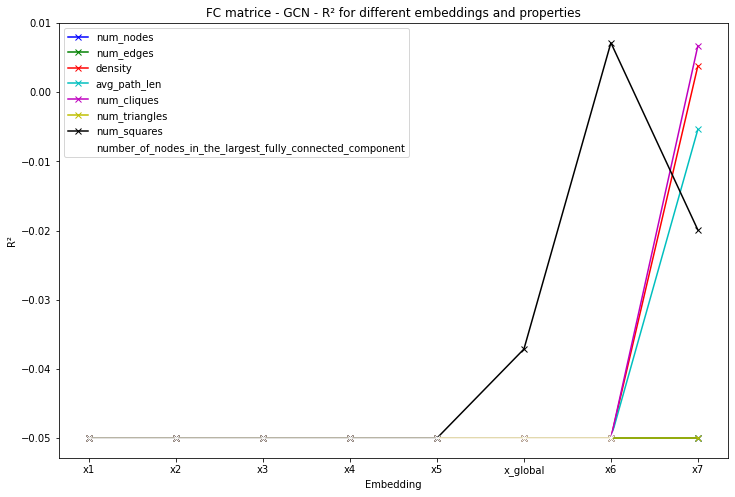

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_test_R2_plot.png', dpi=300, bbox_inches='tight')

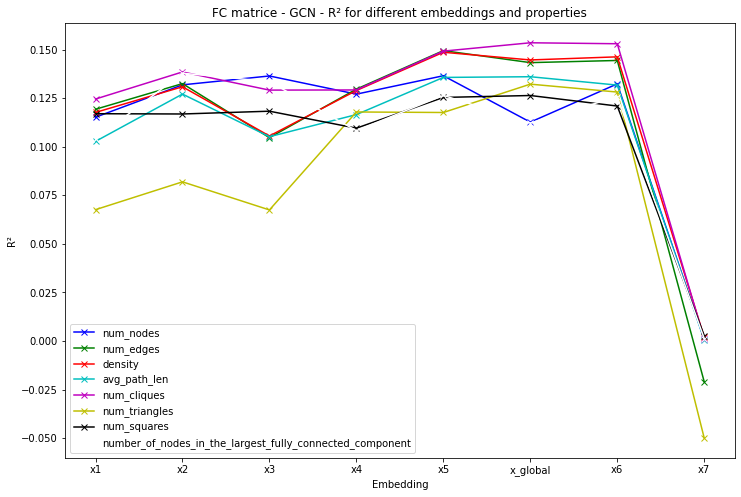

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_train_R2_plot.png', dpi=300, bbox_inches='tight')


# Test with new function that has limited convergence to see if it impacts the test R2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "wb") as f:
    pkl.dump(results, f)

In [18]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "rb") as f:
    results = pkl.load(f)

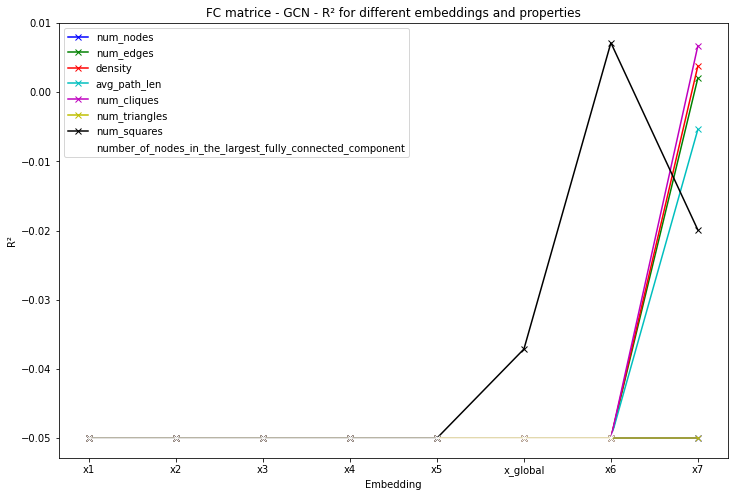

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

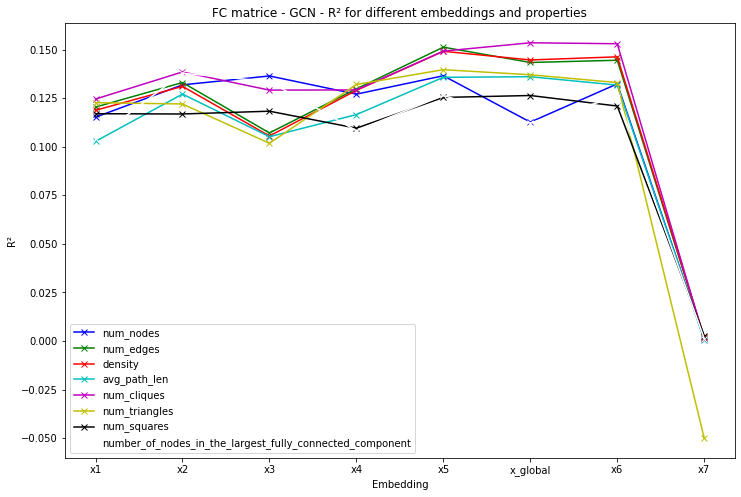

<Figure size 432x288 with 0 Axes>

In [20]:
# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

#### Test with more properties

In [ ]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
   
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi


def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        small_world_index = compute_swi(G)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append((
            num_nodes,
            num_edges,
            density,
            avg_path_len,
            diameter,
            radius,
            clustering_coeff,
            transitivity,
            assortativity,
            num_cliques,
            num_triangles,
            num_squares,
            largest_component_size,
            avg_degree,
            avg_betweenness_centrality,
            spectral_radius,
            algebraic_connectivity,
            graph_energy,
            small_world_coefficient, 
            betweenness_cent,
            pagerank_cent,
            avg_clustering,
            small_world_index           

        ))
    return properties


train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)



In [21]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [ ]:
#print the names of the properties
# print(train_properties_long[0].keys())

#print the first element of the properties
# print(train_properties_long[0])

#copare train_properties and train_properties_long
print(train_properties[0])
print(train_properties_long[0])
print(len(train_properties_long))

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

In [22]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

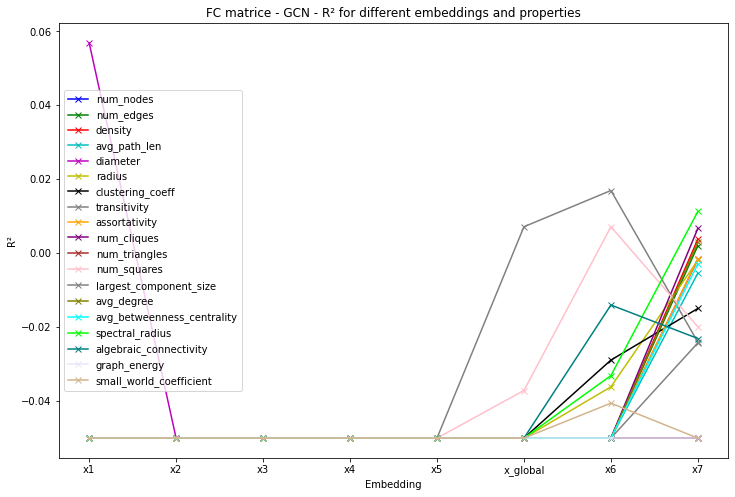

<Figure size 432x288 with 0 Axes>

In [23]:
#import plt
import matplotlib.pyplot as plt
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
#make a color list for the properties names but with different colors
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55)    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2)      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')

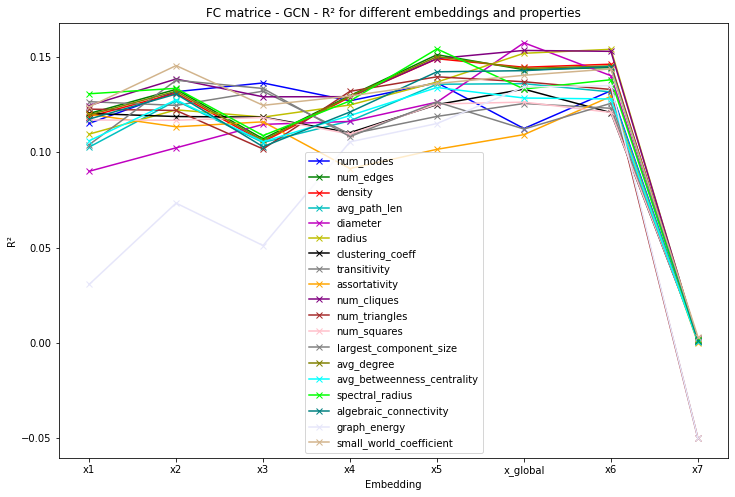

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')
    

### comparison with a gnn train on random (the y are shuffled)

In [14]:
from Datasets.FC.create_dataset import read_dataset
dataset = read_dataset()
MODEL = "GCN_w_edge_weight"
DATASET = "FC_suffled"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset,device="cpu")

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1-4): 4 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [20]:
#shuffle the y values of the dataset
import numpy as np
import torch

y = np.array([data.y for data in dataset])
np.random.shuffle(y)

#make y torch.int64, tensor([0]) instead of [0]
y = torch.tensor(y, dtype=torch.int64)

for i in range(len(dataset)):
    dataset[i].y = y[i]

In [22]:
gnn.iterate()

Epoch: 020, Loss: 0.158, Test Loss: 0.831, Train Acc: 0.998 Test Acc: 0.509
Epoch: 040, Loss: 0.152, Test Loss: 0.867, Train Acc: 0.999 Test Acc: 0.527
Epoch: 060, Loss: 0.118, Test Loss: 0.772, Train Acc: 0.999 Test Acc: 0.491
Epoch: 080, Loss: 0.111, Test Loss: 0.756, Train Acc: 0.999 Test Acc: 0.491
Epoch: 100, Loss: 0.106, Test Loss: 0.807, Train Acc: 0.999 Test Acc: 0.509
Epoch: 120, Loss: 0.099, Test Loss: 0.786, Train Acc: 0.999 Test Acc: 0.473
Epoch: 140, Loss: 0.096, Test Loss: 0.761, Train Acc: 0.999 Test Acc: 0.527
Epoch: 160, Loss: 0.097, Test Loss: 0.748, Train Acc: 0.999 Test Acc: 0.509
Epoch: 180, Loss: 0.092, Test Loss: 0.767, Train Acc: 0.999 Test Acc: 0.473
Epoch: 200, Loss: 0.091, Test Loss: 0.763, Train Acc: 0.999 Test Acc: 0.473
Epoch: 220, Loss: 0.091, Test Loss: 0.769, Train Acc: 0.999 Test Acc: 0.455
Epoch: 240, Loss: 0.089, Test Loss: 0.766, Train Acc: 0.999 Test Acc: 0.473
Epoch: 260, Loss: 0.091, Test Loss: 0.781, Train Acc: 0.999 Test Acc: 0.473
Epoch: 280, 

In [ ]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [ ]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [ ]:
gnn.evaluate()

In [ ]:
train_features, test_features = gnn.evaluate_with_features2()

In [ ]:
train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

In [ ]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [ ]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

In [ ]:
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

In [ ]:
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55)    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2)      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'test_R2_plot_long_random.png')

### Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

##### Node properties

In [ ]:
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
test_node_properties = compute_node_properties(gnn.dataset[gnn.test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [ ]:
len(train_node_properties), len(test_node_properties)

(1600, 400)

In [ ]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(3)]

[25, 27, 27]

We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
is equal to the length of the x matrix in the features. 

##### Node embeddings

In [ ]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

x1 shape: torch.Size([25, 60])
x2 shape: torch.Size([25, 60])
x3 shape: torch.Size([25, 60])
x4 shape: torch.Size([25, 60])
len of features:  4
features[0].shape:  torch.Size([25, 60])
features[1].shape:  torch.Size([25, 60])
features[2].shape:  torch.Size([25, 60])
features[3].shape:  torch.Size([25, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])


In [ ]:
len(train_features), len(test_features)

(1600, 400)

In [ ]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: (27, 60)
Feature 2 shape: (27, 60)
Feature 3 shape: (27, 60)
Feature 4 shape: (27, 60)


In [ ]:
train_features[1][0][26]

array([0.11293012, 0.01297014, 0.        , 0.        , 0.00048169,
       0.        , 0.        , 0.11032721, 0.0006601 , 0.        ,
       0.        , 0.00569319, 0.01119991, 0.        , 0.        ,
       0.        , 0.        , 0.1187728 , 0.02496059, 0.        ,
       0.        , 0.        , 0.09984584, 0.        , 0.16730181,
       0.12269668, 0.        , 0.        , 0.13658862, 0.        ,
       0.        , 0.        , 0.        , 0.02736452, 0.        ,
       0.        , 0.        , 0.01627633, 0.        , 0.00716374,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11217522, 0.00050629, 0.        , 0.04717182,
       0.11243994, 0.        , 0.        , 0.        , 0.06470888,
       0.        , 0.        , 0.        , 0.        , 0.        ])

#### Embedding probing

##### Probing for the top 3 nodes on train_features only and averaging the results of the different diagnostif classifiers

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=3):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [ ]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 3) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 3) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [ ]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [ ]:

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')


R² for local clustering coefficient prediction: [0.4841927549025531, 0.5885748736985221, 0.553935958537314, 0.5937347910192293]
R² for eigenvector centrality prediction: [0.4159696190840295, 0.4910735740692913, 0.5317800215207991, 0.5328035947641372]
R² for node degree prediction: [0.79121277530391, 0.813389031323898, 0.7947223264111095, 0.805799508393025]
R² for betweenness centrality prediction: [0.49523594279566274, 0.53993553609594, 0.5741994943077879, 0.5884060368158552]


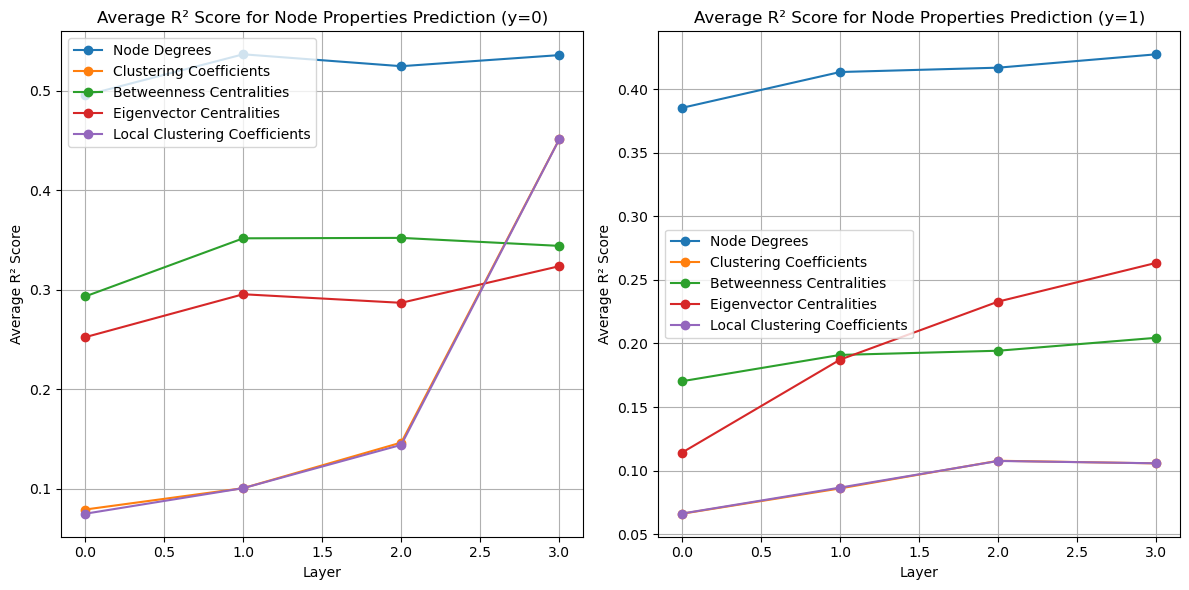

In [ ]:
# Separate the graphs based on labels
def separate_graphs_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, graph in enumerate(gnn.dataset[gnn.train_idx]):
        if graph.y.item() == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

train_features_0, train_properties_0, train_features_1, train_properties_1 = separate_graphs_by_label(train_features, train_node_properties, gnn.dataset[gnn.train_idx])

# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, property_index):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in range(len(graph_features[layer])):
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Training and evaluating linear regression models for each layer
def train_and_evaluate_regression(X_layers, y_layers):
    r2_scores = []
    
    for layer in range(len(X_layers)):
        X = X_layers[layer]
        y = y_layers[layer]
        
        model = LinearModel(X.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X.float())
            loss = criterion(outputs, y.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(X.float()).view(-1)
            r2 = r2_score(y.float(), predictions)
        r2_scores.append(r2)
    
    return r2_scores

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients

properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store R² scores
r2_scores_0 = {name: [] for name in property_names}
r2_scores_1 = {name: [] for name in property_names}

# Compute R² scores for graphs with y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_0, train_properties_0, prop_idx)
    r2_scores_0[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Compute R² scores for graphs with y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_1, train_properties_1, prop_idx)
    r2_scores_1[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Plot the results
layers = np.arange(len(r2_scores_0[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for graphs with y=0
plt.subplot(1, 2, 1)
for prop_name in property_names:
    plt.plot(layers, r2_scores_0[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=0)')
plt.legend()
plt.grid(True)

# Plot for graphs with y=1
plt.subplot(1, 2, 2)
for prop_name in property_names:
    plt.plot(layers, r2_scores_1[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### Probing for the top 1 nodes with diagnostic classifier trained on the train set and test on the test set

Processing property: Node Degrees
Processing property: Clustering Coefficients
Processing property: Betweenness Centralities
Processing property: Eigenvector Centralities
Processing property: Local Clustering Coefficients


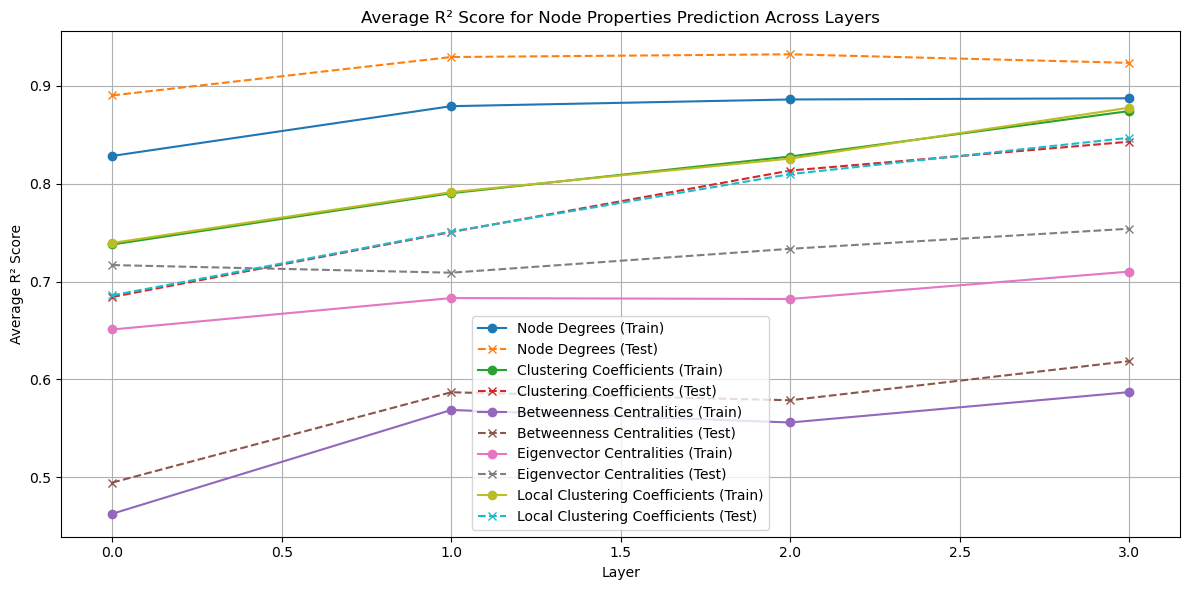

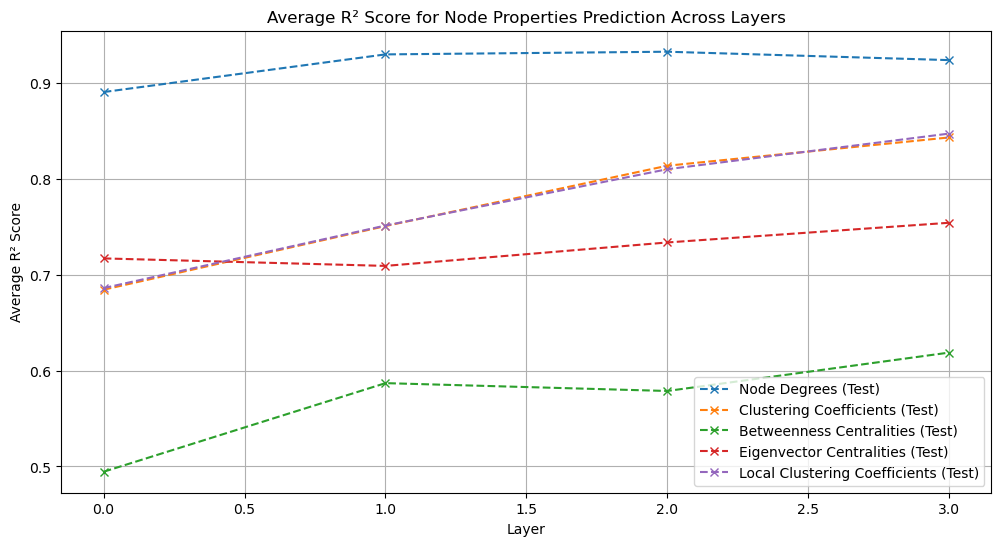

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=1):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

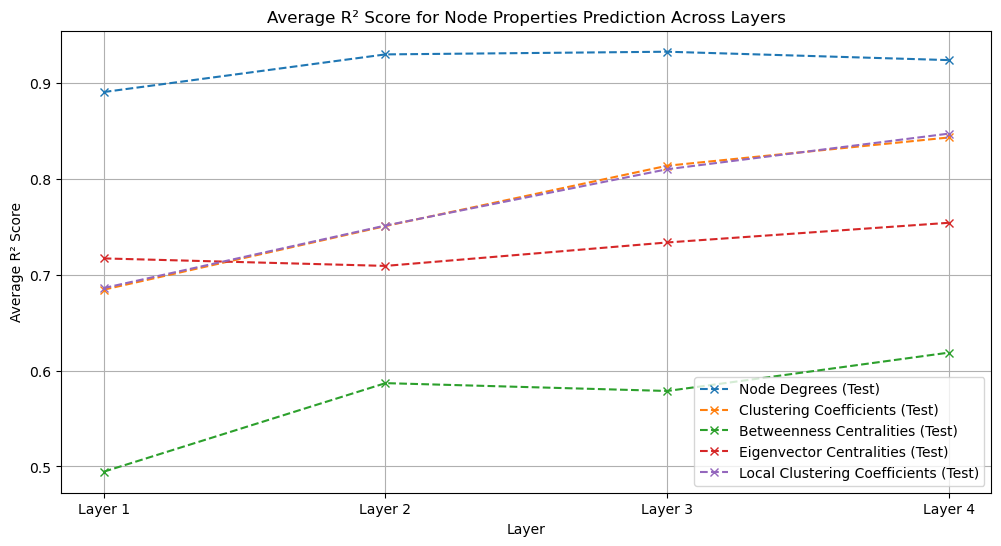

In [ ]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)